# Exploration 1

What if we start small (let $\ell = m = n = 3$ so that we are tracking three variables with three neurons) and attempt to train the neural net to learn the Kalman filter? What does the loss look like over time for various initial values of $M$?

In [1]:
# Import everything needed
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import tqdm

from hm_process import HMProcess, plot_hm_process
from kalman import SteadyStateKalmanFilter
from rnn import NeuralNet, Param
from utils import mk_rand_matrix, mk_rand_matrix_envals

rng = np.random.default_rng()

In [2]:
# Define some arbitrary parameters
def create_process_3d(rng, A=None):
    if A is None:
        A = np.diag([0.98, 0.96, 0.94])
    x0 = np.array([100, 100, 100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(3)
    O = np.eye(3)
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(3)
    num_steps = 100
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

proc = create_process_3d(rng)

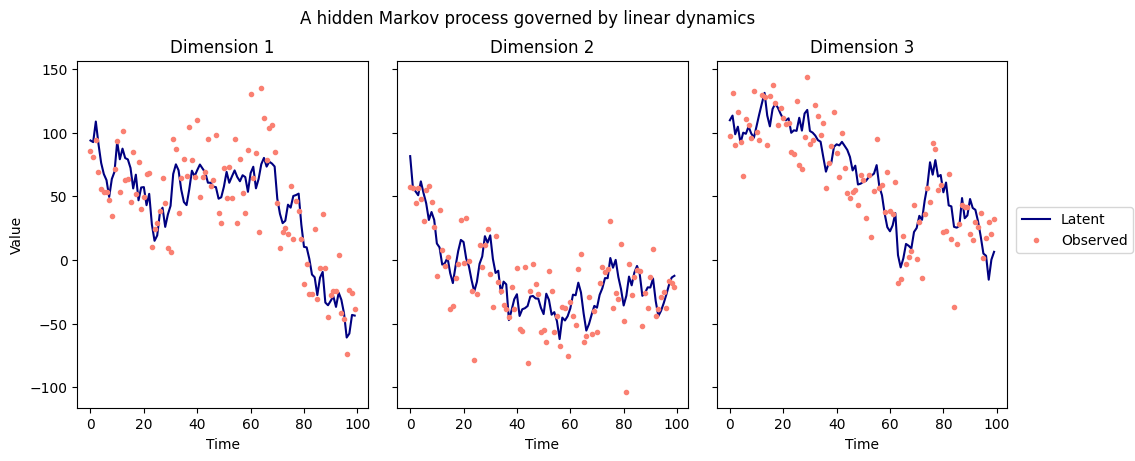

In [3]:
ts, xs, ys = proc.simulate()
plot_hm_process('A hidden Markov process governed by linear dynamics', ts, xs, ys)

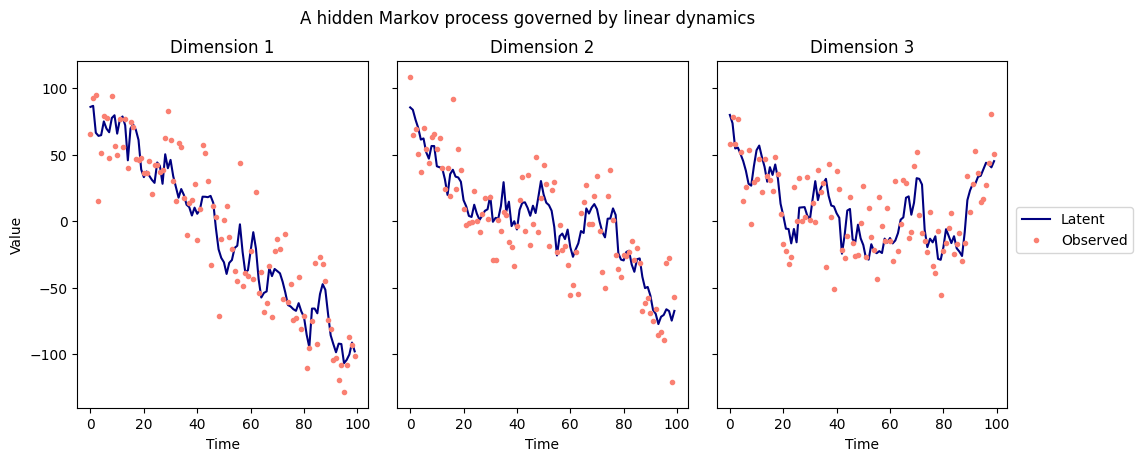

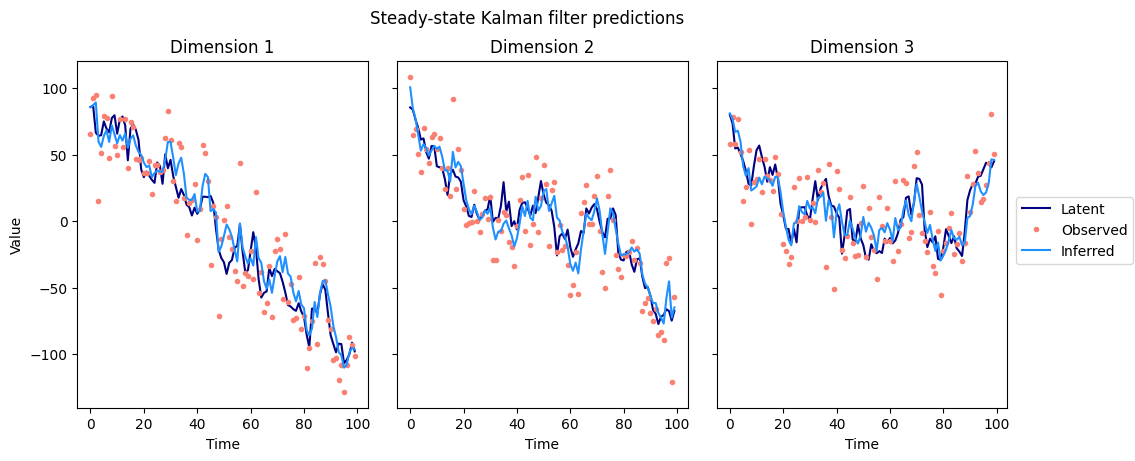

In [4]:
# Now, what if we try to predict what the latent states were based
# on the observations by using a steady-state Kalman filter, assuming
# we know the true values of A, Sigma_process, O, and Sigma_obs?
ts, xs, ys = proc.simulate()
kf = SteadyStateKalmanFilter(proc)
xhats = kf.infer(ys)

# Now, let's plot it!
plot_hm_process('A hidden Markov process governed by linear dynamics', ts, xs, ys)
plot_hm_process('Steady-state Kalman filter predictions', ts, xs, ys, xhats)

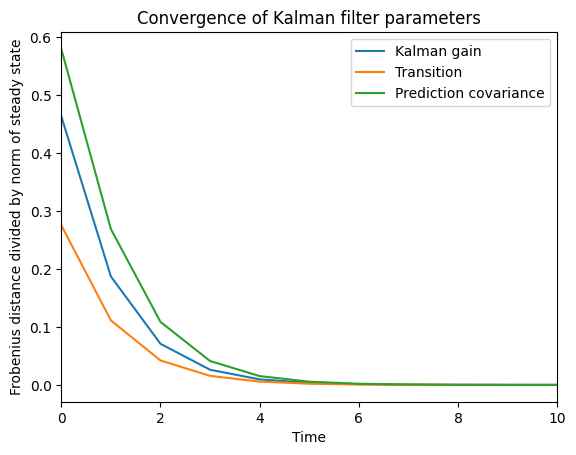

In [5]:
# Let's check how well the Kalman filter converges to the steady-state Kalman filter.
Sigma_infty_dist, K_infty_dist, M_infty_dist, _, _, _ = kf.check_convergence()
plt.plot(np.arange(proc.num_steps), K_infty_dist/np.linalg.norm(kf.K_infty, ord='fro'), label='Kalman gain')
plt.plot(np.arange(proc.num_steps), M_infty_dist/np.linalg.norm(kf.M_infty, ord='fro'), label='Transition')
plt.plot(np.arange(proc.num_steps), Sigma_infty_dist/np.linalg.norm(kf.Sigma_infty, ord='fro'), label='Prediction covariance')
plt.title('Convergence of Kalman filter parameters')
plt.xlabel('Time')
plt.ylabel('Frobenius distance divided by norm of steady state')
plt.xlim(0,10)
plt.legend()
plt.show()


In [6]:
# Now, let's see if we can train a linear dynamical system to learn the Kalman filter.
# First, let's make the matrix A of the hidden Markov process random.
A = mk_rand_matrix_envals(rng, np.array([0.98, 0.96, 0.94]))
proc = create_process_3d(rng, A)
kf = SteadyStateKalmanFilter(proc)

In [7]:
# How well does the network do if I make the connectivity matrix
# closer or farther from the Kalman filter theory steady-state value?
def test_M_landscape():
    distances = []
    losses = []
    for _ in range(3):
        M = mk_rand_matrix(rng, 3)
        for i in tqdm.tqdm(range(10)):
            c = i/10
            M2 = (1-c)*M + c*kf.M_infty
            nn = NeuralNet(kf.K_infty, M2, np.eye(3), proc.x0)
            Ls = nn.batch_test(100, proc)
            distances.append(np.linalg.norm(M2 - kf.M_infty, ord='fro'))
            losses.append(np.mean(Ls))
    return np.array(distances), np.array(losses)

# distances, losses = test_M_landscape()

In [8]:
# Let's try plotting our results
# plt.scatter(distances[:10], losses[:10])
# plt.scatter(distances[10:20], losses[10:20])
# plt.scatter(distances[20:], losses[20:])
# plt.xlabel('Frobenius distance between M and the optimal value')
# plt.ylabel('Average loss (100 simulated trials)')
# plt.title('Loss vs distance from Kalman filter theory')
# plt.show()

In [9]:
# What happens when we train the neural net on this task?
def compare_nn_kalman(rng, proc, epsilons, batch_size=40, mask=None, train_vars=None):
    if mask is None:
        mask = np.full((proc.n, proc.n), 1)
    
    ts, xs, ys = proc.simulate()
    print('A =', proc.A)
    print('Eigenvalues = ', np.linalg.eig(proc.A).eigenvalues)
    
    nn = NeuralNet(0.1*mk_rand_matrix(rng, proc.n),
                   0.1*mk_rand_matrix(rng, proc.n),
                   np.eye(proc.n),
                   proc.x0,
                   mask=mask,
                   train_vars=train_vars)
    
    _, _, xhats = nn.forward(ys)
    plot_hm_process('Before training', ts, xs, ys, xhats)
    print('Loss', proc.calc_loss(xhats, xs))
    print('M =', nn.M)
    print('K =', nn.K)
    print('W =', nn.W)
    
    losses, _, _, _ = nn.train(epsilons, batch_size, proc)
    plt.plot(np.log10(losses))
    plt.title('Log loss over time')
    plt.xlabel('Batch')
    plt.ylabel('Log mean loss')
    plt.show()
    
    _, _, xhats = nn.forward(ys)
    plot_hm_process('After training', ts, xs, ys, xhats)
    print('Loss', proc.calc_loss(xhats, xs))
    print('M =', nn.M)
    print('K =', nn.K)
    print('W =', nn.W)
    
    # How does it compare to a Kalman filter?
    kf = SteadyStateKalmanFilter(proc)
    xhats = kf.infer(ys)
    plot_hm_process('Kalman filter', ts, xs, ys, xhats)
    print('Loss', proc.calc_loss(xhats, xs))
    print('M =', kf.M_infty)
    print('K =', kf.K_infty)
    print('W =', np.eye(proc.n))

    kf_nn = NeuralNet(kf.M_infty, kf.K_infty, np.eye(proc.n), proc.x0)
    losses = kf_nn.batch_test(batch_size, proc)
    print('Mean loss', np.mean(losses))

# compare_nn_kalman(rng, proc, np.concatenate((np.full(10, 1e-6), np.full(30, 2e-7), np.full(50, 1e-7), np.full(50, 5e-8), np.full(30, 1e-8))))

# Exploration 2

What's the right measure of distance between $(M,K)$ and $A$ that corresponds to the average loss at the task? We'll assume $O$ and $W$ are the identity. Can we plot a loss landscape for the task?

In [10]:
# Let's start with 1 dimension for easy visualization
def create_1d_process(rng, A):
    x0 = np.array([100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(1)
    O = np.array([[1]])
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(1)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

batch_size = 5
num_a_ticks = 5
num_ticks = 20
a_vals = np.array([-0.95, -0.8, 0, 0.8, 0.95])
num_a_ticks = a_vals.shape[0]
mk_range = 0.99
num_trials_per = 40
W = np.array([[1]])

In [11]:
def find_nn_values_A_M_K_1d(num_nns=2):
    mks = [] # mks[i][j] contains the values of M and K for the jth trial with the ith value of A

    for i, a_ in enumerate(a_vals):
        A = np.array([[a_]])
        mks_i = []
        for j in tqdm.tqdm(range(num_nns)):
            proc = create_1d_process(rng, A)
            nn = NeuralNet(0.1*mk_rand_matrix(rng, 1), 0.1*mk_rand_matrix(rng, 1), np.eye(1), proc.x0,
                           train_vars={Param.M, Param.K})
            _, Ms, Ks, _ = nn.train(np.concatenate((np.full(20, 1e-5), np.full(30, 5e-6), np.full(20, 1e-6))),
                                    num_trials_per, proc, print_loss=False, progress_bar=False)
            mks_i.append((Ms.flatten(), Ks.flatten()))
        mks.append(mks_i)

    return mks

# mks = find_nn_values_A_M_K_1d()

In [12]:
def test_A_M_K_loss_landscape_1d():
    losses = np.zeros((num_a_ticks,num_ticks,num_ticks))
    W = np.array([[1]])
    
    for i1, a_ in tqdm.tqdm(enumerate(a_vals), total=num_a_ticks):
        for i2, m_ in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
            for i3, k_ in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
                A = np.array([[a_]])
                M = np.array([[m_]])
                K = np.array([[k_]])
                proc = create_1d_process(rng, A)
                nn = NeuralNet(M, K, W, proc.x0)
                Ls = nn.batch_test(batch_size, proc)
                losses[i1,i2,i3] = np.mean(Ls)
    
    return losses

# losses = test_A_M_K_loss_landscape_1d()

In [13]:
# norm = matplotlib.colors.Normalize(3, 4.8)
# for i1, a_ in enumerate(a_vals):

#    # Loss landscape
#    c = plt.imshow(np.log10(losses[i1].T), origin='lower', extent=(-1*mk_range,mk_range,-1*mk_range,mk_range), norm=norm)
#    plt.xlabel('M')
#    plt.ylabel('K')

#    # Where does the Kalman filter fall?
#    A = np.array([[a_]])
#    proc = create_1d_process(rng, A)
#    kf = SteadyStateKalmanFilter(proc)
#    plt.plot(kf.M_infty, kf.K_infty, color='black', marker='o')
#    plt.annotate('Kalman filter', (kf.M_infty, kf.K_infty),
#                 xytext=(kf.M_infty-0.2, kf.K_infty+0.05), color='black')

#    # What about the RNNs?
#    colors = ['red', 'tomato']
#    for j in range(2):
#        plt.plot(mks[i1][j][0], mks[i1][j][1], color=colors[j], linestyle='-', marker='o', markersize=3)
   
#    plt.title(f'(M, K) Log-Loss Landscape For A={a_:.2f}')
#    plt.xlim(-1*mk_range, mk_range)
#    plt.ylim(-1*mk_range, mk_range)
#    plt.colorbar(c)
#    plt.show()

In [14]:
#def test_mk(proc, m_, k_):
#    A, M, K = proc.A, np.array([[m_]]), np.array([[k_]])
#    nn = NeuralNet(M, K, W, proc.x0)
#    proc = create_1d_process(rng, A)
#    losses = nn.batch_test(100, proc)
#    print(np.mean(losses))

#A = np.array([[a_vals[-1]]])
#proc = create_1d_process(rng, A)
#kf = SteadyStateKalmanFilter(proc)

#m_ = mks[-1][0][0][-1]
#k_ = mks[-1][0][1][-1]
#test_mk(proc, m_, k_)
#test_mk(proc, kf.M_infty, kf.K_infty)

#ts, xs, ys = proc.simulate()

#nn = NeuralNet(np.array([[m_]]), np.array([[k_]]), np.eye(1), proc.x0)
#_, _, xhats = nn.forward(ys)
#plot_hm_process('After training', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', nn.M)
#print('K =', nn.K)

#xhats = kf.infer(ys)
#plot_hm_process('Kalman filter', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', kf.M_infty)
#print('K =', kf.K_infty)

In [15]:
# # What about two dimensions?
# def create_2d_process(rng, A):
#     x0 = np.array([100, 100])
#     sigma_process = 10
#     Sigma_process = (sigma_process**2)*np.eye(2)
#     O = np.eye(2)
#     sigma_obs = 20
#     Sigma_obs = (sigma_obs**2)*np.eye(2)
#     num_steps = 50
#     return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

# batch_size = 5
# num_a_ticks = 5
# num_ticks = 20
# A = mk_rand_matrix_envals(rng, np.array([0.9, 0.97]))
# proc = create_2d_process(rng, A)
# kf = SteadyStateKalmanFilter(proc)
# mk_range = 0.99
# num_trials_per = 40
# W = np.eye(2)

In [16]:
# def test_K_loss_landscape_2d():
#     M = kf.M_infty
    
#     losses = np.zeros((num_ticks,num_ticks))    
#     for i_k1, k_ev1 in tqdm.tqdm(enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)), total=num_ticks):
#         for i_k2, k_ev2 in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
#             K = mk_rand_matrix_envals(rng, np.array([k_ev1, k_ev2]))
#             nn = NeuralNet(M, K, W, proc.x0)
#             Ls = nn.batch_test(batch_size, proc)
#             losses[i_k1,i_k2] = np.mean(Ls)
    
#     return losses

# #losses_K = test_K_loss_landscape_2d()

In [17]:
# def test_M_loss_landscape_2d():
#     K = kf.K_infty
    
#     losses = np.zeros((num_ticks,num_ticks))    
#     for i_m1, m_ev1 in tqdm.tqdm(enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)), total=num_ticks):
#         for i_m2, m_ev2 in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
#             M = mk_rand_matrix_envals(rng, 2, np.array([m_ev1, m_ev2]))
#             nn = NeuralNet(M, K, W, proc.x0)
#             Ls = nn.batch_test(batch_size, proc)
#             losses[i_m1,i_m2] = np.mean(Ls)
    
#     return losses

# #losses_M = test_M_loss_landscape_2d()

In [18]:
# def test_M_loss_landscape_2d_diagentry():
#     K = kf.K_infty
#     M = kf.K_infty
    
#     losses = np.zeros((num_ticks,num_ticks))    
#     for i_m1, m1 in tqdm.tqdm(enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)), total=num_ticks):
#         for i_m2, m2 in enumerate(np.linspace(-1*mk_range,mk_range,num_ticks)):
#             M[0,0] = m1
#             M[1,1] = m2
#             nn = NeuralNet(M, K, W, proc.x0)
#             Ls = nn.batch_test(batch_size, proc)
#             losses[i_m1,i_m2] = np.mean(Ls)
    
#     return losses

# #losses_M_diag = test_M_loss_landscape_2d_diagentry()

In [19]:
# Loss landscape
#norm = matplotlib.colors.Normalize(4, 6)
#c = plt.imshow(np.log10(losses_M_diag.T), origin='lower', extent=(-1*mk_range,mk_range,-1*mk_range,mk_range), norm=norm)
#plt.xlabel('M diag 1')
#plt.ylabel('M diag 2')

# Where does the Kalman filter fall?
#envals = (kf.M_infty[0,0], kf.M_infty[1,1])
#plt.plot(envals[0], envals[1], color='black', marker='o')
#plt.annotate('Kalman filter', (envals[0], envals[1]),
#             xytext=(envals[0]-0.2, envals[1]+0.05), color='black')

# What about the RNNs?
#plt.scatter(mks[i1,:,0], mks[i1,:,1], color='red', marker='o')

#plt.title(f'M Log-Loss Landscape')
#plt.xlim(-1*mk_range, mk_range)
#plt.ylim(-1*mk_range, mk_range)
#plt.colorbar(c)
#plt.show()

In [20]:
#kf = SteadyStateKalmanFilter(proc)
#ts, xs, ys = proc.simulate()

#nn = NeuralNet(np.diag((0,0.5)), kf.K_infty, np.eye(2), proc.x0)
#_, _, xhats = nn.forward(ys)
#plot_hm_process('After training', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', nn.M)
#print('K =', nn.K)

#xhats = kf.infer(ys)
#plot_hm_process('Kalman filter', ts, xs, ys, xhats)
#print('Loss', proc.calc_loss(xhats, xs))
#print('M =', kf.M_infty)
#print('K =', kf.K_infty)

#print(kf.Sigma_infty)

# Exploration 3
The goal of this exploration is to work out some possible bugs with the implementation of the Kalman filter (why does the covariance matrix not converge properly?) and find an appropriate method to systematically determine values of the buy-in period (at what time step do we start the loss calculation?) and input gain.

First bug solved: the issue was that I was plotting the distance between the posterior estimate covariance and the steady-state estimate covariance when I should have been plotting the distance between the prior estimate covariance and the steady-state estimate covariance instead. Now the graph looks as expected.

Let's experiment next with simulating 1D processes and checking how long the buy-in period is.

In [21]:
def create_process_1d_more_parameters(rng, a, sigma_process, sigma_obs):
    A = np.array([[a]])
    x0 = np.array([100])
    Sigma_process = (sigma_process**2)*np.eye(1)
    O = np.eye(1)
    Sigma_obs = (sigma_obs**2)*np.eye(1)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps, start_from=0)

def time_of_convergence(proc, eps=0.05, i=0):
    kf = SteadyStateKalmanFilter(proc)
    Sigma_infty_dist, K_infty_dist, M_infty_dist, _, _, _ = kf.check_convergence()
    for i in range(proc.num_steps-1,-1,-1):
        if Sigma_infty_dist[i] > eps:
            return i+1
        if K_infty_dist[i] > eps:
            return i+1
        if M_infty_dist[i] > eps:
            return i+1
    return 0

def plot_1d_kalman_convergence_dynamics():
    num_points = 100
    a_vals = np.linspace(0.01,0.99,num_points)
    t_vals = np.zeros(num_points)
    for i in range(num_points):
        proc = create_process_1d_more_parameters(rng, a_vals[i], 10, 25)
        t_vals[i] = time_of_convergence(proc)
    plt.plot(a_vals, t_vals, label='Actual trend')
    plt.plot(a_vals, -1/np.log(a_vals), label='Proportional to time constant')
    plt.plot(a_vals, 11*a_vals+2, label='Roughly linear')
    plt.title('Length of buy-in period vs largest eigenvalue (1D)')
    plt.xlabel('Largest eigenvalue of A')
    plt.ylabel('Time until <5% error')
    plt.ylim(0,12)
    plt.legend()
    plt.show()

#plot_1d_kalman_convergence_dynamics()

It looks like the fit is not proportional to the time constant of the process, as I would have expected, but instead is roughly linear! Choosing a buy-in time period of eleven times the value of A plus two should be sufficient for letting the Kalman filter converge. What if we try changing the noise parameters?

In [22]:
def plot_1d_kalman_convergence_noise():
    num_points = 30
    max_proc_noise = 50
    max_obs_noise = 50
    sigma_proc_vals = np.linspace(1,max_proc_noise,num_points)
    sigma_obs_vals = np.linspace(1,max_obs_noise,num_points)
    t_vals = np.zeros((num_points,num_points))
    for i in range(num_points):
        for j in range(num_points):
            proc = create_process_1d_more_parameters(rng, 0.99, sigma_proc_vals[i], sigma_obs_vals[j])
            t_vals[i,j] = time_of_convergence(proc)
    norm = matplotlib.colors.Normalize(0, 11)
    plt.imshow(t_vals, extent=(1,max_obs_noise,1,max_proc_noise), origin='lower', norm=norm)
    x_vals = np.linspace(1, max_obs_noise, 200)
    plt.plot(x_vals, x_vals/2, color='red')
    plt.title('Length of buy-in period vs noise (1D)')
    plt.xlabel('Observation noise standard deviation')
    plt.ylabel('Process noise standard deviation')
    plt.xlim(1, max_obs_noise)
    plt.ylim(1, max_proc_noise)
    plt.colorbar()
    plt.show()

#plot_1d_kalman_convergence_noise()

Process and observation noise seem to make the convergence take much longer when the observation noise is high and the process noise is very low. A=0.99 originally took 11 steps, and most of this graph is in the non-yellow region where the number of steps needed is below 11 steps, as long as the observation noise is less than twice the process noise (which is the red line).

Now, let's try it with multi-dimensional processes.

In [23]:
def create_process_3d_based_on_envals(rng, enval1, enval2, enval3):
    A = mk_rand_matrix_envals(rng, np.array([enval1, enval2, enval3]))
    x0 = np.array([100, 100, 100])
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(3)
    O = np.eye(3)
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(3)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

def plot_3d_kalman_convergence_dynamics():
    max_envals = []
    t_vals = []
    num_points = 10
    enval_space = np.linspace(0.01,0.99,num_points)
    for enval1 in enval_space:
        for enval2 in enval_space:
            for enval3 in enval_space:
                try:
                    proc = create_process_3d_based_on_envals(rng, enval1, enval2, enval3)
                    t_vals.append(time_of_convergence(proc))
                    max_envals.append(max(enval1, enval2, enval3))
                except sklearn.exceptions.ConvergenceWarning:
                    pass
    
    plt.scatter(max_envals, t_vals)
    plt.title('Length of buy-in period vs largest eigenvalue (3D)')
    plt.xlabel('Largest eigenvalue of A')
    plt.ylabel('Time until <5% error')
    plt.show()

#plot_3d_kalman_convergence_dynamics()

The graph has roughly the same shape as in the 1D case, which is reassuring, although there are some matrices which are outliers. Let's check one of them by hand. All in all, I conclude that if the process noise is more than half the observation noise, then a buy-in period of a little bit more than 10 times the largest eigenvalue of the dynamics matrix should suffice.

Next, how do we deal with the input gain?

In [24]:
def find_appropriate_gain(proc, M):
    # return best K?
    pass

def plot_gain_function():
    norm = matplotlib.colors.Normalize(3, 4.8)
    for i1, a_ in enumerate(a_vals):
    
        # Loss landscape
        c = plt.imshow(np.log10(losses[i1].T), origin='lower', extent=(-1*mk_range,mk_range,-1*mk_range,mk_range), norm=norm)
        plt.xlabel('M')
        plt.ylabel('K')
    
        # Best values for K, given M?
        ms = np.linspace(-1*mk_range, mk_range, 100)
        ks = []
        proc = create_1d_process(rng, np.array([[a_]]))
        for m_ in ms:
            K = find_appropriate_gain(proc, np.array([[m_]]))
            ks.append(K[0,0])
        ks = np.array(ks)
        plt.plot(ms, ks, color='red')
        
        plt.title(f'(M, K) Log-Loss Landscape For A={a_:.2f}')
        plt.xlim(-1*mk_range, mk_range)
        plt.ylim(-1*mk_range, mk_range)
        plt.colorbar(c)
        plt.show()

#plot_gain_function()

# Exploration 4
Now, what if we add some structure onto our connectivity matrix?

In [25]:
# Let's see if the loss is impacted by a mask

def mk_nd_proc(rng, n, envals=None, A=None):
    if A is None:
        if envals is None:
            envals = np.linspace(0.8, 0.95, n)
        A = mk_rand_matrix_envals(rng, envals)
    x0 = np.full(n, 100)
    sigma_process = 10
    Sigma_process = (sigma_process**2)*np.eye(n)
    O = np.eye(n)
    sigma_obs = 20
    Sigma_obs = (sigma_obs**2)*np.eye(n)
    num_steps = 50
    return HMProcess(rng, A, x0, Sigma_process, O, Sigma_obs, num_steps)

def test_masks(rng, n, masks, etas, envals=None, A=None):
    num_processes = 1
    num_nns = 3
    batch_size = 40
    processes = []
    data = [] # loss indexed by process number, then number of connections, then pattern
    for process_num in range(num_processes):
        data_this_rep = dict()
        proc = mk_nd_proc(rng, n, envals=envals, A=A)
    
        print('Process dynamics:', proc.A)
        print('Eigenvalues:', np.linalg.eig(proc.A).eigenvalues)
        kf = SteadyStateKalmanFilter(proc)
        print('Kalman filter M:', kf.M_infty)
        print('Kalman filter K:', kf.K_infty)
        nn = NeuralNet(kf.M_infty, kf.K_infty, np.eye(n), proc.x0)
        Ls = nn.batch_test(batch_size, proc)
        print('Kalman filter loss:', np.mean(Ls))

        max_val_A = np.max(np.abs(proc.A))

        for name, mask in tqdm.tqdm(masks.items()):
            num_connections = np.count_nonzero(mask)
            losses = []
            trial_num = 1
            while True:
                if trial_num > 100:
                    raise FloatingPointError(f'Gradient descent of {num_nns} networks unsuccessful after 100 attempts')
                try:
                    print(f'Testing {name}, Trial {trial_num}')
                    nn = NeuralNet(0.1*max_val_A*mk_rand_matrix(rng, n), 0.1*max_val_A*mk_rand_matrix(rng, n),
                                   np.eye(n), proc.x0, mask=mask)
                    Ls, _, _, _ = nn.train(etas, batch_size, proc,
                                           print_loss=False, progress_bar=False)
                    loss = Ls[-1]
                    losses.append(loss)
                    print('NN M:', nn.M)
                    print('NN K:', nn.K)
                    print('NN W:', nn.W)
                    print('Loss:', loss)
                    if len(losses) >= num_nns:
                        break
                    trial_num += 1
                except FloatingPointError:
                    trial_num += 1
            min_loss = np.min(losses)
            if num_connections in data_this_rep:
                data_this_rep[num_connections][name] = min_loss
            else:
                data_this_rep[num_connections] = {name: min_loss}
        processes.append(proc)
        data.append(data_this_rep)
        
        N = len(data_this_rep)
        fig, axs = plt.subplots(1, N, sharey=True, squeeze=False)
        axs = np.reshape(axs, (N,))
        fig.set_size_inches(12, 4.5)
        for i, (num_connections, d) in enumerate(data_this_rep.items()):
            xticks = np.arange(len(d))
            axs[i].bar(xticks, d.values())
            axs[i].set_xticks(xticks, d.keys(), rotation=90)
            axs[i].set_title(f'Process {process_num},\n{num_connections} connections')
        axs[0].set_ylabel('Loss')
        plt.show()

    return data

In [26]:
masks_one_neuron = {
    'Empty': np.array([[0]]),
    'One loop': np.array([[1]])
}

masks_two_neurons = {
    'Empty': np.array([
        [0, 0],
        [0, 0]
    ]),
    'One loop': np.array([
        [1, 0],
        [0, 0]
    ]),
    'Uni-directional': np.array([
        [0, 1],
        [0, 0]
    ]),
    'Two loops': np.array([
        [1, 0],
        [0, 1]
    ]),
    'Loop pointing outward': np.array([
        [1, 0],
        [1, 0]
    ]),
    'Loop pointing inward': np.array([
        [0, 0],
        [1, 1]
    ]),
    'Bidirectional': np.array([
        [0, 1],
        [1, 0]
    ]),
    'Loop pointing to loop': np.array([
        [1, 0],
        [1, 1]
    ]),
    'Loop with bidirectional': np.array([
        [1, 1],
        [1, 0]
    ]),
    'Full': np.array([
        [1, 1],
        [1, 1]
    ])
}

masks_three_neurons_all_loops = {
    'Empty': np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ]),
    'Unidirectional': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 0, 1]
    ]),
    'Source': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [1, 0, 1]
    ]),
    'Bidirectional': np.array([
        [1, 1, 0],
        [1, 1, 0],
        [0, 0, 1]
    ]),
    'Linear': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [0, 1, 1]
    ]),
    'Sink': np.array([
        [1, 0, 0],
        [1, 1, 1],
        [0, 0, 1]
    ]),
    'Bidirectional out': np.array([
        [1, 1, 0],
        [1, 1, 0],
        [1, 0, 1]
    ]),
    'Transitive triangle': np.array([
        [1, 0, 0],
        [1, 1, 0],
        [1, 1, 1]
    ]),
    'Bidirectional in': np.array([
        [1, 1, 1],
        [1, 1, 0],
        [0, 0, 1]
    ]),
    'Cycle': np.array([
        [1, 0, 1],
        [1, 1, 0],
        [0, 1, 1]
    ]),
    'Bidirectional source': np.array([
        [1, 1, 0],
        [1, 1, 0],
        [1, 1, 1]
    ]),
    'Two bidirectionals': np.array([
        [1, 1, 1],
        [1, 1, 0],
        [1, 0, 1]
    ]),
    'Bidirectional loop': np.array([
        [1, 1, 0],
        [1, 1, 1],
        [1, 0, 1]
    ]),
    'Bidirectional sink': np.array([
        [1, 0, 0],
        [1, 1, 1],
        [1, 1, 1]
    ]),
    'Full minus one': np.array([
        [1, 1, 1],
        [1, 1, 0],
        [1, 1, 1]
    ]),
    'Full': np.array([
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]
    ])
}

## One neuron

In [27]:
# proc = mk_nd_proc(rng, 1,
#                   A=np.array([[0.95]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(10, 1e-5), np.full(10, 5e-6), np.full(20, 1e-6), np.full(20, 5e-7))))

Process dynamics: [[0.95]]
Eigenvalues: [0.95]
Kalman filter M: [[0.60049406]]
Kalman filter K: [[0.36790099]]
Kalman filter loss: 2768.254027521988


  0%|                                                                    | 0/2 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.]]
NN K: [[0.86862621]]
NN W: [[0.97706995]]
Loss: 6293.971767613996
Testing Empty, Trial 2
NN M: [[0.]]
NN K: [[0.80725325]]
NN W: [[1.0609743]]
Loss: 6005.81497108734
Testing Empty, Trial 3


 50%|██████████████████████████████                              | 1/2 [01:04<01:04, 64.58s/it]

NN M: [[0.]]
NN K: [[0.87810408]]
NN W: [[0.96958207]]
Loss: 6116.1217991327785
Testing One loop, Trial 1
NN M: [[0.53554455]]
NN K: [[0.41804546]]
NN W: [[1.03412949]]
Loss: 3112.80089527135
Testing One loop, Trial 2
NN M: [[0.48648751]]
NN K: [[0.43005765]]
NN W: [[1.12002345]]
Loss: 2898.2266309522834
Testing One loop, Trial 3


100%|████████████████████████████████████████████████████████████| 2/2 [02:14<00:00, 67.45s/it]

NN M: [[0.49258048]]
NN K: [[0.42130713]]
NN W: [[1.12320313]]
Loss: 2956.9671407503674


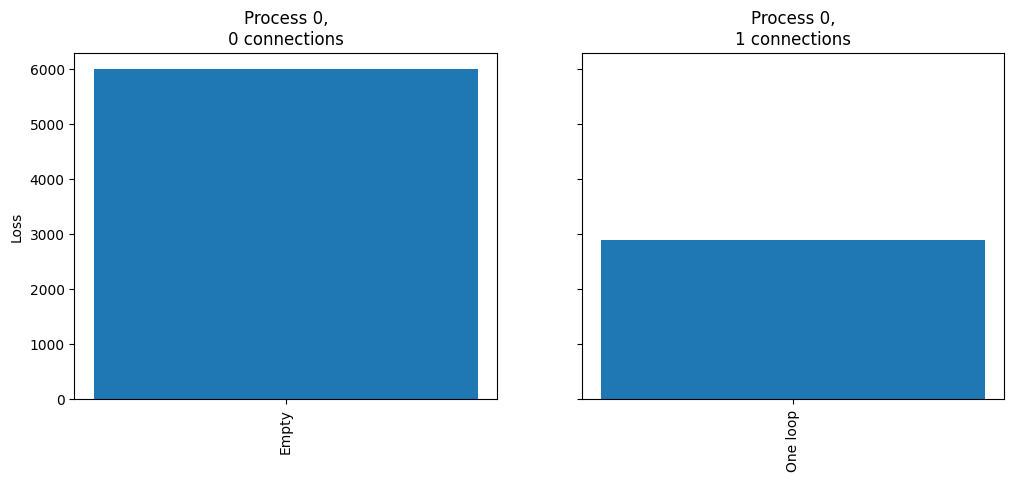

[{0: {'Empty': 6005.81497108734}, 1: {'One loop': 2898.2266309522834}}]

In [28]:
test_masks(rng, 1, masks_one_neuron, np.concatenate((np.full(10, 1e-5), np.full(10, 5e-6), np.full(20, 1e-6), np.full(20, 5e-7))),
           A=np.array([[0.95]]))

## Two neurons

### Near-diagonal

In [29]:
# proc = mk_nd_proc(rng, 2,
#                   A=np.array([[0.8, 0.03], [-0.03, 0.95]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))))

Process dynamics: [[ 0.8   0.03]
 [-0.03  0.95]]
Eigenvalues: [0.80626136 0.94373864]
Kalman filter M: [[ 0.55231287  0.01881604]
 [-0.02055463  0.60034482]]
Kalman filter K: [[0.30968365 0.00199311]
 [0.00199311 0.36799514]]
Kalman filter loss: 5087.400890679013


  0%|                                                                   | 0/10 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.22489514 1.13362847]
 [0.25428995 0.88109986]]
NN W: [[ 0.45620429 -0.51281875]
 [-0.16753227  1.06405108]]
Loss: 9294.125448233817
Testing Empty, Trial 2
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.30396039 1.26545945]
 [0.05616457 0.68681828]]
NN W: [[ 0.35233322 -0.5499541 ]
 [-0.00284655  1.1159582 ]]
Loss: 8343.496201540267
Testing Empty, Trial 3


 10%|█████▉                                                     | 1/10 [01:22<12:18, 82.11s/it]

NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.18407122 1.07340997]
 [0.28603711 0.94715786]]
NN W: [[ 0.50129605 -0.49910196]
 [-0.18103341  0.99399945]]
Loss: 8420.93600932254
Testing One loop, Trial 1
NN M: [[0.51620924 0.        ]
 [0.         0.        ]]
NN K: [[0.59963617 0.22966663]
 [0.10837378 0.83603388]]
NN W: [[ 0.60853094 -0.25419838]
 [ 0.05527158  0.88582143]]
Loss: 8127.222848007301
Testing One loop, Trial 2
NN M: [[0.53772827 0.        ]
 [0.         0.        ]]
NN K: [[0.68601028 0.29508526]
 [0.05359746 0.72940164]]
NN W: [[ 0.49099127 -0.31102394]
 [ 0.08304161  1.00301775]]
Loss: 7861.058678917197
Testing One loop, Trial 3


 20%|███████████▊                                               | 2/10 [02:47<11:10, 83.80s/it]

NN M: [[0.49393072 0.        ]
 [0.         0.        ]]
NN K: [[0.50467208 0.09984112]
 [0.26329041 0.92639989]]
NN W: [[ 0.75429242 -0.11210243]
 [-0.1220495   0.87211679]]
Loss: 8147.889125923248
Testing Uni-directional, Trial 1
NN M: [[0.         0.83521891]
 [0.         0.        ]]
NN K: [[ 1.03309342  0.7202995 ]
 [-0.0052016   0.63366693]]
NN W: [[ 0.34599331 -0.48485492]
 [ 0.15596058  0.94020907]]
Loss: 7918.34129913052
Testing Uni-directional, Trial 2
NN M: [[0.         0.56465054]
 [0.         0.        ]]
NN K: [[1.03248203 0.62911725]
 [0.19821316 0.82030685]]
NN W: [[ 0.44562868 -0.438886  ]
 [-0.00664109  0.92532052]]
Loss: 9615.366534975676
Testing Uni-directional, Trial 3


 30%|█████████████████▋                                         | 3/10 [04:09<09:43, 83.37s/it]

NN M: [[0.         0.72478229]
 [0.         0.        ]]
NN K: [[1.02986623 0.65531313]
 [0.09910274 0.71394699]]
NN W: [[ 0.39425856 -0.46246786]
 [ 0.07264502  0.94297541]]
Loss: 8549.067871005886
Testing Two loops, Trial 1
NN M: [[0.50418587 0.        ]
 [0.         0.42569296]]
NN K: [[0.56643186 0.1735751 ]
 [0.03241353 0.47393914]]
NN W: [[ 0.65960977 -0.20050954]
 [-0.00844356  1.08032147]]
Loss: 5489.349205752714
Testing Two loops, Trial 2
NN M: [[0.539178   0.        ]
 [0.         0.45520305]]
NN K: [[0.58749664 0.18606459]
 [0.00925582 0.42269251]]
NN W: [[ 0.59644659 -0.23970782]
 [-0.00673673  1.16340665]]
Loss: 5309.118624784319
Testing Two loops, Trial 3


 40%|███████████████████████▌                                   | 4/10 [05:35<08:24, 84.03s/it]

NN M: [[0.53891711 0.        ]
 [0.         0.40494881]]
NN K: [[ 0.56716141  0.18294239]
 [-0.04153987  0.36474888]]
NN W: [[ 0.58981781 -0.27468842]
 [ 0.10030027  1.37252248]]
Loss: 5922.463748702672
Testing Loop pointing outward, Trial 1
NN M: [[0.47221083 0.        ]
 [0.20403391 0.        ]]
NN K: [[ 0.40013037  0.32326712]
 [-0.24358072  0.33475373]]
NN W: [[ 0.63781404 -0.46110244]
 [ 0.4301779   1.18581555]]
Loss: 6469.360095822798
Testing Loop pointing outward, Trial 2
NN M: [[0.54004711 0.        ]
 [0.21401484 0.        ]]
NN K: [[ 0.51756498  0.44918487]
 [-0.14313363  0.42166485]]
NN W: [[ 0.53646533 -0.5773117 ]
 [ 0.11046013  1.12467603]]
Loss: 6074.072250509873
Testing Loop pointing outward, Trial 3


 50%|█████████████████████████████▌                             | 5/10 [06:54<06:52, 82.45s/it]

NN M: [[0.57921443 0.        ]
 [0.24701123 0.        ]]
NN K: [[ 0.57548614  0.36452284]
 [-0.02904631  0.52419986]]
NN W: [[ 0.527201   -0.42426654]
 [-0.07406053  1.16258883]]
Loss: 6954.556033746089
Testing Loop pointing inward, Trial 1
NN M: [[0.         0.        ]
 [0.22635333 0.13984865]]
NN K: [[ 0.72989682  0.75950894]
 [-0.3592089   0.23737093]]
NN W: [[ 0.37178014 -0.31813092]
 [ 0.44049641  1.05797282]]
Loss: 7340.79320754511
Testing Loop pointing inward, Trial 2
NN M: [[0.         0.        ]
 [0.03637574 0.3505945 ]]
NN K: [[ 0.9875737   0.681248  ]
 [-0.00325772  0.46946242]]
NN W: [[ 0.45949936 -0.30198082]
 [-0.03772073  1.1702001 ]]
Loss: 6573.179677551782
Testing Loop pointing inward, Trial 3


 60%|███████████████████████████████████▍                       | 6/10 [08:15<05:27, 81.78s/it]

NN M: [[ 0.          0.        ]
 [-0.14369418  0.53115475]]
NN K: [[0.77373381 0.22083759]
 [0.17946048 0.39202652]]
NN W: [[ 0.66524617 -0.05633048]
 [-0.23670794  1.25161905]]
Loss: 6101.551529907549
Testing Bidirectional, Trial 1
NN M: [[0.         0.76737948]
 [0.18978425 0.        ]]
NN K: [[ 0.76234875  0.54776187]
 [-0.12123197  0.44714027]]
NN W: [[ 0.4220089  -0.44074536]
 [ 0.16985202  1.02486041]]
Loss: 7170.092375734242
Testing Bidirectional, Trial 2
NN M: [[0.         0.67252034]
 [0.26989898 0.        ]]
NN K: [[ 0.60059623  0.57102371]
 [-0.04051927  0.47366929]]
NN W: [[ 0.53712492 -0.53507191]
 [ 0.02708862  1.04302765]]
Loss: 7461.3261909377015
Testing Bidirectional, Trial 3


 70%|█████████████████████████████████████████▎                 | 7/10 [09:35<04:03, 81.26s/it]

NN M: [[0.         0.66748664]
 [0.20176066 0.        ]]
NN K: [[ 0.67703497  0.61832329]
 [-0.12382425  0.39444466]]
NN W: [[ 0.46136139 -0.52340968]
 [ 0.17166369  1.10267653]]
Loss: 7294.399835340197
Testing Loop pointing to loop, Trial 1
NN M: [[0.50262001 0.        ]
 [0.21284438 0.23717801]]
NN K: [[ 0.42883452  0.29722543]
 [-0.12973156  0.371789  ]]
NN W: [[ 0.75851162 -0.48053563]
 [ 0.06481436  1.21968313]]
Loss: 5687.0587563158715
Testing Loop pointing to loop, Trial 2
NN M: [[0.54915029 0.        ]
 [0.13817345 0.27501133]]
NN K: [[ 0.50244503  0.31830716]
 [-0.07052235  0.42771635]]
NN W: [[ 0.65681043 -0.49404132]
 [ 0.00813161  1.16389406]]
Loss: 5885.24498718776
Testing Loop pointing to loop, Trial 3


 80%|███████████████████████████████████████████████▏           | 8/10 [11:03<02:47, 83.53s/it]

NN M: [[0.51068805 0.        ]
 [0.10652072 0.32466936]]
NN K: [[0.5472733  0.22237719]
 [0.01541359 0.40967432]]
NN W: [[ 0.69015225 -0.32972615]
 [-0.13962435  1.35426496]]
Loss: 5856.003500531374
Testing Loop with bidirectional, Trial 1
NN M: [[0.39902145 0.38932608]
 [0.22352347 0.        ]]
NN K: [[ 0.39744392  0.32050813]
 [-0.1613221   0.29428355]]
NN W: [[ 0.48536937 -0.38015115]
 [ 0.28596596  1.21506661]]
Loss: 6399.185308558078
Testing Loop with bidirectional, Trial 2
NN M: [[0.49931733 0.18715031]
 [0.17467352 0.        ]]
NN K: [[ 0.60824687  0.40641306]
 [-0.09319311  0.46185948]]
NN W: [[ 0.4798537  -0.53821699]
 [ 0.07368884  1.13641169]]
Loss: 6065.296987001685
Testing Loop with bidirectional, Trial 3


 90%|█████████████████████████████████████████████████████      | 9/10 [12:18<01:20, 80.94s/it]

NN M: [[0.4127266  0.30025973]
 [0.2067541  0.        ]]
NN K: [[ 0.62241562  0.568239  ]
 [-0.174631    0.42233347]]
NN W: [[ 0.43303713 -0.56630241]
 [ 0.10965146  1.00813969]]
Loss: 6538.434451566957
Testing Full, Trial 1
NN M: [[ 0.44373453  0.22563578]
 [ 0.1733958  -0.05126124]]
NN K: [[ 0.38549692  0.34547253]
 [-0.26444332  0.2510215 ]]
NN W: [[ 0.51759734 -0.52151832]
 [ 0.53944649  1.13327093]]
Loss: 6474.660636484138
Testing Full, Trial 2
NN M: [[0.39006282 0.2316059 ]
 [0.23704983 0.20831071]]
NN K: [[ 0.49150496  0.32134404]
 [-0.18957139  0.36728841]]
NN W: [[ 0.65801957 -0.50557748]
 [ 0.16651877  1.02012021]]
Loss: 6631.962359384772
Testing Full, Trial 3


100%|██████████████████████████████████████████████████████████| 10/10 [13:34<00:00, 81.45s/it]

NN M: [[0.22702492 0.34937279]
 [0.17176222 0.28751767]]
NN K: [[ 0.49925799  0.23696949]
 [-0.07226106  0.35088882]]
NN W: [[ 0.75904113 -0.4186227 ]
 [ 0.0438531   1.28971794]]
Loss: 6358.450303984644


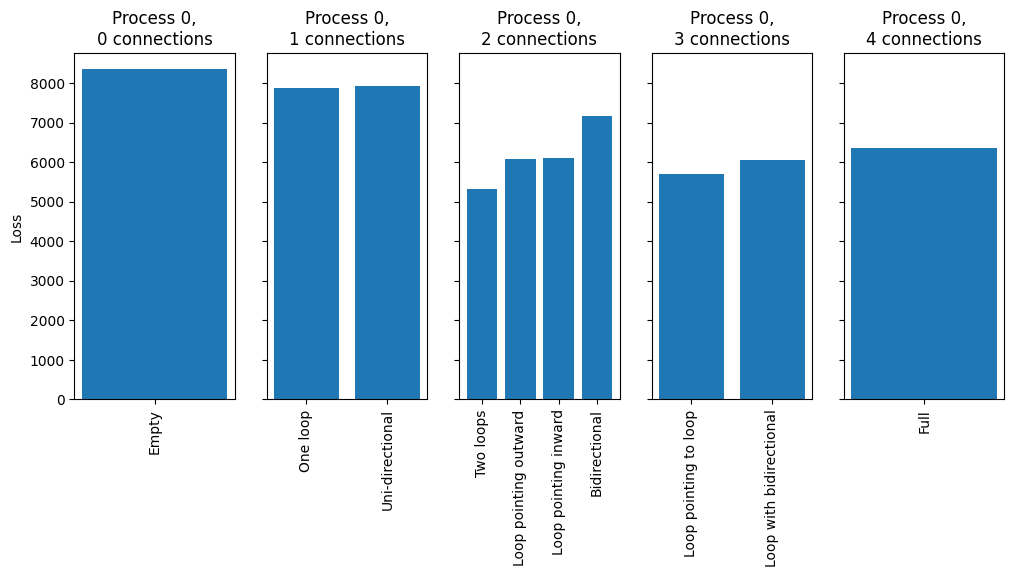

[{0: {'Empty': 8343.496201540267},
  1: {'One loop': 7861.058678917197, 'Uni-directional': 7918.34129913052},
  2: {'Two loops': 5309.118624784319,
   'Loop pointing outward': 6074.072250509873,
   'Loop pointing inward': 6101.551529907549,
   'Bidirectional': 7170.092375734242},
  3: {'Loop pointing to loop': 5687.0587563158715,
   'Loop with bidirectional': 6065.296987001685},
  4: {'Full': 6358.450303984644}}]

In [30]:
test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))),
           A=np.array([[0.8, 0.03], [-0.03, 0.95]]))

### Eigenvalues far apart

In [31]:
# proc = mk_nd_proc(rng, 2,
#                   A=np.array([[1, -0.1], [1.4, -0.3]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))))

Process dynamics: [[ 1.  -0.1]
 [ 1.4 -0.3]]
Eigenvalues: [ 0.88150729 -0.18150729]
Kalman filter M: [[ 0.47978222 -0.02417192]
 [ 0.68600942 -0.16400652]]
Kalman filter K: [[0.31191267 0.14878936]
 [0.14878936 0.40371516]]
Kalman filter loss: 5451.402645017801


  0%|                                                                   | 0/10 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[0.95404101 0.89907671]
 [0.85529451 1.23214061]]
NN W: [[ 0.7231824  -0.29939361]
 [-0.30851487  0.6749461 ]]
Loss: 7653.428174365943
Testing Empty, Trial 2
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.04021574 0.99982962]
 [0.72772958 1.10260672]]
NN W: [[ 0.66105755 -0.34844834]
 [-0.20869143  0.68572694]]
Loss: 7355.332961154525
Testing Empty, Trial 3


 10%|█████▉                                                     | 1/10 [01:15<11:19, 75.54s/it]

NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.06067457 1.00689196]
 [0.77718142 1.13805796]]
NN W: [[ 0.65930802 -0.33826505]
 [-0.24561464  0.70170097]]
Loss: 7315.076034671276
Testing One loop, Trial 1
NN M: [[0.40716987 0.        ]
 [0.         0.        ]]
NN K: [[0.60006377 0.56164204]
 [0.42113485 0.79094098]]
NN W: [[ 0.56521556 -0.20441707]
 [ 0.06068237  0.64793622]]
Loss: 6638.389867554835
Testing One loop, Trial 2
NN M: [[0.35236833 0.        ]
 [0.         0.        ]]
NN K: [[0.45913416 0.23974698]
 [0.74227518 1.11972767]]
NN W: [[ 0.79248982 -0.01455237]
 [-0.11171094  0.51975698]]
Loss: 6432.470903898803
Testing One loop, Trial 3


 20%|███████████▊                                               | 2/10 [02:29<09:56, 74.57s/it]

NN M: [[0.43093679 0.        ]
 [0.         0.        ]]
NN K: [[0.3883117  0.27691091]
 [0.45786084 0.81398158]]
NN W: [[ 0.81742755 -0.06751361]
 [ 0.15115174  0.58013076]]
Loss: 6640.92487252686
Testing Uni-directional, Trial 1
NN M: [[0.         0.41069086]
 [0.         0.        ]]
NN K: [[0.63695551 0.54422427]
 [0.52556878 0.8492279 ]]
NN W: [[ 0.67108662 -0.24827393]
 [ 0.02956819  0.60677203]]
Loss: 7018.925893721404
Testing Uni-directional, Trial 2
NN M: [[0.         0.45366233]
 [0.         0.        ]]
NN K: [[0.62172128 0.45146617]
 [0.47882043 0.77378357]]
NN W: [[ 0.63703451 -0.17308788]
 [ 0.02013564  0.68785912]]
Loss: 6442.857649537393
Testing Uni-directional, Trial 3


 30%|█████████████████▋                                         | 3/10 [03:43<08:39, 74.25s/it]

NN M: [[0.         0.18583528]
 [0.         0.        ]]
NN K: [[0.57000609 0.3818739 ]
 [0.77900386 1.09667377]]
NN W: [[ 0.74891207 -0.0920492 ]
 [-0.18861814  0.57679001]]
Loss: 6889.093824237003
Testing Two loops, Trial 1
NN M: [[0.47405612 0.        ]
 [0.         0.33983353]]
NN K: [[0.38423427 0.15402239]
 [0.33691419 0.59605866]]
NN W: [[0.83000476 0.00240625]
 [0.12656631 0.60747095]]
Loss: 5666.35824266702
Testing Two loops, Trial 2
NN M: [[0.43302712 0.        ]
 [0.         0.37682836]]
NN K: [[0.38881802 0.28587308]
 [0.33868317 0.4792359 ]]
NN W: [[ 0.68673798  0.02192979]
 [-0.02015495  0.77468222]]
Loss: 6183.590959938452
Testing Two loops, Trial 3


 40%|███████████████████████▌                                   | 4/10 [04:56<07:24, 74.01s/it]

NN M: [[0.38639425 0.        ]
 [0.         0.37715906]]
NN K: [[0.38870605 0.16411416]
 [0.28046538 0.40594782]]
NN W: [[ 0.76765863  0.14189503]
 [-0.13981844  1.00897774]]
Loss: 5778.3626730433925
Testing Loop pointing outward, Trial 1
NN M: [[0.38339022 0.        ]
 [0.45085257 0.        ]]
NN K: [[0.43896487 0.28119189]
 [0.27266147 0.53256699]]
NN W: [[ 0.84606837 -0.09985793]
 [-0.14842694  0.8724919 ]]
Loss: 5441.94400626188
Testing Loop pointing outward, Trial 2
NN M: [[0.39793683 0.        ]
 [0.39300959 0.        ]]
NN K: [[0.51150344 0.35464581]
 [0.28772267 0.55000199]]
NN W: [[ 0.77576189 -0.18371915]
 [-0.14368295  0.85395813]]
Loss: 5560.121741890992
Testing Loop pointing outward, Trial 3


 50%|█████████████████████████████▌                             | 5/10 [06:11<06:10, 74.05s/it]

NN M: [[0.38929033 0.        ]
 [0.61695631 0.        ]]
NN K: [[0.45272413 0.24699446]
 [0.44524062 0.66861255]]
NN W: [[ 0.77417046 -0.01817408]
 [-0.15313204  0.63927113]]
Loss: 5457.506658232071
Testing Loop pointing inward, Trial 1
NN M: [[0.         0.        ]
 [0.1715741  0.19759026]]
NN K: [[0.8347849  0.63468039]
 [0.26330813 0.45663241]]
NN W: [[ 0.53502531 -0.03877714]
 [ 0.00651476  0.80362939]]
Loss: 6765.06519581874
Testing Loop pointing inward, Trial 2
NN M: [[0.         0.        ]
 [0.29043472 0.14460193]]
NN K: [[0.70355603 0.53358922]
 [0.166426   0.48063687]]
NN W: [[ 0.63560609 -0.02251363]
 [ 0.06802041  0.76224575]]
Loss: 6771.046842332775
Testing Loop pointing inward, Trial 3


 60%|███████████████████████████████████▍                       | 6/10 [07:25<04:56, 74.11s/it]

NN M: [[0.         0.        ]
 [0.18430086 0.34083542]]
NN K: [[0.63586191 0.40294071]
 [0.56505727 0.60580616]]
NN W: [[ 0.68116234  0.03510296]
 [-0.10509917  0.53802466]]
Loss: 6699.266152993756
Testing Bidirectional, Trial 1
NN M: [[0.         0.41432682]
 [0.40130765 0.        ]]
NN K: [[0.5398845  0.38983709]
 [0.34325443 0.56735592]]
NN W: [[ 0.78135827 -0.24877353]
 [-0.11102561  0.75526576]]
Loss: 6061.790976019508
Testing Bidirectional, Trial 2
NN M: [[0.         0.35454946]
 [0.34436109 0.        ]]
NN K: [[0.44670678 0.24729338]
 [0.2252208  0.4318085 ]]
NN W: [[ 0.83811078 -0.04295846]
 [-0.04369027  1.01295896]]
Loss: 5566.534839828176
Testing Bidirectional, Trial 3


 70%|█████████████████████████████████████████▎                 | 7/10 [08:37<03:40, 73.61s/it]

NN M: [[0.         0.43524006]
 [0.39049675 0.        ]]
NN K: [[0.53179448 0.37239307]
 [0.32526512 0.53300844]]
NN W: [[ 0.79823827 -0.25733316]
 [-0.06346397  0.74823366]]
Loss: 5737.08529198941
Testing Loop pointing to loop, Trial 1
NN M: [[0.38425396 0.        ]
 [0.23171951 0.10485021]]
NN K: [[0.50218842 0.37257407]
 [0.1985624  0.46805887]]
NN W: [[ 0.81901948 -0.27487185]
 [ 0.16927253  0.67837179]]
Loss: 5852.605792855452
Testing Loop pointing to loop, Trial 2
NN M: [[0.28315905 0.        ]
 [0.29570649 0.32226001]]
NN K: [[0.41204963 0.0783011 ]
 [0.46882297 0.44007545]]
NN W: [[ 0.73483978  0.20436601]
 [-0.34439621  0.75301947]]
Loss: 5601.74211214953
Testing Loop pointing to loop, Trial 3


 80%|███████████████████████████████████████████████▏           | 8/10 [09:50<02:26, 73.32s/it]

NN M: [[0.35854989 0.        ]
 [0.41284291 0.09472687]]
NN K: [[0.3500758  0.18933981]
 [0.29191188 0.53724289]]
NN W: [[ 0.96433739  0.02549161]
 [-0.18605099  0.87007512]]
Loss: 5800.509977211952
Testing Loop with bidirectional, Trial 1
NN M: [[0.08721177 0.25782912]
 [0.41198529 0.        ]]
NN K: [[0.46588078 0.22535783]
 [0.34823733 0.54802337]]
NN W: [[ 0.78284186 -0.02582688]
 [-0.19247547  0.87837493]]
Loss: 5797.318297754533
Testing Loop with bidirectional, Trial 2
NN M: [[0.2351042  0.26239268]
 [0.55104069 0.        ]]
NN K: [[0.60785956 0.18346144]
 [0.41793461 0.51274529]]
NN W: [[ 0.60052958 -0.07850911]
 [-0.30068282  0.81528611]]
Loss: 5329.304381028531
Testing Loop with bidirectional, Trial 3


 90%|█████████████████████████████████████████████████████      | 9/10 [11:04<01:13, 73.37s/it]

NN M: [[0.20181346 0.21527217]
 [0.32456371 0.        ]]
NN K: [[0.36689366 0.25564595]
 [0.29542748 0.47815261]]
NN W: [[ 0.85958173 -0.07360055]
 [-0.03058324  0.90408564]]
Loss: 5614.0112925228
Testing Full, Trial 1
NN M: [[ 0.12191771  0.18452277]
 [-0.08635503  0.45098885]]
NN K: [[0.30605836 0.14334168]
 [0.20542669 0.37776328]]
NN W: [[0.95832315 0.16981163]
 [0.02681193 1.00909745]]
Loss: 5983.693635168263
Testing Full, Trial 2
NN M: [[0.31962968 0.08671289]
 [0.30244226 0.18399732]]
NN K: [[0.31457975 0.16693863]
 [0.2343038  0.31091015]]
NN W: [[ 0.98574492  0.01847624]
 [-0.03605088  1.04021622]]
Loss: 5973.886354941203
Testing Full, Trial 3


100%|██████████████████████████████████████████████████████████| 10/10 [12:26<00:00, 74.68s/it]

NN M: [[0.19423304 0.29040353]
 [0.3127216  0.0086094 ]]
NN K: [[0.3890077  0.2980432 ]
 [0.15086614 0.36061452]]
NN W: [[ 0.92282609 -0.27002291]
 [ 0.15292429  0.9132574 ]]
Loss: 5367.093228404883


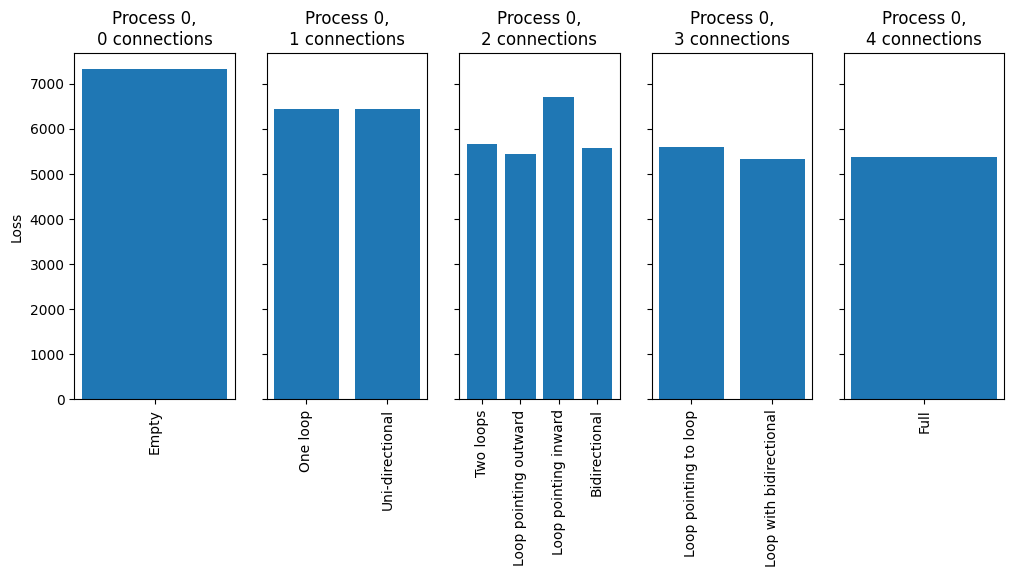

[{0: {'Empty': 7315.076034671276},
  1: {'One loop': 6432.470903898803, 'Uni-directional': 6442.857649537393},
  2: {'Two loops': 5666.35824266702,
   'Loop pointing outward': 5441.94400626188,
   'Loop pointing inward': 6699.266152993756,
   'Bidirectional': 5566.534839828176},
  3: {'Loop pointing to loop': 5601.74211214953,
   'Loop with bidirectional': 5329.304381028531},
  4: {'Full': 5367.093228404883}}]

In [32]:
test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))),
           A=np.array([[1, -0.1], [1.4, -0.3]]))

### Off-diagonal

In [33]:
# proc = mk_nd_proc(rng, 2,
#                   A=np.array([[0, 0.95], [0.8, 0]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))))

Process dynamics: [[0.   0.95]
 [0.8  0.  ]]
Eigenvalues: [ 0.87177979 -0.87177979]
Kalman filter M: [[0.         0.61670586]
 [0.54254392 0.        ]]
Kalman filter K: [[0.35083594 0.        ]
 [0.         0.3218201 ]]
Kalman filter loss: 5195.075241143937


  0%|                                                                   | 0/10 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.48905606 0.94799637]
 [0.71921208 1.17554428]]
NN W: [[ 0.56902127 -0.43034027]
 [-0.32841618  0.71084092]]
Loss: 8135.243809838144
Testing Empty, Trial 2
NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.42026595 0.86357885]
 [0.92019351 1.26531606]]
NN W: [[ 0.66313739 -0.43142388]
 [-0.44484584  0.71107028]]
Loss: 8206.878209542987
Testing Empty, Trial 3


 10%|█████▉                                                     | 1/10 [01:27<13:07, 87.52s/it]

NN M: [[0. 0.]
 [0. 0.]]
NN K: [[1.36492966 0.81970939]
 [0.9112903  1.25005438]]
NN W: [[ 0.68353799 -0.42762767]
 [-0.44611282  0.69426399]]
Loss: 7585.287922660558
Testing One loop, Trial 1
NN M: [[0.32687027 0.        ]
 [0.         0.        ]]
NN K: [[0.68207693 0.36629468]
 [0.55872543 1.28872709]]
NN W: [[ 0.88455487 -0.30831591]
 [-0.19051413  0.46248163]]
Loss: 8211.539274827237
Testing One loop, Trial 2
NN M: [[0.33562359 0.        ]
 [0.         0.        ]]
NN K: [[0.69952517 0.36426655]
 [0.58080971 1.29430519]]
NN W: [[ 0.85052733 -0.29362436]
 [-0.17730504  0.45147217]]
Loss: 7797.835697139354
Testing One loop, Trial 3


 20%|███████████▊                                               | 2/10 [02:50<11:17, 84.68s/it]

NN M: [[0.32004981 0.        ]
 [0.         0.        ]]
NN K: [[0.63424885 0.33899738]
 [0.56469599 1.31882561]]
NN W: [[ 0.9613776  -0.30003071]
 [-0.19398044  0.44416777]]
Loss: 7853.442660979386
Testing Uni-directional, Trial 1
NN M: [[0.         0.31910952]
 [0.         0.        ]]
NN K: [[0.76250164 0.28325215]
 [0.59014096 1.29685498]]
NN W: [[ 0.70518674 -0.19357657]
 [-0.19592197  0.45247151]]
Loss: 7740.16932118132
Testing Uni-directional, Trial 2
NN M: [[0.         0.30020331]
 [0.         0.        ]]
NN K: [[0.78477777 0.3653413 ]
 [0.60551055 1.26828616]]
NN W: [[ 0.73951959 -0.24947391]
 [-0.21555983  0.48385712]]
Loss: 7675.531158917205
Testing Uni-directional, Trial 3


 30%|█████████████████▋                                         | 3/10 [04:09<09:34, 82.07s/it]

NN M: [[0.         0.26331584]
 [0.         0.        ]]
NN K: [[0.81228424 0.40925337]
 [0.65123234 1.35011966]]
NN W: [[ 0.74999812 -0.26268681]
 [-0.23198595  0.4635278 ]]
Loss: 8453.160601456892
Testing Two loops, Trial 1
NN M: [[0.4430943  0.        ]
 [0.         0.42692834]]
NN K: [[0.71633284 0.31316187]
 [0.21046281 0.66722208]]
NN W: [[ 0.69900589 -0.28210163]
 [-0.17687295  0.74135988]]
Loss: 9673.243094887843
Testing Two loops, Trial 2
NN M: [[0.37787667 0.        ]
 [0.         0.45375517]]
NN K: [[0.6938545  0.18318818]
 [0.24573314 0.55891456]]
NN W: [[ 0.77374401 -0.16730998]
 [-0.26183096  0.81335456]]
Loss: 8895.872426420601
Testing Two loops, Trial 3


 40%|███████████████████████▌                                   | 4/10 [05:30<08:09, 81.65s/it]

NN M: [[0.45405505 0.        ]
 [0.         0.51721048]]
NN K: [[0.69824123 0.2628648 ]
 [0.25516932 0.6038356 ]]
NN W: [[ 0.72111209 -0.23121138]
 [-0.24825049  0.71821543]]
Loss: 8666.141589692543
Testing Loop pointing outward, Trial 1
NN M: [[0.58796589 0.        ]
 [0.47535202 0.        ]]
NN K: [[0.71298384 0.31491342]
 [0.08559369 0.56442266]]
NN W: [[ 0.6938827  -0.4789704 ]
 [-0.22644062  0.76639663]]
Loss: 6669.2444048061425
Testing Loop pointing outward, Trial 2
NN M: [[0.62681124 0.        ]
 [0.42591088 0.        ]]
NN K: [[0.85835093 0.39013506]
 [0.16558489 0.5973086 ]]
NN W: [[ 0.58592317 -0.50914467]
 [-0.27544805  0.80215448]]
Loss: 6312.723244532717
Testing Loop pointing outward, Trial 3


 50%|█████████████████████████████▌                             | 5/10 [06:53<06:51, 82.26s/it]

NN M: [[0.5917145  0.        ]
 [0.46372086 0.        ]]
NN K: [[0.76736053 0.34260852]
 [0.13051127 0.56852231]]
NN W: [[ 0.67058155 -0.49119022]
 [-0.26571238  0.79836039]]
Loss: 6809.997000090494
Testing Loop pointing inward, Trial 1
NN M: [[0.         0.        ]
 [0.3146366  0.19685497]]
NN K: [[1.23735552 0.31409505]
 [0.23215063 0.55066584]]
NN W: [[ 0.4729992  -0.05342395]
 [-0.20028762  0.70594156]]
Loss: 7576.007594176223
Testing Loop pointing inward, Trial 2
NN M: [[0.         0.        ]
 [0.22884795 0.07744563]]
NN K: [[1.3883587  0.51424419]
 [0.2551284  0.5656188 ]]
NN W: [[ 0.43351258 -0.16538271]
 [-0.19288395  0.83891627]]
Loss: 7195.761243030121
Testing Loop pointing inward, Trial 3


 60%|███████████████████████████████████▍                       | 6/10 [08:37<05:59, 89.78s/it]

NN M: [[0.         0.        ]
 [0.31874374 0.13841624]]
NN K: [[1.25794783 0.39605498]
 [0.31364718 0.61699875]]
NN W: [[ 0.48215968 -0.09349058]
 [-0.23104352  0.69698615]]
Loss: 7605.761637880758
Testing Bidirectional, Trial 1
NN M: [[0.         0.58386367]
 [0.58690811 0.        ]]
NN K: [[0.5148019  0.12127817]
 [0.14356398 0.47204139]]
NN W: [[ 0.75731839 -0.17145297]
 [-0.18028157  0.72856569]]
Loss: 5487.779808683567
Testing Bidirectional, Trial 2
NN M: [[0.         0.56039612]
 [0.58162812 0.        ]]
NN K: [[0.45010572 0.10243334]
 [0.11984434 0.43005619]]
NN W: [[ 0.87694334 -0.17891133]
 [-0.18879869  0.8204487 ]]
Loss: 5189.390616245471
Testing Bidirectional, Trial 3


 70%|█████████████████████████████████████████▎                 | 7/10 [10:23<04:44, 94.82s/it]

NN M: [[0.         0.68965622]
 [0.48539909 0.        ]]
NN K: [[0.65960832 0.19265722]
 [0.13712255 0.51588181]]
NN W: [[ 0.5992307  -0.18207046]
 [-0.13548115  0.68823609]]
Loss: 5174.781003116521
Testing Loop pointing to loop, Trial 1
NN M: [[0.52119005 0.        ]
 [0.43259317 0.00727994]]
NN K: [[0.79013087 0.2511931 ]
 [0.20090335 0.53062553]]
NN W: [[ 0.6702332  -0.35818482]
 [-0.30563907  0.89193353]]
Loss: 7120.717679125145
Testing Loop pointing to loop, Trial 2
NN M: [[0.54682635 0.        ]
 [0.45494195 0.021866  ]]
NN K: [[0.76262529 0.26163608]
 [0.19263851 0.55470722]]
NN W: [[ 0.70516978 -0.40719819]
 [-0.3102269   0.84675236]]
Loss: 6469.843439226477
Testing Loop pointing to loop, Trial 3


 80%|███████████████████████████████████████████████▏           | 8/10 [11:59<03:10, 95.17s/it]

NN M: [[ 0.5593566   0.        ]
 [ 0.50019337 -0.02270272]]
NN K: [[0.65659037 0.24829764]
 [0.11861318 0.55013293]]
NN W: [[ 0.76394579 -0.42603425]
 [-0.25634405  0.81946725]]
Loss: 6322.078094947166
Testing Loop with bidirectional, Trial 1
NN M: [[0.27290327 0.45109076]
 [0.48421736 0.        ]]
NN K: [[0.61955253 0.36188908]
 [0.12985659 0.59840418]]
NN W: [[ 0.76586622 -0.54805495]
 [-0.26769986  0.77368309]]
Loss: 5794.603272137537
Testing Loop with bidirectional, Trial 2
NN M: [[0.20379356 0.52722245]
 [0.47479569 0.        ]]
NN K: [[0.62637048 0.36102228]
 [0.16430038 0.58655577]]
NN W: [[ 0.75648383 -0.52631696]
 [-0.28928244  0.80510087]]
Loss: 5512.360390526481
Testing Loop with bidirectional, Trial 3


 90%|█████████████████████████████████████████████████████      | 9/10 [13:36<01:36, 96.02s/it]

NN M: [[0.28352144 0.36392426]
 [0.52251224 0.        ]]
NN K: [[0.59657807 0.25637506]
 [0.12281949 0.57071588]]
NN W: [[ 0.80766901 -0.45082391]
 [-0.27074891  0.78876485]]
Loss: 5618.72317988912
Testing Full, Trial 1
NN M: [[0.18601141 0.44271374]
 [0.39913652 0.10160872]]
NN K: [[0.59820913 0.19126069]
 [0.14541369 0.51124109]]
NN W: [[ 0.84197375 -0.41103404]
 [-0.30013887  0.90415669]]
Loss: 5489.995479704024
Testing Full, Trial 2
NN M: [[0.02094286 0.41456477]
 [0.32477547 0.29353755]]
NN K: [[0.53585232 0.0257156 ]
 [0.14957997 0.54583544]]
NN W: [[ 0.89333984 -0.12944084]
 [-0.30358114  0.77866707]]
Loss: 5698.318666272357
Testing Full, Trial 3


100%|██████████████████████████████████████████████████████████| 10/10 [15:14<00:00, 91.42s/it]

NN M: [[0.04025279 0.46359361]
 [0.44544965 0.21924531]]
NN K: [[0.64012554 0.14763824]
 [0.27588674 0.59752861]]
NN W: [[ 0.80527354 -0.27795038]
 [-0.37741333  0.70708257]]
Loss: 5565.93515241579


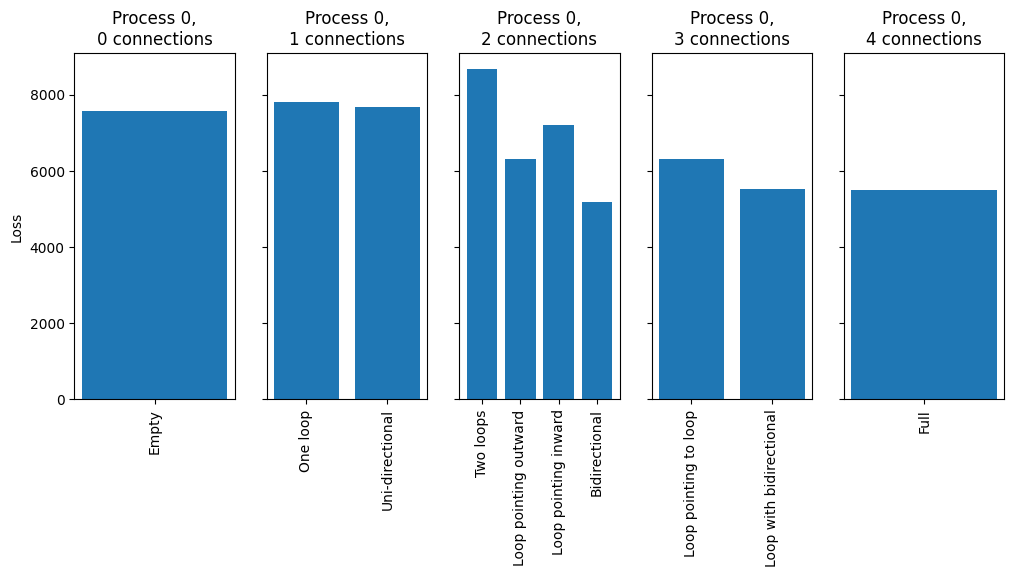

[{0: {'Empty': 7585.287922660558},
  1: {'One loop': 7797.835697139354, 'Uni-directional': 7675.531158917205},
  2: {'Two loops': 8666.141589692543,
   'Loop pointing outward': 6312.723244532717,
   'Loop pointing inward': 7195.761243030121,
   'Bidirectional': 5174.781003116521},
  3: {'Loop pointing to loop': 6322.078094947166,
   'Loop with bidirectional': 5512.360390526481},
  4: {'Full': 5489.995479704024}}]

In [34]:
test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))),
           A=np.array([[0, 0.95], [0.8, 0]]))

### Rotational

In [35]:
# proc = mk_nd_proc(rng, 2,
#                   A=np.array([[0.5, 0.8],[-0.8, 0.5]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 1e-6), np.full(20, 5e-7), np.full(20, 5e-8))))

Process dynamics: [[ 0.5  0.8]
 [-0.8  0.5]]
Eigenvalues: [0.5+0.8j 0.5-0.8j]
Kalman filter M: [[ 0.31748527  0.50797643]
 [-0.50797643  0.31748527]]
Kalman filter K: [[ 3.65029463e-01  0.00000000e+00]
 [-2.46169098e-18  3.65029463e-01]]
Kalman filter loss: 5197.752645564568


  0%|                                                                   | 0/10 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[ 0.  0.]
 [-0.  0.]]
NN K: [[0.92346527 0.01294824]
 [0.03302244 0.94006685]]
NN W: [[ 0.90389539 -0.01797219]
 [-0.03862831  0.87869282]]
Loss: 10918.676924593794
Testing Empty, Trial 2
NN M: [[ 0.  0.]
 [-0.  0.]]
NN K: [[ 8.86167723e-01  7.01040525e-04]
 [-4.62607566e-03  8.25106389e-01]]
NN W: [[ 0.93961649 -0.00245221]
 [-0.00212448  1.00939094]]
Loss: 11642.575511549196
Testing Empty, Trial 3


 10%|█████▉                                                     | 1/10 [01:23<12:30, 83.33s/it]

NN M: [[0. 0.]
 [0. 0.]]
NN K: [[ 0.90069376  0.03879422]
 [-0.04081514  0.85587222]]
NN W: [[ 0.92183955 -0.04694198]
 [ 0.03990776  0.96928047]]
Loss: 11539.439897091523
Testing One loop, Trial 1
NN M: [[0.31996734 0.        ]
 [0.         0.        ]]
NN K: [[0.72330388 0.31065988]
 [0.15559377 0.79584507]]
NN W: [[ 0.97598094 -0.13355462]
 [-0.21679942  1.07544048]]
Loss: 10444.647919034307
Testing One loop, Trial 2
NN M: [[0.41984949 0.        ]
 [0.         0.        ]]
NN K: [[ 0.58998218  0.63203368]
 [-0.01856049  0.86597256]]
NN W: [[ 0.90368517 -0.43671938]
 [-0.03292607  0.97256412]]
Loss: 10048.270282463454
Testing One loop, Trial 3


 20%|███████████▊                                               | 2/10 [02:44<10:55, 81.99s/it]

NN M: [[0.34926525 0.        ]
 [0.         0.        ]]
NN K: [[0.74451966 0.53895014]
 [0.08561586 0.86030647]]
NN W: [[ 0.87315593 -0.33936394]
 [-0.123832    1.01327877]]
Loss: 9636.08681430347
Testing Uni-directional, Trial 1
NN M: [[0.         0.48873947]
 [0.         0.        ]]
NN K: [[ 0.54251805 -0.19512078]
 [ 0.08875778  0.72946715]]
NN W: [[ 1.01349607  0.09698703]
 [-0.09202417  1.13197663]]
Loss: 10412.480571867522
Testing Uni-directional, Trial 2
NN M: [[0.         0.53399541]
 [0.         0.        ]]
NN K: [[ 0.47454113 -0.17325103]
 [ 0.05123372  0.7687681 ]]
NN W: [[ 1.05955558  0.0103045 ]
 [-0.02846054  1.0797972 ]]
Loss: 10262.578748085813
Testing Uni-directional, Trial 3


 30%|█████████████████▋                                         | 3/10 [04:08<09:41, 83.11s/it]

NN M: [[ 0.          0.42570632]
 [-0.          0.        ]]
NN K: [[ 0.55828358 -0.22758422]
 [ 0.0380943   0.88913742]]
NN W: [[ 0.99840478  0.0822866 ]
 [-0.0106685   0.93057151]]
Loss: 10057.154729238635
Testing Two loops, Trial 1
NN M: [[0.35544201 0.        ]
 [0.         0.19095977]]
NN K: [[ 0.72977758  0.42965713]
 [-0.08329648  0.83011922]]
NN W: [[ 0.89672935 -0.1905624 ]
 [-0.09725212  0.95480705]]
Loss: 10176.040910502237
Testing Two loops, Trial 2
NN M: [[0.2844402  0.        ]
 [0.         0.25955463]]
NN K: [[ 0.71431089  0.28660567]
 [-0.30385152  0.84153981]]
NN W: [[ 0.97714574 -0.09047192]
 [ 0.08696926  0.84075234]]
Loss: 10812.093793484042
Testing Two loops, Trial 3


 40%|███████████████████████▌                                   | 4/10 [05:37<08:30, 85.16s/it]

NN M: [[0.33243271 0.        ]
 [0.         0.28175692]]
NN K: [[ 0.63623065  0.37552147]
 [-0.34088661  0.73657039]]
NN W: [[ 0.99403163 -0.1907655 ]
 [ 0.14329387  0.91185905]]
Loss: 10688.064552923655
Testing Loop pointing outward, Trial 1
NN M: [[ 0.31340766  0.        ]
 [-0.41995069  0.        ]]
NN K: [[0.64257524 0.17853915]
 [0.16158108 0.57315346]]
NN W: [[ 1.12014398  0.0159701 ]
 [-0.03699792  1.02899144]]
Loss: 9483.647154873848
Testing Loop pointing outward, Trial 2
NN M: [[ 0.28368033  0.        ]
 [-0.38525703  0.        ]]
NN K: [[0.60912215 0.24232467]
 [0.17937411 0.52379291]]
NN W: [[ 1.16994995 -0.15993113]
 [-0.04627637  1.17392371]]
Loss: 9000.384087094146
Testing Loop pointing outward, Trial 3


 50%|█████████████████████████████▌                             | 5/10 [07:07<07:16, 87.21s/it]

NN M: [[ 0.30318624  0.        ]
 [-0.38166858  0.        ]]
NN K: [[0.62714981 0.28255107]
 [0.13807106 0.50707358]]
NN W: [[ 1.09602063 -0.18551756]
 [ 0.03086702  1.18250548]]
Loss: 9564.483395597814
Testing Loop pointing inward, Trial 1
NN M: [[ 0.          0.        ]
 [-0.47918068  0.24372856]]
NN K: [[ 0.77082303 -0.08923837]
 [ 0.00626153  0.46132918]]
NN W: [[ 1.08526714  0.11288549]
 [-0.02770861  0.98705937]]
Loss: 9535.7607845905
Testing Loop pointing inward, Trial 2
NN M: [[ 0.          0.        ]
 [-0.4033385   0.20990078]]
NN K: [[ 0.90928045 -0.108653  ]
 [ 0.04916403  0.47498268]]
NN W: [[ 0.90738757  0.1079068 ]
 [-0.05134316  1.00127333]]
Loss: 9518.508602142618
Testing Loop pointing inward, Trial 3


 60%|███████████████████████████████████▍                       | 6/10 [08:38<05:53, 88.40s/it]

NN M: [[ 0.          0.        ]
 [-0.3127947   0.20014745]]
NN K: [[ 0.88627357 -0.11333834]
 [ 0.00611608  0.53897552]]
NN W: [[ 0.94352813  0.12567369]
 [-0.03672176  1.02905664]]
Loss: 9344.984979608638
Testing Bidirectional, Trial 1
NN M: [[ 0.          0.43998958]
 [-0.31883124  0.        ]]
NN K: [[ 0.5527939  -0.19072836]
 [ 0.11795447  0.62567677]]
NN W: [[ 1.03593271 -0.01652997]
 [ 0.05152854  1.03803494]]
Loss: 8120.2249745982
Testing Bidirectional, Trial 2
NN M: [[ 0.          0.41737706]
 [-0.37738096  0.        ]]
NN K: [[ 0.54837597 -0.1174113 ]
 [ 0.0904807   0.55056618]]
NN W: [[ 1.08456016 -0.12895892]
 [ 0.14504606  1.10832159]]
Loss: 8201.43483568218
Testing Bidirectional, Trial 3


 70%|█████████████████████████████████████████▎                 | 7/10 [10:13<04:31, 90.61s/it]

NN M: [[ 0.          0.46752522]
 [-0.3834838   0.        ]]
NN K: [[ 0.5250942  -0.29255703]
 [ 0.29677099  0.49473657]]
NN W: [[ 0.98502213  0.18003408]
 [-0.19099787  1.05871226]]
Loss: 8169.007350503589
Testing Loop pointing to loop, Trial 1
NN M: [[ 0.35087846  0.        ]
 [-0.37486776  0.31829069]]
NN K: [[ 0.71901108  0.33959578]
 [-0.17472304  0.52046888]]
NN W: [[ 0.91222916 -0.0709721 ]
 [ 0.11815277  0.89462938]]
Loss: 8430.444273653166
Testing Loop pointing to loop, Trial 2
NN M: [[ 0.36726341  0.        ]
 [-0.39273887  0.2841226 ]]
NN K: [[ 0.60205078  0.41389269]
 [-0.21531896  0.52431802]]
NN W: [[ 0.97010152 -0.20434016]
 [ 0.24815195  0.89427269]]
Loss: 8650.77802124002
Testing Loop pointing to loop, Trial 3


 80%|███████████████████████████████████████████████▏           | 8/10 [11:47<03:03, 91.62s/it]

NN M: [[ 0.31821887  0.        ]
 [-0.38463747  0.25985743]]
NN K: [[ 0.7026773   0.3419475 ]
 [-0.04965202  0.50411004]]
NN W: [[ 0.94065722 -0.13661528]
 [ 0.06850574  0.98974336]]
Loss: 8810.311979548624
Testing Loop with bidirectional, Trial 1
NN M: [[ 0.32657839  0.46172046]
 [-0.4148979   0.        ]]
NN K: [[ 0.39737956 -0.02646305]
 [ 0.18602021  0.49345591]]
NN W: [[ 1.07214004  0.08688376]
 [-0.05989725  1.10200804]]
Loss: 6570.090646853585
Testing Loop with bidirectional, Trial 2
NN M: [[ 0.39709243  0.448962  ]
 [-0.49879643  0.        ]]
NN K: [[ 0.49654896 -0.01035551]
 [ 0.11830619  0.41779374]]
NN W: [[0.9465327  0.11940375]
 [0.07724042 1.06977929]]
Loss: 6592.224173083698
Testing Loop with bidirectional, Trial 3


 90%|█████████████████████████████████████████████████████      | 9/10 [13:21<01:32, 92.43s/it]

NN M: [[ 0.3680272   0.40778411]
 [-0.40466084  0.        ]]
NN K: [[0.46164701 0.06096428]
 [0.1256159  0.54122594]]
NN W: [[0.99432042 0.00471256]
 [0.03957401 1.0483305 ]]
Loss: 6565.013006556148
Testing Full, Trial 1
NN M: [[ 0.29090298  0.46880192]
 [-0.34899869  0.33063973]]
NN K: [[ 0.3641542   0.17941139]
 [-0.26049412  0.44163344]]
NN W: [[ 0.92526395 -0.38427451]
 [ 0.3317815   0.9193335 ]]
Loss: 5519.315183974506
Testing Full, Trial 2
NN M: [[ 0.28997597  0.39196267]
 [-0.43811094  0.32540918]]
NN K: [[ 0.45776036  0.06692575]
 [-0.06859442  0.44183236]]
NN W: [[ 1.00110851 -0.06376247]
 [ 0.04898263  0.97405661]]
Loss: 5806.1781545016
Testing Full, Trial 3


100%|██████████████████████████████████████████████████████████| 10/10 [15:43<00:00, 94.31s/it]

NN M: [[ 0.27328871  0.46482901]
 [-0.40668817  0.29257523]]
NN K: [[ 0.36375988 -0.09229703]
 [ 0.0204476   0.45137193]]
NN W: [[ 1.09804204  0.17111391]
 [-0.14446804  1.01876029]]
Loss: 5819.147305242952


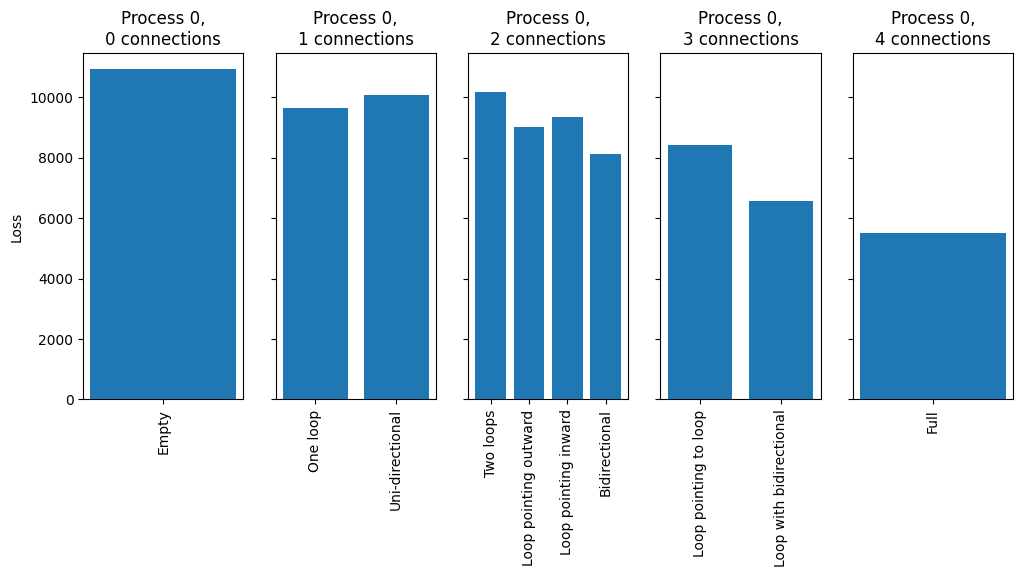

[{0: {'Empty': 10918.676924593794},
  1: {'One loop': 9636.08681430347, 'Uni-directional': 10057.154729238635},
  2: {'Two loops': 10176.040910502237,
   'Loop pointing outward': 9000.384087094146,
   'Loop pointing inward': 9344.984979608638,
   'Bidirectional': 8120.2249745982},
  3: {'Loop pointing to loop': 8430.444273653166,
   'Loop with bidirectional': 6565.013006556148},
  4: {'Full': 5519.315183974506}}]

In [36]:
test_masks(rng, 2, masks_two_neurons, np.concatenate((np.full(15, 1e-5), np.full(15, 1e-6), np.full(20, 5e-7), np.full(20, 5e-8))),
           A=np.array([[0.5, 0.8],[-0.8, 0.5]]))

## Three neurons

### Fully connected, three distinct eigenvalues

In [63]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0.3, -0.3, -0.9], [-0.1, 0.9, -0.1], [0.2, 0.1, 1.2]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 1e-6), np.full(50, 5e-7), np.full(40, 1e-7))))

Process dynamics: [[ 0.3 -0.3 -0.9]
 [-0.1  0.9 -0.1]
 [ 0.2  0.1  1.2]]
Eigenvalues: [0.54384472 0.9        0.95615528]
Kalman filter M: [[ 0.21456445 -0.14178882 -0.38083142]
 [-0.05114364  0.57434273 -0.07343981]
 [ 0.16588759  0.03080532  0.58988455]]
Kalman filter K: [[ 0.37595227 -0.0334215  -0.15346141]
 [-0.0334215   0.35267976 -0.01780964]
 [-0.15346141 -0.01780964  0.39184935]]
Kalman filter loss: 8043.536554581066


  0%|                                                                   | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.32975879 0.         0.        ]
 [0.         0.27208199 0.        ]
 [0.         0.         0.29001389]]
NN K: [[ 0.35713837 -0.42128562 -0.33711842]
 [ 0.20634277  0.38427828 -0.33404118]
 [-0.28610404  0.190478    0.67352419]]
NN W: [[ 0.72754793  0.48063491 -0.02467495]
 [-0.39757381  1.02424438  0.29641386]
 [ 0.30086356 -0.20845638  0.78371392]]
Loss: 10644.01244317627
Testing Empty, Trial 2
NN M: [[0.18218466 0.         0.        ]
 [0.         0.20944482 0.        ]
 [0.         0.         0.29950548]]
NN K: [[ 0.48858323 -0.1426694  -0.27667535]
 [ 0.06851374  0.50379509 -0.30222246]
 [-0.28658112  0.08975449  0.73264156]]
NN W: [[ 1.09531237  0.0418931  -0.02965411]
 [-0.28956112  1.12889874  0.1991741 ]
 [ 0.17526082 -0.17840667  0.67716687]]
Loss: 11355.44231268114
Testing Empty, Trial 3


  6%|███▋                                                      | 1/16 [02:43<40:55, 163.72s/it]

NN M: [[0.26346561 0.         0.        ]
 [0.         0.21115611 0.        ]
 [0.         0.         0.29624593]]
NN K: [[ 0.41762762 -0.26097922 -0.33704877]
 [ 0.08212436  0.51221444 -0.12719347]
 [-0.270327    0.02593084  0.65337793]]
NN W: [[ 0.89780991  0.18512931 -0.11519264]
 [-0.31601709  1.12784703  0.01615384]
 [ 0.19130369 -0.07744535  0.82364681]]
Loss: 10671.196863087822
Testing Unidirectional, Trial 1
NN M: [[ 0.29825565  0.          0.        ]
 [ 0.24128624 -0.02118486  0.        ]
 [ 0.          0.          0.26725982]]
NN K: [[ 0.44711235  0.03098352 -0.27817351]
 [ 0.04531922  0.59139989 -0.44977147]
 [-0.33137262  0.11665513  0.74171656]]
NN W: [[ 0.99596972 -0.24977538 -0.17657708]
 [-0.19330491  1.13414193  0.48296373]
 [ 0.29362708 -0.18514922  0.70653058]]
Loss: 13280.202086636908
Testing Unidirectional, Trial 2
NN M: [[0.29422643 0.         0.        ]
 [0.22146792 0.09635413 0.        ]
 [0.         0.         0.25312185]]
NN K: [[ 0.46321005 -0.19435677 -0.2

 12%|███████▎                                                  | 2/16 [05:27<38:16, 164.03s/it]

NN M: [[0.33329523 0.         0.        ]
 [0.17583108 0.05739997 0.        ]
 [0.         0.         0.29711303]]
NN K: [[ 0.47256419 -0.1494851  -0.28013836]
 [ 0.19224062  0.60295364 -0.39436911]
 [-0.56385217  0.09915119  0.7833025 ]]
NN W: [[ 0.75456701  0.01721781 -0.11743844]
 [-0.32499825  1.03208767  0.30349706]
 [ 0.41421062 -0.10445352  0.64030521]]
Loss: 11373.074547381604
Testing Source, Trial 1
NN M: [[0.26148809 0.         0.        ]
 [0.13982106 0.09399519 0.        ]
 [0.06830279 0.         0.25798367]]
NN K: [[ 0.45370022 -0.02425469 -0.22618454]
 [-0.01456466  0.5603566  -0.26226163]
 [-0.37187928  0.00354277  0.63577417]]
NN W: [[ 1.0277949  -0.1521341  -0.16764789]
 [-0.28419894  1.22835391  0.21850018]
 [ 0.254932   -0.08374349  0.84583392]]
Loss: 12239.929297581908
Testing Source, Trial 2
NN M: [[0.30719705 0.         0.        ]
 [0.17073478 0.19998736 0.        ]
 [0.05036896 0.         0.2935562 ]]
NN K: [[ 0.42114922 -0.01115288 -0.33359578]
 [-0.24935892  0

 19%|██████████▉                                               | 3/16 [08:06<34:57, 161.38s/it]

NN M: [[ 0.31515793  0.          0.        ]
 [ 0.19898164 -0.00299411  0.        ]
 [ 0.08382605  0.          0.32167097]]
NN K: [[ 0.41664929 -0.1006161  -0.37090934]
 [ 0.0099233   0.57955647 -0.28891164]
 [-0.39938602 -0.01835418  0.84454262]]
NN W: [[ 0.93141556 -0.10644978 -0.06021887]
 [-0.38249712  1.21347846  0.16059634]
 [ 0.20708305  0.04437058  0.66401658]]
Loss: 13531.419857755813
Testing Bidirectional, Trial 1
NN M: [[0.22145823 0.06986292 0.        ]
 [0.12960487 0.13288058 0.        ]
 [0.         0.         0.2885321 ]]
NN K: [[ 0.38613812 -0.22199056 -0.25424184]
 [ 0.2058922   0.55120155 -0.4260569 ]
 [-0.38394847  0.1259068   0.73954301]]
NN W: [[ 0.9533312   0.11272107 -0.10955646]
 [-0.44633047  1.0342349   0.35293748]
 [ 0.17717737 -0.2230227   0.52881346]]
Loss: 11435.795195672763
Testing Bidirectional, Trial 2
NN M: [[ 0.19882568  0.06678428  0.        ]
 [ 0.25867475 -0.01621333  0.        ]
 [ 0.          0.          0.26859017]]
NN K: [[ 0.44426819 -0.216808

 25%|██████████████▌                                           | 4/16 [11:11<34:07, 170.65s/it]

NN M: [[ 0.35508543 -0.1603281   0.        ]
 [ 0.24824882 -0.02629178  0.        ]
 [ 0.          0.          0.32459704]]
NN K: [[ 0.48484893 -0.0539289  -0.30052021]
 [ 0.10145232  0.61903177 -0.33721482]
 [-0.3875723   0.05048165  0.79822649]]
NN W: [[ 0.78539263 -0.0109505  -0.15427297]
 [-0.41336436  1.09417645  0.23840072]
 [ 0.3367562  -0.0200224   0.69672255]]
Loss: 12527.937134743168
Testing Linear, Trial 1
NN M: [[0.19691898 0.         0.        ]
 [0.02372514 0.22342529 0.        ]
 [0.         0.1333464  0.27212755]]
NN K: [[ 0.43567834 -0.32875922 -0.23044922]
 [ 0.20382509  0.49311432 -0.32178722]
 [-0.36843206  0.09210705  0.58088042]]
NN W: [[ 0.9868004   0.38069313 -0.00951206]
 [-0.52217038  0.90229704  0.19674763]
 [ 0.16744343 -0.298158    0.66993176]]
Loss: 10862.539308191766
Testing Linear, Trial 2
NN M: [[0.228775   0.         0.        ]
 [0.09575252 0.10548023 0.        ]
 [0.         0.13327586 0.33401736]]
NN K: [[ 0.43974024  0.08443445 -0.18940413]
 [ 0.01

 31%|██████████████████▏                                       | 5/16 [14:14<32:09, 175.41s/it]

NN M: [[ 0.22915081  0.          0.        ]
 [ 0.18507236  0.06259122  0.        ]
 [ 0.         -0.11698386  0.33136577]]
NN K: [[ 0.36810651 -0.05112434 -0.09282411]
 [ 0.292569    0.47473044 -0.48924374]
 [-0.56238276  0.35572102  0.70386207]]
NN W: [[ 0.99236372  0.07162054 -0.20898198]
 [-0.08656819  1.06324224  0.51424406]
 [ 0.39942987 -0.39501129  0.34014033]]
Loss: 11957.570765196991
Testing Sink, Trial 1
NN M: [[ 0.23492943  0.          0.        ]
 [ 0.0483649   0.08598883 -0.14895399]
 [ 0.          0.          0.26673575]]
NN K: [[ 0.47334019 -0.21197669 -0.25162669]
 [ 0.10000159  0.55212199 -0.33365   ]
 [-0.16733475  0.10578765  0.54571118]]
NN W: [[ 0.94901916  0.17757871 -0.08398353]
 [-0.44993333  1.03336078  0.3363162 ]
 [ 0.02195446 -0.33096667  0.72733443]]
Loss: 11263.388832304645
Testing Sink, Trial 2
NN M: [[ 0.24253799  0.          0.        ]
 [ 0.02314621  0.02664794 -0.14278326]
 [ 0.          0.          0.22637819]]
NN K: [[ 0.49817139 -0.16859655 -0.225

 38%|█████████████████████▊                                    | 6/16 [16:52<28:13, 169.31s/it]

NN M: [[ 0.17632541  0.          0.        ]
 [ 0.04135517  0.23430196 -0.08269282]
 [ 0.          0.          0.26552122]]
NN K: [[ 0.48043286 -0.23430957 -0.17038866]
 [ 0.1550101   0.55847293 -0.44398159]
 [-0.23352996  0.12981517  0.60311518]]
NN W: [[ 1.05826379  0.23581768 -0.02273844]
 [-0.54630496  0.81418303  0.31147657]
 [ 0.16536149 -0.21671597  0.72984516]]
Loss: 11356.379658641988
Testing Bidirectional out, Trial 1
NN M: [[0.10579118 0.22769711 0.        ]
 [0.06537977 0.18338414 0.        ]
 [0.13990333 0.         0.23947549]]
NN K: [[ 0.35729045 -0.17831291 -0.20409385]
 [ 0.21366804  0.47349667 -0.49961641]
 [-0.34591292  0.22355202  0.61158399]]
NN W: [[ 1.22053575 -0.07610585 -0.13638312]
 [-0.48007588  1.04438729  0.55984842]
 [ 0.18553534 -0.34579211  0.62535681]]
Loss: 12123.187381146185
Testing Bidirectional out, Trial 2
NN M: [[ 0.24606529 -0.01826314  0.        ]
 [ 0.11554775  0.13432981  0.        ]
 [ 0.06469629  0.          0.30947224]]
NN K: [[ 0.48700637 -

 44%|█████████████████████████▍                                | 7/16 [19:03<23:32, 156.91s/it]

NN M: [[0.11878194 0.14845222 0.        ]
 [0.06743837 0.20125855 0.        ]
 [0.14418297 0.         0.32909335]]
NN K: [[ 0.42395294 -0.31993926 -0.1479339 ]
 [ 0.39736187  0.42370722 -0.60186695]
 [-0.39535038  0.35438433  0.54417566]]
NN W: [[ 0.91830845  0.25211818  0.01234014]
 [-0.52066562  0.77616257  0.52362884]
 [ 0.35656406 -0.4057776   0.51792739]]
Loss: 11770.107161522465
Testing Transitive triangle, Trial 1
NN M: [[ 0.26032023  0.          0.        ]
 [ 0.31850848 -0.00061832  0.        ]
 [-0.05651955  0.21420766  0.2826683 ]]
NN K: [[ 0.34251162  0.12534142 -0.21692474]
 [-0.14016973  0.48622593 -0.43086313]
 [-0.68742063  0.11162982  0.98338696]]
NN W: [[ 1.12804074 -0.40361985 -0.20201499]
 [ 0.13203024  1.120036    0.31576611]
 [ 0.12256827 -0.27147123  0.33579962]]
Loss: 12473.825525832066
Testing Transitive triangle, Trial 2
NN M: [[ 0.33283635  0.          0.        ]
 [ 0.11490154  0.17173481  0.        ]
 [-0.13841874  0.07486676  0.23599061]]
NN K: [[ 0.336312

 50%|█████████████████████████████                             | 8/16 [21:15<19:50, 148.84s/it]

NN M: [[ 0.27505962  0.          0.        ]
 [ 0.24921014 -0.04350809  0.        ]
 [ 0.05485899  0.15427845  0.33648443]]
NN K: [[ 0.41360547 -0.19751827 -0.20500555]
 [ 0.29287332  0.56129225 -0.28109366]
 [-0.69042276  0.04283032  0.8087698 ]]
NN W: [[ 0.81101104  0.00635414 -0.17572539]
 [-0.56462077  1.02813799  0.22356187]
 [ 0.40900205 -0.07919897  0.55359139]]
Loss: 14065.853285723924
Testing Bidirectional in, Trial 1
NN M: [[ 0.10699748  0.13153553 -0.07797516]
 [ 0.33100934 -0.1099881   0.        ]
 [ 0.          0.          0.31555182]]
NN K: [[ 0.44243168  0.04399046 -0.20369903]
 [ 0.15972066  0.48309239 -0.48119834]
 [-0.47824306  0.31754264  0.63768868]]
NN W: [[ 0.83682789 -0.09422238 -0.24218204]
 [-0.17676242  1.13591249  0.54578944]
 [ 0.48929495 -0.61192516  0.48809482]]
Loss: 12951.16639609432
Testing Bidirectional in, Trial 2
NN M: [[ 0.04772308  0.16555893 -0.06786441]
 [ 0.19919275  0.1738793   0.        ]
 [ 0.          0.          0.18863442]]
NN K: [[ 0.3320

 56%|████████████████████████████████▋                         | 9/16 [23:26<16:43, 143.36s/it]

NN M: [[ 0.01592312  0.15205779 -0.19497469]
 [ 0.15105792  0.14359122  0.        ]
 [ 0.          0.          0.19054305]]
NN K: [[ 0.31142741 -0.24577754 -0.06751351]
 [ 0.45899184  0.44609465 -0.60265234]
 [-0.39814749  0.42013034  0.55104241]]
NN W: [[ 0.76401038  0.28207821 -0.09509998]
 [-0.38013573  0.75505849  0.68450609]
 [ 0.54883088 -0.42986996  0.59858423]]
Loss: 11824.913482634942
Testing Cycle, Trial 1
NN M: [[ 0.00331732  0.         -0.23722377]
 [ 0.29332359 -0.08790832  0.        ]
 [ 0.          0.14168388  0.30815693]]
NN K: [[ 0.43174314  0.0526066  -0.17063319]
 [ 0.07130933  0.58163908 -0.36548605]
 [-0.61382174  0.07598946  0.71487135]]
NN W: [[ 1.02026307 -0.15043339 -0.08661394]
 [-0.15605254  1.20718565  0.40676975]
 [ 0.3391653  -0.28246176  0.54151817]]
Loss: 12882.886968052486
Testing Cycle, Trial 2
NN M: [[ 0.10064742  0.         -0.22785172]
 [ 0.09125161  0.10656169  0.        ]
 [ 0.          0.08752548  0.28864784]]
NN K: [[ 0.41347771 -0.11640747 -0.2

 62%|███████████████████████████████████▋                     | 10/16 [25:37<13:56, 139.42s/it]

NN M: [[ 0.17366316  0.         -0.16659269]
 [ 0.32307102 -0.03679722  0.        ]
 [ 0.          0.03701291  0.23644179]]
NN K: [[ 0.38281722 -0.06167365 -0.23366431]
 [ 0.07718515  0.59178619 -0.4033792 ]
 [-0.55941421  0.08936908  0.7554048 ]]
NN W: [[ 0.82586387 -0.12146298 -0.1797509 ]
 [-0.2894163   1.08274935  0.38920942]
 [ 0.52070482 -0.11527044  0.76527188]]
Loss: 14398.281108833899
Testing Bidirectional source, Trial 1
NN M: [[ 0.32494772 -0.06117549  0.        ]
 [ 0.37350334 -0.18446241  0.        ]
 [-0.19840568  0.19890928  0.2531385 ]]
NN K: [[ 0.38932264  0.07802854 -0.26645942]
 [ 0.14382072  0.52826395 -0.50828086]
 [-0.66161312  0.24444506  0.92069243]]
NN W: [[ 0.96432015 -0.18445615 -0.19522314]
 [ 0.03693232  1.0944716   0.48756864]
 [ 0.25681197 -0.33525584  0.34047137]]
Loss: 12925.651828746653
Testing Bidirectional source, Trial 2
NN M: [[ 0.23812695  0.10512044  0.        ]
 [ 0.19510498  0.07599836  0.        ]
 [-0.05132052  0.07970144  0.27004792]]
NN K: 

 69%|███████████████████████████████████████▏                 | 11/16 [27:44<11:18, 135.70s/it]

NN M: [[ 0.27356632 -0.10747605  0.        ]
 [ 0.13932149  0.03357197  0.        ]
 [-0.09230085  0.26034648  0.25873669]]
NN K: [[ 0.51276675 -0.13451474 -0.33891197]
 [ 0.02847882  0.56233838 -0.16514162]
 [-0.4182155  -0.07810855  0.9607067 ]]
NN W: [[ 0.94124658  0.166368    0.01204002]
 [-0.31017532  1.22156418  0.09428913]
 [ 0.24407954 -0.0638657   0.59640979]]
Loss: 13010.669786641272
Testing Two bidirectionals, Trial 1
NN M: [[ 0.14952326 -0.11833368 -0.14448125]
 [ 0.05821102  0.13678961  0.        ]
 [-0.0461888   0.          0.12824985]]
NN K: [[ 0.41856083 -0.1107534  -0.21286592]
 [-0.12772977  0.59145685 -0.04692737]
 [-0.4486205  -0.01069151  0.8167944 ]]
NN W: [[ 0.91837205  0.06891341 -0.13222556]
 [-0.09913865  1.1222194  -0.05751532]
 [ 0.15703759 -0.09769012  0.69186881]]
Loss: 11546.208448186102
Testing Two bidirectionals, Trial 2
NN M: [[ 0.08950391  0.15439355 -0.07994465]
 [ 0.13076859  0.05710471  0.        ]
 [ 0.08208667  0.          0.29653188]]
NN K: [[ 0

 75%|██████████████████████████████████████████▊              | 12/16 [29:50<08:50, 132.66s/it]

NN M: [[ 0.17293347  0.07363321 -0.10077653]
 [ 0.19032669  0.08993772  0.        ]
 [ 0.1694603   0.          0.2601555 ]]
NN K: [[ 0.38617978 -0.22873007 -0.22505312]
 [ 0.26634659  0.57075006 -0.52569132]
 [-0.49016086  0.20079692  0.54440477]]
NN W: [[ 0.85561554  0.1681845  -0.09918107]
 [-0.47516917  0.9374162   0.50028992]
 [ 0.33312912 -0.25757802  0.75029057]]
Loss: 13169.166001952666
Testing Bidirectional loop, Trial 1
NN M: [[ 0.26224016 -0.14354405  0.        ]
 [ 0.047795    0.24269689  0.01610205]
 [ 0.06750707  0.          0.21950965]]
NN K: [[ 0.56903013 -0.11957571 -0.36039028]
 [-0.06424819  0.67276312 -0.15993634]
 [-0.54467725  0.07118164  0.71117704]]
NN W: [[ 0.7289757   0.07322274 -0.12192027]
 [-0.03227554  0.89603591  0.10980044]
 [ 0.22826933 -0.06900339  0.74871808]]
Loss: 11719.84195712137
Testing Bidirectional loop, Trial 2
NN M: [[0.25154284 0.01051197 0.        ]
 [0.04012431 0.14929282 0.09194932]
 [0.15416584 0.         0.25340424]]
NN K: [[ 0.44147411 

 81%|██████████████████████████████████████████████▎          | 13/16 [31:55<06:30, 130.29s/it]

NN M: [[ 0.25223434  0.01849798  0.        ]
 [ 0.42521718 -0.1292479  -0.20666079]
 [ 0.06009065  0.          0.28184738]]
NN K: [[ 0.44645169 -0.1403504  -0.27816248]
 [ 0.39655742  0.56230382 -0.63645447]
 [-0.41752876  0.33551715  0.66537636]]
NN W: [[ 0.85293158  0.0932518  -0.07328436]
 [-0.44174425  0.83181385  0.69454647]
 [ 0.32503458 -0.30682104  0.44911796]]
Loss: 14969.015547658963
Testing Bidirectional sink, Trial 1
NN M: [[ 0.29982766  0.          0.        ]
 [ 0.15875896 -0.01764554 -0.2588434 ]
 [-0.07235746  0.26047249  0.27752661]]
NN K: [[ 0.33259427 -0.27252239 -0.53026301]
 [ 0.02566518  0.63734562 -0.42484809]
 [-0.38539954 -0.06461379  0.79624732]]
NN W: [[ 0.91209572  0.12029361  0.06206138]
 [-0.40416639  0.9709224   0.37803642]
 [ 0.09713872 -0.2118767   0.53928624]]
Loss: 14245.67107572146
Testing Bidirectional sink, Trial 2
NN M: [[ 0.29476413  0.          0.        ]
 [ 0.14592385  0.04084755 -0.03095018]
 [ 0.06949517  0.02237001  0.291715  ]]
NN K: [[ 0.

 88%|█████████████████████████████████████████████████▉       | 14/16 [34:01<04:18, 129.05s/it]

NN M: [[ 0.31539067  0.          0.        ]
 [ 0.09058116  0.06003396 -0.23792164]
 [ 0.09925577  0.23712068  0.31285455]]
NN K: [[ 0.44150253 -0.38652215 -0.33417701]
 [ 0.24026123  0.62515121 -0.27942342]
 [-0.53402888 -0.0362928   0.75721325]]
NN W: [[ 0.70471542  0.36523093  0.03514473]
 [-0.52497666  0.80797786  0.22360116]
 [ 0.04468501 -0.18772264  0.50549971]]
Loss: 12574.863732185735
Testing Full minus one, Trial 1
NN M: [[ 0.22059183  0.0292513  -0.11460159]
 [-0.17877873  0.32111811  0.        ]
 [ 0.06294918  0.24244343  0.20156311]]
NN K: [[ 0.33583452 -0.46015691 -0.1462431 ]
 [ 0.40341677  0.40509205 -0.51277729]
 [-0.16361158  0.35160365  0.4158655 ]]
NN W: [[ 0.92873172  0.43307388  0.17014102]
 [-0.55363087  0.41533345  0.35547447]
 [-0.02241167 -0.57791904  0.5302022 ]]
Loss: 10589.44194520049
Testing Full minus one, Trial 2
NN M: [[ 0.12961717  0.07989079 -0.10994897]
 [ 0.17621034  0.07535281  0.        ]
 [-0.06233758 -0.03189398  0.13191908]]
NN K: [[ 0.51855149

 94%|█████████████████████████████████████████████████████▍   | 15/16 [36:05<02:07, 127.74s/it]

NN M: [[ 0.30909804 -0.13972122 -0.10757553]
 [ 0.21028615 -0.02700505  0.        ]
 [ 0.18909731  0.03718444  0.25865278]]
NN K: [[ 0.35706386  0.02870362 -0.1973323 ]
 [-0.14898741  0.59913446 -0.03067929]
 [-0.33389864 -0.18312987  0.51313378]]
NN W: [[ 1.05387265 -0.24107865 -0.15461148]
 [-0.33093481  1.21063949 -0.18521731]
 [-0.06044909  0.15851915  0.89372891]]
Loss: 12709.06974222984
Testing Full, Trial 1
NN M: [[ 0.0321379   0.14362451 -0.32245348]
 [ 0.0584257   0.0615773  -0.20550032]
 [ 0.1183313  -0.06457596  0.20612764]]
NN K: [[ 0.39376084 -0.08273796 -0.14604564]
 [ 0.18611178  0.64168696 -0.36863442]
 [-0.45370588  0.294347    0.64038446]]
NN W: [[ 0.90822857 -0.03288886 -0.10240271]
 [-0.32187395  0.95881228  0.47977504]
 [ 0.37002577 -0.37404043  0.71608245]]
Loss: 12938.527176547079
Testing Full, Trial 2
NN M: [[ 0.09643936  0.07489215 -0.17221842]
 [ 0.14657814 -0.04475381 -0.07569061]
 [ 0.15394422  0.03019848  0.2173122 ]]
NN K: [[ 0.40604533 -0.04961169 -0.1415

100%|█████████████████████████████████████████████████████████| 16/16 [38:10<00:00, 143.19s/it]

NN M: [[ 0.24519735  0.14989864 -0.26029083]
 [ 0.12756985  0.00728403 -0.12240922]
 [ 0.13016603  0.03217018  0.24972425]]
NN K: [[ 0.32806517 -0.36924643 -0.52650113]
 [ 0.16032672  0.53136367 -0.38419991]
 [-0.2379754   0.16120011  0.5876821 ]]
NN W: [[ 7.93512363e-01  1.29862450e-01  2.47242864e-01]
 [-5.16722186e-01  1.10096983e+00  2.69138924e-01]
 [ 4.05283289e-04 -3.31941568e-01  7.26158685e-01]]
Loss: 13537.054386639991


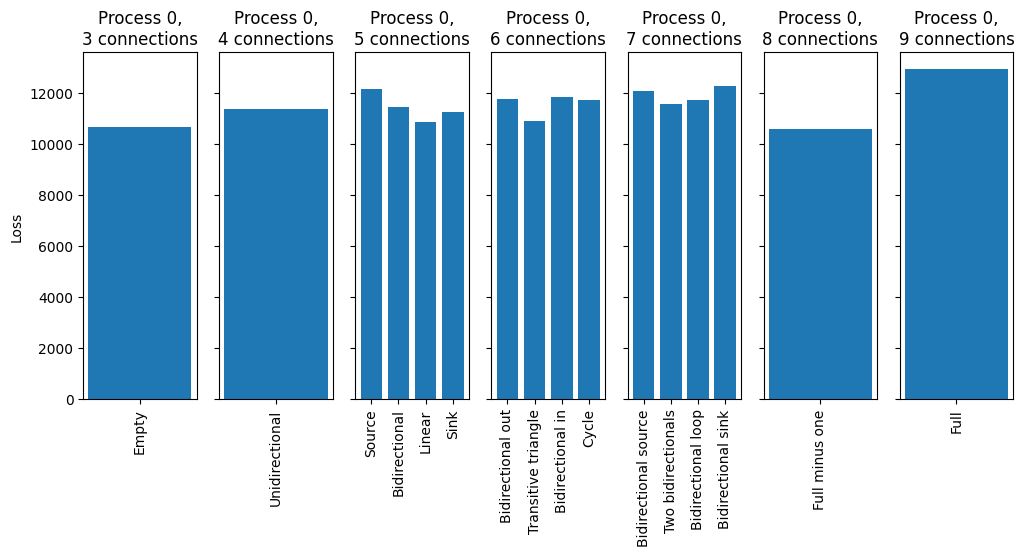

[{3: {'Empty': 10644.01244317627},
  4: {'Unidirectional': 11373.074547381604},
  5: {'Source': 12160.055196529956,
   'Bidirectional': 11435.795195672763,
   'Linear': 10862.539308191766,
   'Sink': 11263.388832304645},
  6: {'Bidirectional out': 11770.107161522465,
   'Transitive triangle': 10903.43159395528,
   'Bidirectional in': 11824.913482634942,
   'Cycle': 11718.813789606918},
  7: {'Bidirectional source': 12057.224976906899,
   'Two bidirectionals': 11546.208448186102,
   'Bidirectional loop': 11719.84195712137,
   'Bidirectional sink': 12287.625209792986},
  8: {'Full minus one': 10589.44194520049},
  9: {'Full': 12938.527176547079}}]

In [59]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-5), np.full(15, 1e-6), np.full(50, 5e-7), np.full(40, 1e-7))),
           A=np.array([[0.3, -0.3, -0.9], [-0.1, 0.9, -0.1], [0.2, 0.1, 1.2]]))

### 2D rotation, plus scaling

In [64]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0.6, 0.8, 0],[-0.8, 0.6, 0], [0, 0, 0.9]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 1e-6), np.full(20, 5e-7), np.full(20, 5e-8))))

Process dynamics: [[ 0.6  0.8  0. ]
 [-0.8  0.6  0. ]
 [ 0.   0.   0.9]]
Eigenvalues: [0.6+0.8j 0.6-0.8j 0.9+0.j ]
Kalman filter M: [[ 0.36576708  0.48768944  0.        ]
 [-0.48768944  0.36576708  0.        ]
 [ 0.          0.          0.58788979]]
Kalman filter K: [[ 3.90388203e-01 -7.85824477e-18  0.00000000e+00]
 [ 1.17873672e-17  3.90388203e-01  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.46789125e-01]]
Kalman filter loss: 8201.043883791372


  0%|                                                                   | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.46392086 0.         0.        ]
 [0.         0.25254788 0.        ]
 [0.         0.         0.626037  ]]
NN K: [[ 0.49306613  0.37473089  0.05118577]
 [-0.24227199  0.58497461 -0.02243074]
 [-0.06764834 -0.03494626  0.5445424 ]]
NN W: [[ 1.24704432 -0.23308001 -0.08447661]
 [ 0.20120661  1.32575366  0.00598263]
 [ 0.06744921 -0.03319129  0.59103317]]
Loss: 15214.163641143014
Testing Empty, Trial 2
NN M: [[ 0.14883648  0.          0.        ]
 [-0.          0.47735746  0.        ]
 [ 0.          0.          0.51786588]]
NN K: [[ 0.58630329  0.07397116 -0.28024634]
 [-0.31000848  0.5713361  -0.07523382]
 [ 0.108625    0.1188986   0.69485067]]
NN W: [[ 1.41138927 -0.02076566  0.34482821]
 [-0.02663173  1.2070215   0.10194587]
 [-0.16290068 -0.04289089  0.55980195]]
Loss: 16010.260939200418
Testing Empty, Trial 3


  6%|███▋                                                       | 1/16 [01:13<18:16, 73.08s/it]

NN M: [[0.14718646 0.         0.        ]
 [0.         0.37331404 0.        ]
 [0.         0.         0.6130717 ]]
NN K: [[ 0.64781402 -0.14640739 -0.21230651]
 [-0.05164433  0.57822251 -0.02721732]
 [ 0.02928414  0.00488077  0.49005815]]
NN W: [[ 1.28450672  0.47921849  0.27644526]
 [-0.36957634  1.31548378 -0.03777094]
 [-0.02996638  0.00614328  0.66221834]]
Loss: 14601.127457638047
Testing Unidirectional, Trial 1
NN M: [[ 0.33100135  0.          0.        ]
 [-0.2585993   0.33013541  0.        ]
 [ 0.          0.          0.58687155]]
NN K: [[ 0.51541479  0.31403147 -0.135101  ]
 [-0.23762335  0.4619121  -0.18492254]
 [-0.02834083  0.0616816   0.59172127]]
NN W: [[ 1.30919062 -0.28693552  0.14997099]
 [ 0.33980198  1.14972643  0.21732321]
 [-0.030215   -0.06124071  0.58877172]]
Loss: 12698.524694651318
Testing Unidirectional, Trial 2
NN M: [[ 0.27832952  0.          0.        ]
 [-0.32336358  0.25831114  0.        ]
 [ 0.          0.          0.58292966]]
NN K: [[ 0.55627186 -0.0893

 12%|███████▍                                                   | 2/16 [02:26<17:02, 73.06s/it]

NN M: [[ 0.21748173  0.          0.        ]
 [-0.25326854  0.2193655   0.        ]
 [ 0.          0.          0.62157017]]
NN K: [[ 6.29818293e-01  7.55273941e-02 -7.15508577e-02]
 [-1.30994967e-02  4.94368541e-01  1.69388785e-03]
 [ 9.64612580e-02 -2.19156635e-05  5.95042301e-01]]
NN W: [[ 1.35147033  0.10216923  0.07645581]
 [-0.03450092  1.32723051 -0.02101455]
 [-0.07540319  0.04370335  0.55005289]]
Loss: 12984.979537408446
Testing Source, Trial 1
NN M: [[ 0.26954526  0.          0.        ]
 [-0.25851402  0.27717306  0.        ]
 [-0.01647632  0.          0.37996388]]
NN K: [[ 0.45208126  0.16037004 -0.24098278]
 [-0.09454324  0.417113    0.24581598]
 [ 0.36207412 -0.13336316  0.76072926]]
NN W: [[ 1.52943673  0.05903669  0.38492493]
 [ 0.37521787  1.33001257 -0.36659876]
 [-0.29557514  0.25635239  0.51796834]]
Loss: 13501.267837735717
Testing Source, Trial 2
NN M: [[ 0.35155226  0.          0.        ]
 [-0.12328044  0.35860227  0.        ]
 [ 0.16751504  0.          0.61265484]

 19%|███████████                                                | 3/16 [03:39<15:53, 73.32s/it]

NN M: [[-0.01238984  0.          0.        ]
 [-0.36245691  0.18579068  0.        ]
 [ 0.2930307   0.          0.55325573]]
NN K: [[ 0.5921412  -0.25575538 -0.02002003]
 [ 0.21387596  0.46027579 -0.15850952]
 [ 0.02138229  0.11194779  0.70098397]]
NN W: [[ 1.39995844  0.49830984  0.10562164]
 [-0.59014833  1.18461744  0.14482415]
 [-0.0585832   0.06528393  0.5473923 ]]
Loss: 14906.807904353034
Testing Bidirectional, Trial 1
NN M: [[ 0.24349035  0.28008488  0.        ]
 [-0.1724494   0.30965464  0.        ]
 [ 0.          0.          0.47825164]]
NN K: [[ 0.4265984  -0.00205217 -0.11256443]
 [-0.03393188  0.55406562  0.03350474]
 [ 0.07810501  0.04184445  1.05232713]]
NN W: [[ 1.35995115  0.07344707  0.08499843]
 [-0.18137154  1.26456988 -0.06205978]
 [-0.06442778 -0.00863045  0.42885783]]
Loss: 10683.587307343638
Testing Bidirectional, Trial 2
NN M: [[ 0.24536797  0.30101326  0.        ]
 [-0.07166232  0.19545837  0.        ]
 [ 0.          0.          0.39896633]]
NN K: [[ 0.45606462 

 25%|██████████████▊                                            | 4/16 [04:52<14:36, 73.03s/it]

NN M: [[ 0.25275897  0.37328165  0.        ]
 [-0.11465205  0.25169745  0.        ]
 [ 0.          0.          0.54819444]]
NN K: [[ 0.53862587  0.12420667 -0.30638938]
 [-0.17653831  0.52166521  0.05212389]
 [ 0.07209796  0.03364551  0.86571109]]
NN W: [[ 1.04216403 -0.23914206  0.21941655]
 [ 0.18825222  1.31275023 -0.05561543]
 [-0.04625478  0.01484852  0.44377573]]
Loss: 11103.150903411602
Testing Linear, Trial 1
NN M: [[ 0.24753854  0.          0.        ]
 [-0.18785531  0.17244191  0.        ]
 [ 0.          0.40887962  0.22978069]]
NN K: [[ 0.39779728  0.12895242 -0.46790091]
 [-0.00585574  0.53312616  0.39647561]
 [ 0.37172724 -0.12682745  0.98360265]]
NN W: [[ 1.32000328e+00  3.47401803e-04  5.25309877e-01]
 [ 4.21492967e-01  1.38661651e+00 -3.56761108e-01]
 [-4.35435410e-01  7.38668681e-02  3.15473387e-01]]
Loss: 13065.985990935142
Testing Linear, Trial 2
NN M: [[ 0.23723174  0.          0.        ]
 [-0.3165154   0.00302854  0.        ]
 [ 0.          0.0096524   0.6340211 ]

 31%|██████████████████▍                                        | 5/16 [06:05<13:22, 72.98s/it]

NN M: [[-0.0115943   0.          0.        ]
 [-0.363722    0.45449152  0.        ]
 [ 0.          0.25673907  0.39400447]]
NN K: [[ 0.53027791 -0.04090314 -0.44749931]
 [-0.26386634  0.41711347 -0.23655741]
 [ 0.12321437  0.21530234  0.69531493]]
NN W: [[ 1.30188139 -0.13983454  0.59365097]
 [ 0.0235569   1.10517609  0.18558553]
 [-0.46260594 -0.1843571   0.48518694]]
Loss: 14578.571402914687
Testing Sink, Trial 1
NN M: [[ 0.20227026  0.          0.        ]
 [-0.42450973  0.16116662 -0.13033483]
 [ 0.          0.          0.54291263]]
NN K: [[ 0.53531429 -0.03922168 -0.15227209]
 [ 0.12451518  0.40483753  0.1154815 ]
 [ 0.21157185  0.01703299  0.50393598]]
NN W: [[ 1.49710242  0.35532047  0.24823226]
 [-0.23867914  1.28614852 -0.0730505 ]
 [-0.30557319  0.06091089  0.73395675]]
Loss: 13062.808718871736
Testing Sink, Trial 2
NN M: [[ 0.153355    0.          0.        ]
 [-0.25416344  0.16069828 -0.02337542]
 [ 0.          0.          0.5947443 ]]
NN K: [[ 0.62747507 -0.08003767 -0.070

 38%|██████████████████████▏                                    | 6/16 [07:18<12:09, 72.91s/it]

NN M: [[ 0.17593745  0.          0.        ]
 [-0.32306855  0.13682347 -0.17464937]
 [ 0.          0.          0.51622096]]
NN K: [[ 0.6078338  -0.02479998 -0.21315597]
 [ 0.1334137   0.55518033 -0.04683813]
 [ 0.18480615  0.05332439  0.67479872]]
NN W: [[ 1.33196202  0.22479254  0.29915972]
 [-0.26234071  1.13663026  0.1491919 ]
 [-0.205772    0.00716596  0.589458  ]]
Loss: 13031.285954356925
Testing Bidirectional out, Trial 1
NN M: [[ 0.10982236  0.28661125  0.        ]
 [-0.27818591  0.36819525  0.        ]
 [ 0.22424532  0.          0.51342175]]
NN K: [[ 0.44509366 -0.26563982 -0.20478238]
 [-0.00916666  0.51272916 -0.30034427]
 [ 0.19398281  0.26622484  0.81765089]]
NN W: [[ 1.131537    0.36152855  0.37001331]
 [-0.40348276  1.07236905  0.15223285]
 [-0.20453968 -0.04595     0.4641979 ]]
Loss: 11437.760419247552
Testing Bidirectional out, Trial 2
NN M: [[ 0.2948361   0.0504173   0.        ]
 [-0.34479142  0.30519601  0.        ]
 [ 0.13666115  0.          0.45572961]]
NN K: [[ 0.4

 44%|█████████████████████████▊                                 | 7/16 [08:31<10:57, 73.04s/it]

NN M: [[ 0.34534665  0.34877345  0.        ]
 [-0.19301398 -0.00945799  0.        ]
 [ 0.10439248  0.          0.32048007]]
NN K: [[ 0.51151413 -0.00488878 -0.15592247]
 [ 0.21168201  0.48882334  0.46804166]
 [-0.02979709 -0.30400409  0.8810924 ]]
NN W: [[ 1.11554796  0.24944562 -0.08838886]
 [-0.25507786  1.16385296 -0.45716603]
 [ 0.0216566   0.32983236  0.48008095]]
Loss: 13283.921489612363
Testing Transitive triangle, Trial 1
NN M: [[ 0.27445753  0.          0.        ]
 [-0.26670743  0.37978673  0.        ]
 [ 0.08775149 -0.00749616  0.62108207]]
NN K: [[ 0.57447871  0.12802394 -0.0725881 ]
 [-0.24751562  0.445282    0.04347253]
 [ 0.19496638 -0.06553741  1.00584682]]
NN W: [[ 1.43331145  0.06257032  0.05028609]
 [ 0.24267766  1.18958575 -0.04017589]
 [-0.03980167  0.11288033  0.32543693]]
Loss: 12902.376633055104
Testing Transitive triangle, Trial 2
NN M: [[ 0.1144924   0.          0.        ]
 [-0.37534262  0.10571211  0.        ]
 [ 0.01258741  0.0814781   0.38957011]]
NN K: [[

 50%|█████████████████████████████▌                             | 8/16 [09:44<09:43, 72.98s/it]

NN M: [[ 0.25599202  0.          0.        ]
 [-0.30657183  0.12180984  0.        ]
 [ 0.09600126  0.08065336  0.61205091]]
NN K: [[ 0.5090481  -0.06002132 -0.17044641]
 [ 0.163916    0.48207499 -0.25754797]
 [ 0.00175274  0.22137577  0.64564617]]
NN W: [[ 1.51119727  0.39398337  0.30469479]
 [-0.47850523  1.2580688   0.14074275]
 [-0.13717458 -0.14425303  0.48478644]]
Loss: 13753.368186085961
Testing Bidirectional in, Trial 1
NN M: [[ 0.41788967  0.10447271  0.08727726]
 [-0.28550418  0.01004742  0.        ]
 [ 0.          0.          0.18262833]]
NN K: [[ 0.44252918  0.25884619 -0.44478203]
 [ 0.15360893  0.50962698  0.10946213]
 [ 0.37503379 -0.0096348   0.81724494]]
NN W: [[ 1.05673453  0.00312668  0.56396191]
 [ 0.09556181  1.42976883 -0.26103527]
 [-0.32138124  0.0694267   0.55678118]]
Loss: 14648.626440605434
Testing Bidirectional in, Trial 2
NN M: [[ 0.2563545   0.23136074 -0.2324904 ]
 [-0.45169551  0.05234704  0.        ]
 [ 0.          0.          0.27346002]]
NN K: [[ 0.465

 56%|█████████████████████████████████▏                         | 9/16 [10:57<08:31, 73.01s/it]

NN M: [[ 0.30286324  0.18512996 -0.1066479 ]
 [-0.06986108  0.26898582  0.        ]
 [ 0.          0.          0.40503948]]
NN K: [[ 0.4758783   0.09169005 -0.31908767]
 [-0.14626028  0.48133965  0.18062578]
 [ 0.17904762 -0.03986636  0.79916017]]
NN W: [[ 1.27025366  0.05124121  0.51941904]
 [ 0.1740423   1.49657412 -0.25605938]
 [-0.13889737  0.11593807  0.56130152]]
Loss: 12838.747592051292
Testing Cycle, Trial 1
NN M: [[-0.03249355  0.          0.33322992]
 [-0.41025521  0.10180056  0.        ]
 [ 0.          0.052374    0.17481459]]
NN K: [[ 0.49504408 -0.26243117 -0.31073015]
 [ 0.13681518  0.31290857 -0.42225262]
 [ 0.30055823  0.44047946  0.58442533]]
NN W: [[ 1.12885842  0.18480727  0.41663839]
 [-0.46231311  1.0252052   0.48199638]
 [-0.22577763 -0.45295302  0.49750482]]
Loss: 14219.376554991124
Testing Cycle, Trial 2
NN M: [[ 0.09370969  0.         -0.17849309]
 [-0.24353434  0.28044703  0.        ]
 [ 0.         -0.01214364  0.08907576]]
NN K: [[ 0.62523678 -0.03341722  0.6

 62%|████████████████████████████████████▎                     | 10/16 [12:09<07:17, 72.88s/it]

NN M: [[ 0.24824667  0.          0.09082826]
 [-0.3323416   0.34287642  0.        ]
 [ 0.          0.08610712  0.63089136]]
NN K: [[ 0.52266151 -0.01406336  0.1306146 ]
 [-0.13261654  0.46804442  0.17843134]
 [-0.14824311 -0.11857027  0.62675038]]
NN W: [[ 1.59794513  0.27044666 -0.384749  ]
 [-0.03826005  1.2051063  -0.05686341]
 [ 0.12226185  0.01935626  0.46248662]]
Loss: 13453.453569247897
Testing Bidirectional source, Trial 1
NN M: [[ 0.23672518  0.08219491  0.        ]
 [-0.43610142  0.37480332  0.        ]
 [ 0.24474504 -0.09820169  0.39448585]]
NN K: [[ 0.48143682  0.17730661  0.25407971]
 [-0.12546165  0.44706252 -0.28853719]
 [-0.36305609  0.30618238  0.84822009]]
NN W: [[ 1.36946981 -0.09026836 -0.29828922]
 [ 0.29474678  0.9804928   0.34023501]
 [ 0.15272491 -0.17059828  0.41375128]]
Loss: 12017.388271590953
Testing Bidirectional source, Trial 2
NN M: [[ 0.23199099  0.31805364  0.        ]
 [-0.14553145  0.07883906  0.        ]
 [-0.01992093  0.0923268   0.39094947]]
NN K: 

 69%|███████████████████████████████████████▉                  | 11/16 [13:22<06:04, 72.82s/it]

NN M: [[ 0.35960699  0.1376268   0.        ]
 [-0.18462296  0.37705424  0.        ]
 [ 0.07150289 -0.09365087  0.69724573]]
NN K: [[ 0.40010926  0.27986016 -0.12978731]
 [-0.31329171  0.43429092 -0.12941564]
 [ 0.03055445  0.06218372  0.82252771]]
NN W: [[ 1.32189251e+00 -3.85587398e-01  9.07410894e-02]
 [ 4.34837656e-01  1.18805749e+00  1.06061191e-01]
 [ 2.43817812e-04  1.28762455e-02  3.16897248e-01]]
Loss: 12345.58331620097
Testing Two bidirectionals, Trial 1
NN M: [[ 0.27294905  0.20388115 -0.06082871]
 [-0.19951526  0.23894678  0.        ]
 [ 0.08492401  0.          0.59809604]]
NN K: [[ 0.45826295  0.24633427 -0.04196867]
 [-0.14236703  0.40583834  0.1662017 ]
 [ 0.12060298 -0.10903142  0.51884289]]
NN W: [[ 1.25147078 -0.43658878  0.15120332]
 [ 0.35140812  1.3606001  -0.25265498]
 [ 0.00834566  0.27065626  0.61387493]]
Loss: 10888.537537323262
Testing Two bidirectionals, Trial 2
NN M: [[ 0.19204379  0.16085519  0.00579422]
 [-0.36468191  0.2610516   0.        ]
 [ 0.04066197  

 75%|███████████████████████████████████████████▌              | 12/16 [14:35<04:52, 73.02s/it]

NN M: [[ 0.14798037  0.28140331 -0.26747254]
 [-0.22406123  0.31049846  0.        ]
 [ 0.02781669  0.          0.37925649]]
NN K: [[ 0.45804969 -0.19164821  0.54163629]
 [ 0.0784051   0.47991688  0.31043308]
 [-0.21321962 -0.39475119  0.62921516]]
NN W: [[ 0.93723722  0.14162829 -0.3801289 ]
 [-0.39710842  1.08084728 -0.18652768]
 [ 0.17781259  0.35658579  0.57588402]]
Loss: 11595.18618727174
Testing Bidirectional loop, Trial 1
NN M: [[ 0.16631848  0.45335792  0.        ]
 [-0.30499237  0.11107948  0.00263128]
 [ 0.02150278  0.          0.50370752]]
NN K: [[ 0.44742836 -0.27520866 -0.12557808]
 [ 0.14465711  0.52596496  0.13447737]
 [ 0.07817292 -0.15322273  0.83616463]]
NN W: [[ 1.14585928  0.33737763  0.02042078]
 [-0.17505198  1.12623863 -0.13550625]
 [-0.01360841  0.13851248  0.50014999]]
Loss: 10673.361661961168
Testing Bidirectional loop, Trial 2
NN M: [[ 0.02919787  0.31884409  0.        ]
 [-0.16573791  0.36956759 -0.06287584]
 [ 0.0395664   0.          0.26995087]]
NN K: [[ 0.

 81%|███████████████████████████████████████████████▏          | 13/16 [15:48<03:38, 72.91s/it]

NN M: [[ 0.25870505  0.20708758  0.        ]
 [-0.38156164  0.16153525  0.01925269]
 [ 0.06921324  0.          0.56821885]]
NN K: [[ 0.535773   -0.18032353 -0.05918308]
 [ 0.17154051  0.4463062   0.04548636]
 [ 0.01499564 -0.02987571  0.82245296]]
NN W: [[ 1.18609928e+00  4.82619618e-01  1.29283171e-02]
 [-3.21124540e-01  1.10498025e+00 -6.96693914e-02]
 [ 1.20780347e-04  5.80087059e-02  4.57891844e-01]]
Loss: 10494.6043408624
Testing Bidirectional sink, Trial 1
NN M: [[ 0.10880285  0.          0.        ]
 [-0.16822326  0.21438406 -0.08530748]
 [ 0.12496625  0.26342733  0.28346906]]
NN K: [[ 0.51862539  0.056477   -0.45531873]
 [-0.05529491  0.48286751  0.04979897]
 [ 0.33338821  0.05655776  1.06553526]]
NN W: [[ 1.24591957 -0.00378712  0.46865586]
 [ 0.06321698  1.4271025   0.00186183]
 [-0.41826131  0.01554888  0.38737178]]
Loss: 13137.054908208975
Testing Bidirectional sink, Trial 2
NN M: [[ 0.43053425  0.          0.        ]
 [-0.20503406  0.18573383 -0.0409366 ]
 [ 0.04846477  0

 88%|██████████████████████████████████████████████████▊       | 14/16 [17:01<02:25, 72.89s/it]

NN M: [[ 0.20427955  0.          0.        ]
 [-0.28890403  0.23400367  0.11370288]
 [ 0.07773479  0.02912651  0.42989212]]
NN K: [[ 0.52832034 -0.00357501  0.12263853]
 [ 0.02993197  0.43702763 -0.31463901]
 [-0.32107383  0.15457385  0.64760964]]
NN W: [[ 1.55903003  0.29841481 -0.13566161]
 [-0.09020844  1.23374001  0.33682608]
 [ 0.31152063 -0.20963752  0.63799803]]
Loss: 13266.16829931238
Testing Full minus one, Trial 1
NN M: [[ 0.08957936  0.29546744 -0.07045843]
 [-0.28212396  0.17062215  0.        ]
 [-0.0297291   0.10706861  0.56832958]]
NN K: [[ 0.48502357  0.0295513  -0.03746616]
 [-0.08980426  0.57125775 -0.081957  ]
 [ 0.05668296 -0.05028301  0.7334888 ]]
NN W: [[ 1.33331107 -0.28256936  0.13456217]
 [ 0.25336045  1.18231199  0.07224754]
 [-0.07892543  0.03734514  0.50359127]]
Loss: 11237.55585233879
Testing Full minus one, Trial 2
NN M: [[ 0.0247227   0.42321098  0.03344244]
 [-0.15193992  0.30066518  0.        ]
 [-0.0207864   0.0758624   0.68571389]]
NN K: [[ 0.53845181 

 94%|██████████████████████████████████████████████████████▍   | 15/16 [18:14<01:13, 73.01s/it]

NN M: [[ 0.33746839  0.17852231 -0.08515178]
 [-0.20759421  0.30021451  0.        ]
 [-0.18528937  0.11916557  0.55628265]]
NN K: [[ 0.49054715  0.20967984 -0.05751206]
 [-0.13372812  0.52596291 -0.08375022]
 [ 0.16132539 -0.11737969  0.69107607]]
NN W: [[ 1.18955757 -0.18340484  0.21709214]
 [ 0.10307016  1.2182286   0.06562916]
 [-0.09891932  0.03132759  0.50046313]]
Loss: 10751.983735751539
Testing Full, Trial 1
NN M: [[ 0.17560237  0.49904173 -0.01381676]
 [-0.00175739  0.25931719 -0.17029242]
 [-0.07399585  0.05148914  0.17237307]]
NN K: [[ 0.24437147  0.01567527 -0.47852075]
 [-0.02561619  0.48841197  0.24129805]
 [ 0.5601055  -0.20455195  0.68940645]]
NN W: [[ 1.05582359  0.04849666  0.55408022]
 [-0.00770301  1.36244172 -0.24093068]
 [-0.45503637  0.23230666  0.45423337]]
Loss: 13121.36901183248
Testing Full, Trial 2
NN M: [[ 0.07791123  0.43583225  0.09720616]
 [-0.34389205 -0.01774678 -0.18800953]
 [ 0.011527    0.12174325  0.32507751]]
NN K: [[ 0.32867994 -0.37772633 -0.3769

100%|██████████████████████████████████████████████████████████| 16/16 [19:27<00:00, 72.99s/it]

NN M: [[ 0.37089247  0.21359669 -0.00920955]
 [-0.00243892  0.33709287 -0.27678528]
 [ 0.19938537 -0.0492974   0.09616953]]
NN K: [[ 0.3338438   0.3532926  -0.22020488]
 [-0.28222862  0.34704698  0.42695698]
 [ 0.34893458 -0.21109403  0.72203417]]
NN W: [[ 1.09331256 -0.31950033  0.42624732]
 [ 0.40700341  1.07563845 -0.32017644]
 [-0.26155779  0.38819754  0.50855014]]
Loss: 13612.095987527853


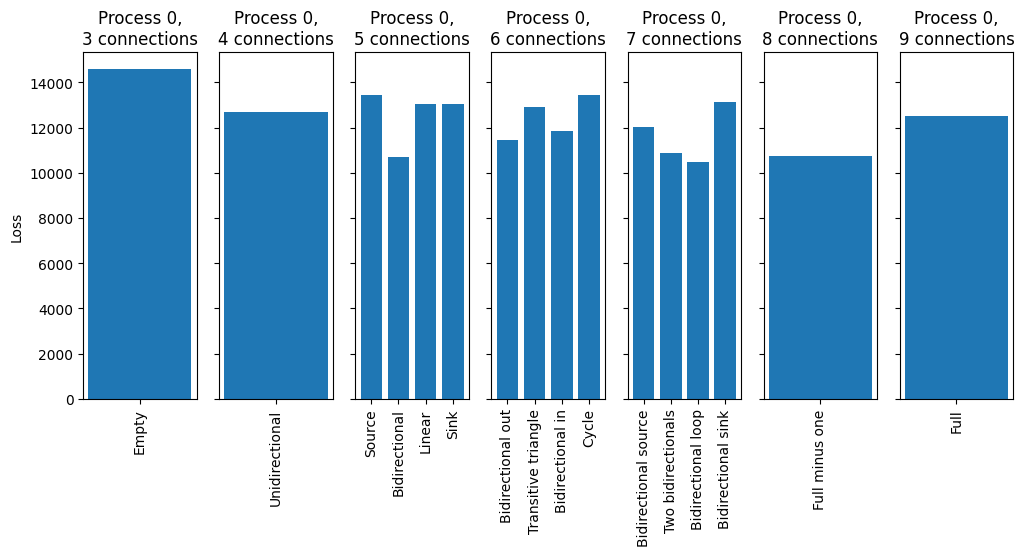

[{3: {'Empty': 14601.127457638047},
  4: {'Unidirectional': 12698.524694651318},
  5: {'Source': 13467.021451950055,
   'Bidirectional': 10683.587307343638,
   'Linear': 13065.985990935142,
   'Sink': 13031.285954356925},
  6: {'Bidirectional out': 11437.760419247552,
   'Transitive triangle': 12902.376633055104,
   'Bidirectional in': 11849.912694062199,
   'Cycle': 13453.453569247897},
  7: {'Bidirectional source': 12017.388271590953,
   'Two bidirectionals': 10888.537537323262,
   'Bidirectional loop': 10494.6043408624,
   'Bidirectional sink': 13137.054908208975},
  8: {'Full minus one': 10751.983735751539},
  9: {'Full': 12518.974307572817}}]

In [60]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-5), np.full(15, 1e-6), np.full(20, 5e-7), np.full(20, 5e-8))),
           A=np.array([[0.6, 0.8, 0],[-0.8, 0.6, 0], [0, 0, 0.9]]))

### Transitive triangle with loops, one negative connection

In [65]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0.8, 0, 0],[0.8, 0.8, 0], [0.8, -0.8, 0.8]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-6), np.full(15, 1e-7), np.full(30, 3e-8), np.full(30, 1e-8))))

Process dynamics: [[ 0.8  0.   0. ]
 [ 0.8  0.8  0. ]
 [ 0.8 -0.8  0.8]]
Eigenvalues: [0.8 0.8 0.8]
Kalman filter M: [[ 0.45382871 -0.03070741 -0.04706014]
 [ 0.3951711   0.4224923   0.02522317]
 [ 0.37894418 -0.37555797  0.40078115]]
Kalman filter K: [[ 0.27667951  0.09720943  0.05882517]
 [ 0.09720943  0.44035566 -0.03152897]
 [ 0.05882517 -0.03152897  0.49902357]]
Kalman filter loss: 9731.227776741955


  0%|                                                                   | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[-0.12615636  0.          0.        ]
 [ 0.          0.30063402  0.        ]
 [ 0.          0.          0.31789737]]
NN K: [[ 0.14917632  0.21692335  0.05648537]
 [ 0.5537033   0.66389524 -0.21720179]
 [ 0.07603453 -0.11748802  0.53703633]]
NN W: [[ 0.88481949  0.06365405  0.01184323]
 [ 0.09649348  0.6596561   0.16012797]
 [-0.10836793 -0.01491356  1.19504476]]
Loss: 14262.078921375834
Testing Empty, Trial 2
NN M: [[-0.06496422  0.          0.        ]
 [ 0.          0.31186457  0.        ]
 [ 0.          0.          0.2772733 ]]
NN K: [[ 0.20959376  0.15441613  0.01452308]
 [ 0.49310734  0.68982618 -0.17934014]
 [ 0.28114531 -0.16227579  0.51783011]]
NN W: [[ 0.88726769  0.08531998  0.05736422]
 [ 0.12864002  0.65019649  0.13826213]
 [-0.12966133 -0.00856547  1.29793807]]
Loss: 13794.501514495507
Testing Empty, Trial 3


  6%|███▋                                                       | 1/16 [01:33<23:22, 93.48s/it]

NN M: [[-0.1184898   0.          0.        ]
 [ 0.          0.35332073  0.        ]
 [ 0.          0.          0.22811717]]
NN K: [[ 0.26638939  0.19314004  0.09097014]
 [ 0.4861085   0.6063606  -0.26755042]
 [ 0.35807424 -0.00773796  0.48044333]]
NN W: [[ 0.89217319  0.06883193 -0.01447941]
 [ 0.10490035  0.6803964   0.34171   ]
 [-0.12595195 -0.25538388  1.3538523 ]]
Loss: 14932.132299673825
Testing Unidirectional, Trial 1
NN M: [[-0.10108376  0.          0.        ]
 [ 0.24872809  0.15124525  0.        ]
 [ 0.          0.          0.36302324]]
NN K: [[ 0.23914976  0.35256684 -0.06020439]
 [ 0.49897495  0.60729388 -0.23853496]
 [ 0.38807072 -0.14060134  0.40948452]]
NN W: [[ 0.88470806 -0.12761618  0.04778734]
 [-0.03036127  0.72897438  0.18252157]
 [ 0.133367   -0.28554702  1.2776754 ]]
Loss: 16031.062048988777
Testing Unidirectional, Trial 2
NN M: [[0.04108136 0.         0.        ]
 [0.20757928 0.35346459 0.        ]
 [0.         0.         0.35763918]]
NN K: [[ 0.22944952  0.3670

 12%|███████▍                                                   | 2/16 [03:06<21:45, 93.22s/it]

NN M: [[-0.02422535  0.          0.        ]
 [ 0.19312973  0.19881376  0.        ]
 [ 0.          0.          0.29065419]]
NN K: [[ 0.19085289  0.26711796  0.01022257]
 [ 0.4248691   0.59949711 -0.20050038]
 [ 0.34284091 -0.06096988  0.44593891]]
NN W: [[ 0.84428093 -0.0078871   0.03416473]
 [ 0.0135396   0.82204262  0.21659979]
 [-0.0400813  -0.30164442  1.34041002]]
Loss: 14429.827334066958
Testing Source, Trial 1
NN M: [[-0.02886331  0.          0.        ]
 [ 0.18951748  0.11005835  0.        ]
 [ 0.20044278  0.          0.38270438]]
NN K: [[ 0.32866385  0.18385248  0.11062431]
 [ 0.35272047  0.68614567 -0.27805275]
 [ 0.48795939 -0.2336557   0.39489217]]
NN W: [[ 0.88705954  0.06869205 -0.0544081 ]
 [ 0.08293195  0.80399998  0.21084168]
 [-0.12691784 -0.22239931  1.22579446]]
Loss: 17018.946639092734
Testing Source, Trial 2
NN M: [[-0.05779514  0.          0.        ]
 [ 0.33380113  0.23062378  0.        ]
 [ 0.32074328  0.          0.25372688]]
NN K: [[ 0.28147976  0.30432051  0

 19%|███████████                                                | 3/16 [04:40<20:13, 93.37s/it]

NN M: [[-0.11726228  0.          0.        ]
 [ 0.41896745  0.17870983  0.        ]
 [ 0.07537528  0.          0.33741331]]
NN K: [[ 0.32371277  0.21560461  0.0911491 ]
 [ 0.23778463  0.68151856 -0.22452897]
 [ 0.23069338 -0.11547383  0.42499631]]
NN W: [[ 0.89267235  0.02563003 -0.05451527]
 [ 0.10815311  0.85327187  0.23877706]
 [ 0.15903392 -0.23855331  1.29829031]]
Loss: 12922.951290153454
Testing Bidirectional, Trial 1
NN M: [[-0.17550108  0.07754659  0.        ]
 [ 0.11448147  0.20855293  0.        ]
 [ 0.          0.          0.29352812]]
NN K: [[ 0.15325398  0.32558062  0.00702345]
 [ 0.37577725  0.74640877 -0.10322276]
 [ 0.01874108 -0.22775384  0.53262236]]
NN W: [[ 0.88152052 -0.04976665  0.04342965]
 [-0.04039122  0.83504541  0.09666179]
 [ 0.12116258  0.12754669  1.26874124]]
Loss: 12640.823643407382
Testing Bidirectional, Trial 2
NN M: [[-0.17501076  0.09231031  0.        ]
 [ 0.25329239  0.184807    0.        ]
 [ 0.          0.          0.33519878]]
NN K: [[ 0.33717723 

 25%|██████████████▊                                            | 4/16 [06:13<18:41, 93.48s/it]

NN M: [[-0.2419134   0.09239123  0.        ]
 [ 0.07805928  0.14761116  0.        ]
 [ 0.          0.          0.34402753]]
NN K: [[ 0.12879377  0.26089707  0.05464806]
 [ 0.35880331  0.65919755 -0.17776451]
 [ 0.50963577 -0.14433314  0.40363254]]
NN W: [[ 0.85483437  0.02644481  0.03365153]
 [-0.01252813  0.85750185  0.16709678]
 [ 0.01308263 -0.33957702  1.31916164]]
Loss: 17914.07434199473
Testing Linear, Trial 1
NN M: [[-0.10675394  0.          0.        ]
 [ 0.3076076   0.15119147  0.        ]
 [ 0.         -0.18013384  0.32497924]]
NN K: [[ 0.40171668  0.32594985  0.20865205]
 [ 0.30110218  0.38016379 -0.37978386]
 [ 0.36910164 -0.10498017  0.36893792]]
NN W: [[ 0.8520001  -0.03395944 -0.18700699]
 [ 0.09745169  0.78514117  0.22125692]
 [ 0.1196584  -0.23483762  1.19385024]]
Loss: 17549.32416156752
Testing Linear, Trial 2
NN M: [[-0.14545377  0.          0.        ]
 [ 0.14992877  0.2341092   0.        ]
 [ 0.         -0.06227434  0.26835034]]
NN K: [[ 0.19880501  0.29532806 -0.0

 31%|██████████████████▍                                        | 5/16 [07:47<17:09, 93.61s/it]

NN M: [[-0.15369345  0.          0.        ]
 [ 0.33409835  0.20833883  0.        ]
 [ 0.         -0.24912825  0.27107024]]
NN K: [[ 0.20086408  0.38390599  0.10265248]
 [ 0.37982299  0.38857277 -0.4309152 ]
 [ 0.39290575 -0.00192435  0.32685941]]
NN W: [[ 0.90054488  0.01077687 -0.03304804]
 [ 0.11588469  0.73783367  0.37794008]
 [ 0.08321684 -0.29500134  1.17837797]]
Loss: 17053.257494151312
Testing Sink, Trial 1
NN M: [[-0.08940918  0.          0.        ]
 [ 0.06522169  0.33346611  0.08701649]
 [ 0.          0.          0.36190293]]
NN K: [[ 0.20185674  0.27411158 -0.01844353]
 [ 0.49177641  0.62528121 -0.29371751]
 [ 0.48360093 -0.17402866  0.42282171]]
NN W: [[ 0.88703852 -0.00914869  0.06117642]
 [-0.01696557  0.68233528  0.24921181]
 [ 0.15814153 -0.21055142  1.24134076]]
Loss: 16353.161925998462
Testing Sink, Trial 2
NN M: [[-0.15423942  0.          0.        ]
 [ 0.28999268  0.24644675 -0.07915274]
 [ 0.          0.          0.35751233]]
NN K: [[ 0.24117718  0.28482355  0.083

 38%|██████████████████████▏                                    | 6/16 [09:21<15:35, 93.56s/it]

NN M: [[-0.16145218  0.          0.        ]
 [ 0.10252749  0.34067294  0.00668676]
 [ 0.          0.          0.33793063]]
NN K: [[ 0.21340838  0.16915459  0.01483706]
 [ 0.48584824  0.61992183 -0.22431631]
 [ 0.43328867 -0.19630723  0.44868451]]
NN W: [[ 0.85482964  0.03101688  0.02254668]
 [-0.01524141  0.58971256  0.14761118]
 [-0.20658648 -0.08475495  1.2816741 ]]
Loss: 17586.6616058116
Testing Bidirectional out, Trial 1
NN M: [[-0.24195876  0.08182     0.        ]
 [-0.01832324  0.21556132  0.        ]
 [-0.01165011  0.          0.33520568]]
NN K: [[ 0.16613635  0.05677199 -0.02499767]
 [ 0.54950959  0.67474036 -0.32439652]
 [ 0.5669343  -0.04082787  0.34343072]]
NN W: [[ 0.83086907  0.04451792  0.13210672]
 [-0.07988089  0.65869821  0.33645077]
 [-0.25562612 -0.42295552  1.38793065]]
Loss: 18548.357518656874
Testing Bidirectional out, Trial 2
NN M: [[ 0.08628183  0.11511617  0.        ]
 [-0.09869177  0.13288457  0.        ]
 [ 0.45240357  0.          0.26135331]]
NN K: [[ 0.404

 44%|█████████████████████████▊                                 | 7/16 [10:54<14:01, 93.54s/it]

NN M: [[-0.30802051  0.12954142  0.        ]
 [ 0.07450068  0.22982866  0.        ]
 [ 0.00218721  0.          0.3277143 ]]
NN K: [[ 0.16767243  0.1352251  -0.07592938]
 [ 0.3900023   0.71627563 -0.07023621]
 [ 0.40160295 -0.20241     0.47259355]]
NN W: [[ 0.88289016  0.03229968  0.1242745 ]
 [-0.02005944  0.81888515  0.05152227]
 [ 0.03199351 -0.08957168  1.27342198]]
Loss: 15094.918093096518
Testing Transitive triangle, Trial 1
NN M: [[-0.26691662  0.          0.        ]
 [ 0.48803698  0.35033943  0.        ]
 [ 0.3511073  -0.12292464  0.2564323 ]]
NN K: [[ 0.30136005  0.46393912  0.22797097]
 [ 0.18146779  0.4441262  -0.22617627]
 [ 0.37225918 -0.17817835  0.39942627]]
NN W: [[ 0.86481754  0.01862776 -0.12774666]
 [ 0.16095669  0.76490409  0.15435929]
 [ 0.0169632  -0.18842884  1.28411216]]
Loss: 15682.243863254418
Testing Transitive triangle, Trial 2
NN M: [[ 0.11268768  0.          0.        ]
 [ 0.15714858  0.17319451  0.        ]
 [-0.32257567  0.0766713   0.28628081]]
NN K: [[

 50%|█████████████████████████████▌                             | 8/16 [12:32<12:39, 94.93s/it]

NN M: [[-0.12061207  0.          0.        ]
 [ 0.34348061  0.24551178  0.        ]
 [-0.17673376 -0.21074139  0.21412191]]
NN K: [[-0.10990746  0.22066176 -0.15352982]
 [ 0.10722844  0.59999212 -0.2254382 ]
 [ 0.42858259  0.02349889  0.40037268]]
NN W: [[ 0.85173094 -0.06280022  0.14032297]
 [-0.24655642  0.730182    0.19374285]
 [-0.19346797 -0.19261175  1.22021541]]
Loss: 19470.012747895773
Testing Bidirectional in, Trial 1
NN M: [[-0.19147164  0.08331032 -0.04738692]
 [ 0.00380031  0.18846938  0.        ]
 [ 0.          0.          0.29932393]]
NN K: [[ 0.07918739  0.30006235 -0.11089222]
 [ 0.45644684  0.71509129 -0.18525773]
 [ 0.38224953 -0.09777484  0.43820712]]
NN W: [[ 0.70733812 -0.12686025  0.10690123]
 [-0.22993957  0.8257242   0.13234899]
 [-0.07095935 -0.22191361  1.36259289]]
Loss: 16872.941457726538
Testing Bidirectional in, Trial 2
NN M: [[-0.35730478  0.07340568  0.18901873]
 [ 0.38018482  0.33224961  0.        ]
 [ 0.          0.          0.33961982]]
NN K: [[ 0.241

 56%|████████████████████████████████▋                         | 9/16 [14:23<11:40, 100.10s/it]

NN M: [[-0.3195795   0.02059435  0.10171676]
 [ 0.05952687  0.1701225   0.        ]
 [ 0.          0.          0.32469643]]
NN K: [[ 0.162441    0.18424673  0.03112372]
 [ 0.38830592  0.50115945 -0.42955843]
 [ 0.56014126  0.02982879  0.27532499]]
NN W: [[ 0.76897904  0.02062084 -0.03988982]
 [-0.07783151  0.54370669  0.32554021]
 [-0.02803209 -0.7457452   1.31979338]]
Loss: 22845.93860137403
Testing Cycle, Trial 1
NN M: [[-0.36902669  0.          0.06635399]
 [-0.08525341  0.33089973  0.        ]
 [ 0.         -0.30684118  0.14067421]]
NN K: [[ 0.22550344  0.13572716  0.10446622]
 [ 0.11915822  0.55830253 -0.43309033]
 [ 0.42006292  0.15982647  0.28843785]]
NN W: [[ 0.80249937  0.05075153 -0.07140227]
 [ 0.04639245  0.62382274  0.49504089]
 [-0.18192149 -0.44797786  1.03916851]]
Loss: 16129.976462561719
Testing Cycle, Trial 2
NN M: [[-0.10437586  0.          0.10424923]
 [ 0.30866567  0.17270802  0.        ]
 [ 0.         -0.0919015   0.29413337]]
NN K: [[ 0.22468086  0.33142658  0.12

 62%|███████████████████████████████████▋                     | 10/16 [16:18<10:27, 104.66s/it]

NN M: [[-0.20868371  0.          0.10673762]
 [ 0.30865829 -0.09695933  0.        ]
 [ 0.          0.18059426  0.4233036 ]]
NN K: [[ 0.20711568  0.36610529  0.06283422]
 [ 0.53192083  0.59455048 -0.1397825 ]
 [ 0.11004306 -0.29458258  0.44915606]]
NN W: [[ 0.78995418 -0.02467601 -0.08384082]
 [ 0.09854653  0.85784625 -0.03312229]
 [-0.06240581 -0.11597659  1.1992327 ]]
Loss: 17856.471128626064
Testing Bidirectional source, Trial 1
NN M: [[-0.31777142  0.0848303   0.        ]
 [ 0.05042318  0.34607027  0.        ]
 [ 0.15167484 -0.2988857   0.1004097 ]]
NN K: [[ 0.20632855  0.17004064  0.08607579]
 [ 0.16280449  0.52019841 -0.45427109]
 [ 0.51611208  0.09865597  0.25680268]]
NN W: [[ 0.78491512  0.03587946  0.0525398 ]
 [-0.10360797  0.59826305  0.53625708]
 [ 0.06581079 -0.40531744  1.15402585]]
Loss: 20068.809884004597
Testing Bidirectional source, Trial 2
NN M: [[-0.33338421  0.12900731  0.        ]
 [-0.23546238  0.22601911  0.        ]
 [ 0.13293694 -0.24013334  0.21600245]]
NN K: 

 69%|███████████████████████████████████████▏                 | 11/16 [18:12<08:56, 107.32s/it]

NN M: [[-0.19159113 -0.04136588  0.        ]
 [ 0.15660921  0.26495746  0.        ]
 [ 0.24937657 -0.14137811  0.20237123]]
NN K: [[ 0.36931226  0.31246049  0.00593774]
 [ 0.33439084  0.53110355 -0.5204677 ]
 [ 0.39549268 -0.03648524  0.36210756]]
NN W: [[ 0.78640827 -0.01099048 -0.01734129]
 [ 0.14527057  0.57598047  0.47072444]
 [ 0.06527103 -0.31713556  1.17718434]]
Loss: 17573.56022022789
Testing Two bidirectionals, Trial 1
NN M: [[-0.3359843   0.03281094 -0.18198272]
 [-0.25952561  0.16836026  0.        ]
 [-0.04078534  0.          0.3487457 ]]
NN K: [[ 0.08739282  0.0143156  -0.10785675]
 [ 0.29926902  0.71038725 -0.19852517]
 [ 0.45764259 -0.18847053  0.40574721]]
NN W: [[ 6.61391345e-01  7.76370699e-04  1.46571436e-01]
 [-2.05103178e-01  8.58737982e-01  8.87061937e-02]
 [-7.66070987e-02 -1.68073331e-01  1.33368046e+00]]
Loss: 18894.44090656177
Testing Two bidirectionals, Trial 2
NN M: [[-0.3693031   0.14810483 -0.06067146]
 [ 0.26005864  0.15117935  0.        ]
 [ 0.19248142  0

 75%|██████████████████████████████████████████▊              | 12/16 [20:06<07:18, 109.55s/it]

NN M: [[-0.07583483  0.12487932 -0.08670564]
 [ 0.45098254  0.21568145  0.        ]
 [ 0.35024998  0.          0.29875696]]
NN K: [[ 0.30141349  0.22586798  0.30555246]
 [ 0.44907888  0.51250088 -0.2221606 ]
 [ 0.37577858 -0.31522925  0.37169668]]
NN W: [[ 0.73921853  0.0945467  -0.10985706]
 [ 0.10246807  0.86269987  0.13154288]
 [ 0.36675732 -0.24948022  1.2480759 ]]
Loss: 16669.229733766428
Testing Bidirectional loop, Trial 1
NN M: [[-0.28073071  0.11396341  0.        ]
 [ 0.1752747   0.00634321 -0.19437623]
 [ 0.1503823   0.          0.36017398]]
NN K: [[ 0.14808006  0.1299231  -0.04053021]
 [ 0.45537676  0.72298962 -0.22304097]
 [ 0.37584431 -0.13387654  0.36110362]]
NN W: [[ 0.76198293 -0.05287816  0.0477067 ]
 [-0.07091134  0.59890489  0.12776613]
 [-0.35083735 -0.31126112  1.3758648 ]]
Loss: 21833.78500661623
Testing Bidirectional loop, Trial 2
NN M: [[-0.21768056  0.06438013  0.        ]
 [ 0.03476831  0.06613593 -0.17467118]
 [ 0.09922351  0.          0.305393  ]]
NN K: [[ 0.

 81%|██████████████████████████████████████████████▎          | 13/16 [22:03<05:34, 111.62s/it]

NN M: [[-0.12271003  0.0185307   0.        ]
 [ 0.60585745  0.06708961 -0.02959886]
 [ 0.1811716   0.          0.28791719]]
NN K: [[ 0.3532219   0.39425988  0.19091964]
 [ 0.39220093  0.58137201 -0.27975053]
 [ 0.23122655 -0.168583    0.45612391]]
NN W: [[ 0.81747076 -0.00844478 -0.12178753]
 [ 0.08474356  0.75668978  0.12743922]
 [ 0.02027719 -0.17071717  1.3043848 ]]
Loss: 14654.386996683845
Testing Bidirectional sink, Trial 1
NN M: [[-0.38239762  0.          0.        ]
 [-0.09842203  0.39496708  0.09526363]
 [-0.14368358 -0.17729665  0.21167457]]
NN K: [[-0.01275397  0.11016298 -0.1171134 ]
 [ 0.15876948  0.60238439 -0.37217736]
 [ 0.41436944  0.11839184  0.38775591]]
NN W: [[ 0.90008953 -0.03527305  0.0679119 ]
 [-0.21336286  0.67951469  0.39626015]
 [-0.08213951 -0.31237288  1.17077998]]
Loss: 15864.754827972687
Testing Bidirectional sink, Trial 2
NN M: [[-0.11385905  0.          0.        ]
 [ 0.35537769  0.17124866 -0.05683793]
 [ 0.27006225 -0.15435829  0.33319981]]
NN K: [[ 0

 88%|█████████████████████████████████████████████████▉       | 14/16 [23:53<03:42, 111.10s/it]

NN M: [[-0.06919936  0.          0.        ]
 [ 0.23719603  0.1538155   0.03311407]
 [ 0.18200162 -0.23089701  0.33813162]]
NN K: [[ 0.30456337  0.29539138  0.0948475 ]
 [ 0.56844083  0.46406595 -0.42769859]
 [ 0.12647626 -0.07654307  0.41218617]]
NN W: [[ 0.92794022  0.04189217 -0.01701973]
 [ 0.26718562  0.71441096  0.22900769]
 [ 0.01692122 -0.10184773  1.06653778]]
Loss: 16327.779487779038
Testing Full minus one, Trial 1
NN M: [[-0.0255359  -0.01889093 -0.11423825]
 [ 0.31886244  0.26226996  0.        ]
 [ 0.5178161   0.02139212  0.26556859]]
NN K: [[ 0.33730145 -0.02467457  0.3258108 ]
 [ 0.30987211  0.63212944 -0.0530814 ]
 [-0.20163173 -0.14729282  0.35541506]]
NN W: [[ 0.72303502  0.17501367 -0.23153506]
 [-0.06598967  0.95260916 -0.05677435]
 [ 0.53942229 -0.04079342  1.21789465]]
Loss: 12725.302236007983
Testing Full minus one, Trial 2
NN M: [[ 0.07042046  0.08076423  0.04244167]
 [ 0.24401786  0.28921959  0.        ]
 [ 0.46821014 -0.176207    0.16385601]]
NN K: [[ 0.4558570

 94%|█████████████████████████████████████████████████████▍   | 15/16 [25:43<01:50, 110.95s/it]

NN M: [[-0.44484532  0.19818758  0.02440416]
 [-0.01513111  0.37778973  0.        ]
 [ 0.06268219 -0.1723831   0.22046662]]
NN K: [[ 0.19445786  0.11497012  0.08267388]
 [ 0.18734715  0.65099622 -0.32714927]
 [ 0.4629649   0.03006759  0.41268372]]
NN W: [[ 0.75089602  0.02878677  0.06763999]
 [-0.05978475  0.67833819  0.42989342]
 [-0.05218676 -0.24307593  1.17135935]]
Loss: 15575.41990238381
Testing Full, Trial 1
NN M: [[-0.37306253  0.01156501  0.02318159]
 [ 0.05428005  0.0085021   0.13245679]
 [-0.01755964  0.11556798  0.2892166 ]]
NN K: [[ 0.34335644  0.27205447 -0.00604479]
 [ 0.46546759  0.76499761 -0.03009073]
 [ 0.23864425 -0.23441761  0.47677896]]
NN W: [[ 0.81697088 -0.08769974  0.00414121]
 [-0.11781449  0.84119573 -0.18771846]
 [-0.07969357 -0.09520725  1.36740242]]
Loss: 16070.488022537622
Testing Full, Trial 2
NN M: [[-0.24249264  0.00470565  0.08169003]
 [ 0.2408944   0.11319702  0.01350499]
 [-0.1353011  -0.11755775  0.2973137 ]]
NN K: [[ 0.10163494  0.34992269 -0.1471

100%|█████████████████████████████████████████████████████████| 16/16 [27:34<00:00, 103.41s/it]

NN M: [[-0.48817573 -0.02095971  0.29166125]
 [ 0.25162757  0.25557617 -0.02486667]
 [-0.28568616 -0.17807489  0.28002377]]
NN K: [[-0.21873745  0.06652264 -0.01796038]
 [ 0.12507161  0.46382176 -0.41239894]
 [ 0.24862767 -0.01217677  0.41155894]]
NN W: [[ 0.76248672  0.01319515 -0.15195704]
 [-0.37651654  0.56453607  0.28757682]
 [ 0.15102384 -0.21370525  1.19442637]]
Loss: 27567.618640137127


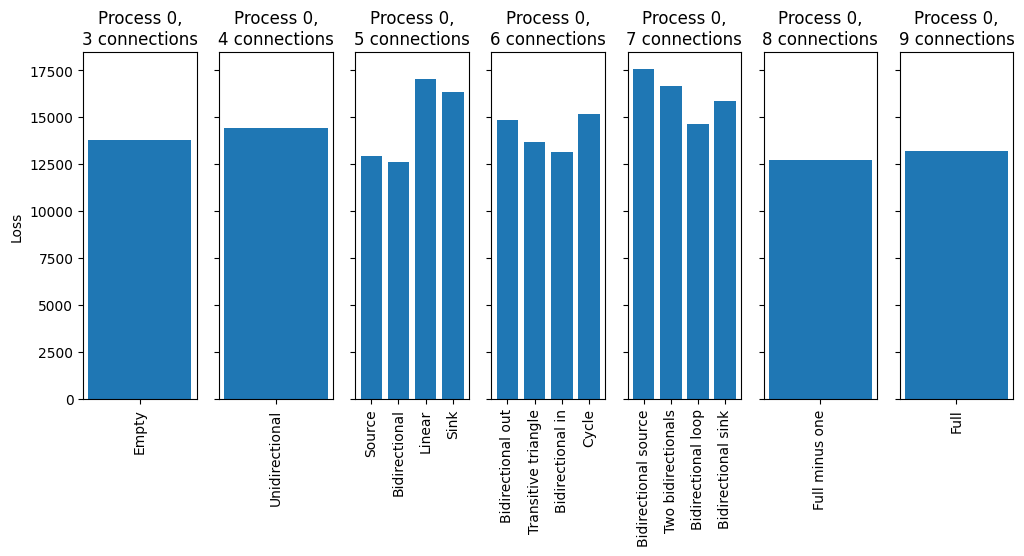

[{3: {'Empty': 13794.501514495507},
  4: {'Unidirectional': 14429.827334066958},
  5: {'Source': 12922.951290153454,
   'Bidirectional': 12640.823643407382,
   'Linear': 17053.257494151312,
   'Sink': 16353.161925998462},
  6: {'Bidirectional out': 14865.199059040233,
   'Transitive triangle': 13663.51259696866,
   'Bidirectional in': 13123.37834893604,
   'Cycle': 15195.435634178608},
  7: {'Bidirectional source': 17573.56022022789,
   'Two bidirectionals': 16669.229733766428,
   'Bidirectional loop': 14654.386996683845,
   'Bidirectional sink': 15864.754827972687},
  8: {'Full minus one': 12725.302236007983},
  9: {'Full': 13220.920679817093}}]

In [61]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-6), np.full(15, 1e-7), np.full(30, 3e-8), np.full(30, 1e-8))),
           A=np.array([[0.8, 0, 0],[0.8, 0.8, 0], [0.8, -0.8, 0.8]]))

### Transitive triangle with loops, all positive connections

In [66]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0.8, 0, 0],[0.8, 0.8, 0], [0.8, 0.8, 0.8]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 5e-6), np.full(15, 1e-7), np.full(40, 1e-8), np.full(20, 1e-9))))

Process dynamics: [[0.8 0.  0. ]
 [0.8 0.8 0. ]
 [0.8 0.8 0.8]]
Eigenvalues: [0.8 0.8 0.8]
Kalman filter M: [[ 0.47360177 -0.1043154  -0.04853596]
 [ 0.32563549  0.38141492 -0.13263969]
 [ 0.19711075  0.24564672  0.3782864 ]]
Kalman filter K: [[0.27760354 0.06972429 0.06066996]
 [0.06972429 0.35743174 0.16579961]
 [0.06066996 0.16579961 0.52714199]]
Kalman filter loss: 9152.05616572838


  0%|                                                                   | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.07925453 0.         0.        ]
 [0.         0.12895239 0.        ]
 [0.         0.         0.24021667]]
NN K: [[ 0.28200583  0.38282966  0.20461136]
 [-0.11583015  0.43020014  0.24703659]
 [ 0.20938115  0.2992247   0.40728269]]
NN W: [[ 0.50905149 -0.14391838 -0.12109945]
 [ 0.18469189  0.84190034 -0.28731244]
 [-0.09205993  0.50885496  1.33709396]]
Loss: 23021.933575128947
Testing Empty, Trial 2
NN M: [[-0.47051799  0.          0.        ]
 [ 0.          0.04230189  0.        ]
 [ 0.          0.          0.40734621]]
NN K: [[ 0.37702262  0.09724889 -0.02692177]
 [ 0.26151574  0.31547693  0.28057762]
 [ 0.48764402  0.25433113  0.4215853 ]]
NN W: [[ 0.2607107   0.02124278  0.01817487]
 [ 0.15763897  0.95121928 -0.18488454]
 [ 0.07707858  0.22583948  1.11490141]]
Loss: 21767.9518531777
Testing Empty, Trial 3


  6%|███▋                                                      | 1/16 [01:54<28:31, 114.12s/it]

NN M: [[-0.73370577  0.          0.        ]
 [ 0.          0.03364439  0.        ]
 [ 0.          0.          0.36848562]]
NN K: [[ 0.55956209 -0.11154984 -0.00625937]
 [ 0.32976091  0.33805382  0.25864275]
 [ 0.30164783  0.28959317  0.40030694]]
NN W: [[ 0.19563961  0.0961248  -0.0107785 ]
 [-0.10253488  0.95542134 -0.18073246]
 [-0.00290308  0.26779481  1.22463535]]
Loss: 20879.336746934383
Testing Unidirectional, Trial 1
NN M: [[0.01445297 0.         0.        ]
 [0.10450347 0.26023773 0.        ]
 [0.         0.         0.1911342 ]]
NN K: [[ 0.15478374  0.2115913  -0.19140793]
 [ 0.42110938  0.28315686  0.24517665]
 [ 0.0706095   0.26551612  0.41405226]]
NN W: [[ 0.78067913  0.28081628  0.05878037]
 [ 0.07209125  0.85696299 -0.24184328]
 [-0.48874099  0.471962    1.26487164]]
Loss: 20762.535435957903
Testing Unidirectional, Trial 2
NN M: [[-0.30306079  0.          0.        ]
 [ 0.31632411  0.04661928  0.        ]
 [ 0.          0.          0.43898615]]
NN K: [[0.23897438 0.135448

 12%|███████▎                                                  | 2/16 [03:47<26:28, 113.50s/it]

NN M: [[-0.27154011  0.          0.        ]
 [ 0.23734179  0.19363047  0.        ]
 [ 0.          0.          0.1935884 ]]
NN K: [[0.46475299 0.208852   0.01188025]
 [0.33945041 0.20173964 0.3112167 ]
 [0.35902694 0.1144577  0.46845194]]
NN W: [[ 0.72130001 -0.09619242  0.05917152]
 [ 0.14577166  0.8478145  -0.32668969]
 [-0.14590567  0.47591948  1.25895027]]
Loss: 24239.88509073089
Testing Source, Trial 1
NN M: [[-0.37648135  0.          0.        ]
 [ 0.0196127  -0.09616448  0.        ]
 [-0.11295329  0.          0.40217186]]
NN K: [[0.09206442 0.24595999 0.0079105 ]
 [0.36087569 0.24691802 0.23552078]
 [0.1405491  0.37509646 0.38496738]]
NN W: [[ 0.41574558  0.31695963 -0.08759975]
 [ 0.24338896  0.68848792 -0.00522243]
 [ 0.1027078   0.11013008  1.2583259 ]]
Loss: 21195.436151184713
Testing Source, Trial 2
NN M: [[0.01492409 0.         0.        ]
 [0.08176314 0.00069837 0.        ]
 [0.29404485 0.         0.29201644]]
NN K: [[0.118847   0.26237167 0.20502122]
 [0.48686814 0.39593

 19%|██████████▉                                               | 3/16 [05:36<24:09, 111.50s/it]

NN M: [[-0.51857142  0.          0.        ]
 [-0.10804151 -0.10748224  0.        ]
 [-0.02638283  0.          0.40975899]]
NN K: [[ 0.23458635 -0.05241719  0.0920664 ]
 [ 0.44421812  0.37219675  0.31169034]
 [ 0.36765656  0.25165221  0.4268536 ]]
NN W: [[ 0.35272237  0.02344633 -0.00789826]
 [-0.04589469  0.95808048 -0.16903232]
 [-0.08651981  0.25492081  1.11032045]]
Loss: 20904.199533404528
Testing Bidirectional, Trial 1
NN M: [[-0.34306903 -0.00897778  0.        ]
 [ 0.22488476  0.07042568  0.        ]
 [ 0.          0.          0.22461858]]
NN K: [[ 0.41261635  0.19080095 -0.0777884 ]
 [ 0.35220041  0.24301649  0.28421631]
 [ 0.33608334  0.1495487   0.4726262 ]]
NN W: [[ 0.66093899  0.08606444  0.02539849]
 [ 0.11040477  0.9407366  -0.21386797]
 [-0.22924059  0.39927158  1.28211439]]
Loss: 20465.60787435757
Testing Bidirectional, Trial 2
NN M: [[-0.30031511  0.10880693  0.        ]
 [ 0.00154889  0.01812151  0.        ]
 [ 0.          0.          0.3246653 ]]
NN K: [[ 0.33274126 -

 25%|██████████████▌                                           | 4/16 [07:20<21:43, 108.63s/it]

NN M: [[-0.30973072  0.05848353  0.        ]
 [-0.29026612 -0.00658424  0.        ]
 [ 0.          0.          0.36105861]]
NN K: [[ 0.04339131 -0.00268609 -0.12577888]
 [ 0.19741021  0.26208542  0.30913305]
 [ 0.20232907  0.24974091  0.394138  ]]
NN W: [[ 0.53753561  0.08911639  0.05061808]
 [ 0.04181731  0.87642081 -0.19701504]
 [-0.2841617   0.27454261  1.23553439]]
Loss: 22252.378819824364
Testing Linear, Trial 1
NN M: [[-0.32392842  0.          0.        ]
 [ 0.16928003  0.05887228  0.        ]
 [ 0.          0.33511412  0.25763246]]
NN K: [[ 0.19461464  0.09172082 -0.14856965]
 [ 0.28190457  0.38110004  0.34978817]
 [ 0.143657    0.16539982  0.32222747]]
NN W: [[ 0.47458925  0.11208422  0.03286459]
 [-0.14637656  0.83935124 -0.27428394]
 [-0.31801198  0.31059906  1.2070623 ]]
Loss: 17396.41377691145
Testing Linear, Trial 2
NN M: [[-0.08564923  0.          0.        ]
 [ 0.11849973 -0.06679519  0.        ]
 [ 0.          0.08244725  0.27197978]]
NN K: [[ 0.45910477  0.1111955  -0.

 31%|██████████████████▏                                       | 5/16 [09:10<19:59, 109.01s/it]

NN M: [[-0.02444879  0.          0.        ]
 [ 0.11627373 -0.57490915  0.        ]
 [ 0.          0.05223999  0.3229484 ]]
NN K: [[0.01269752 0.17679682 0.25251524]
 [0.09545171 0.32412319 0.2629988 ]
 [0.25649847 0.24267298 0.40901535]]
NN W: [[ 0.73459856  0.23370693 -0.32332367]
 [ 0.03392801  0.65513573  0.03556043]
 [ 0.3299157   0.04076084  1.27341659]]
Loss: 23207.328537205245
Testing Sink, Trial 1
NN M: [[-0.35888303  0.          0.        ]
 [-0.01251935 -0.06178863  0.09592573]
 [ 0.          0.          0.35973115]]
NN K: [[ 0.4246449  -0.08983931 -0.03034494]
 [ 0.19636004  0.44360613  0.19191048]
 [ 0.16148608  0.290636    0.42973234]]
NN W: [[ 0.5766337  -0.06052288  0.08080624]
 [ 0.21339527  0.87048382 -0.11924697]
 [-0.28194593  0.18198113  1.20795808]]
Loss: 19972.148810644132
Testing Sink, Trial 2
NN M: [[-0.64928229  0.          0.        ]
 [-0.10236092  0.12742663  0.04624787]
 [ 0.          0.          0.23813143]]
NN K: [[ 0.41520897  0.19387411 -0.07612825]
 [

 38%|█████████████████████▊                                    | 6/16 [11:00<18:15, 109.58s/it]

NN M: [[-0.20544874  0.          0.        ]
 [ 0.17224004 -0.07191953  0.15315444]
 [ 0.          0.          0.39093243]]
NN K: [[0.33775424 0.23408533 0.0435208 ]
 [0.50998944 0.17455983 0.31365149]
 [0.09493329 0.33086033 0.48226045]]
NN W: [[ 0.32507102  0.04529598 -0.02570735]
 [ 0.077       0.70447979 -0.17158865]
 [-0.20272309 -0.02789269  1.13510671]]
Loss: 20432.762424916484
Testing Bidirectional out, Trial 1
NN M: [[-0.17984721 -0.15603057  0.        ]
 [ 0.43271008  0.00956602  0.        ]
 [-0.06938246  0.          0.36041649]]
NN K: [[ 0.17544811  0.10261099 -0.03500609]
 [ 0.19522141  0.41005107  0.30989935]
 [ 0.23790081  0.20533366  0.4383505 ]]
NN W: [[ 0.62637597  0.02991554  0.07182141]
 [ 0.13278208  0.84933426 -0.14867792]
 [-0.26564173  0.2896854   1.14174437]]
Loss: 15578.338751973537
Testing Bidirectional out, Trial 2
NN M: [[-0.18943678  0.26439959  0.        ]
 [-0.00409591  0.12422206  0.        ]
 [ 0.20434185  0.         -0.00671123]]
NN K: [[0.31447378 0.

 44%|█████████████████████████▍                                | 7/16 [12:54<16:38, 110.89s/it]

NN M: [[-0.41847751  0.13020285  0.        ]
 [ 0.29591346  0.04176261  0.        ]
 [ 0.0064961   0.          0.34201878]]
NN K: [[0.16833249 0.0707607  0.13979217]
 [0.33282311 0.29709091 0.385781  ]
 [0.32665214 0.29175301 0.31323459]]
NN W: [[ 0.38057857 -0.03666966 -0.03326471]
 [-0.33718073  0.78347536 -0.27508191]
 [ 0.12811144  0.40585168  1.31260802]]
Loss: 33780.95414944495
Testing Transitive triangle, Trial 1
NN M: [[-0.53948799  0.          0.        ]
 [ 0.05457676  0.02439871  0.        ]
 [ 0.11409667  0.2336651   0.22352048]]
NN K: [[0.45555423 0.29802494 0.01363956]
 [0.01238971 0.27462825 0.26998287]
 [0.2168456  0.2818044  0.37276426]]
NN W: [[ 0.50450832  0.19072412 -0.08248233]
 [ 0.22612935  0.97710968 -0.20971921]
 [-0.0919637   0.43366739  1.27304044]]
Loss: 23404.908952470356
Testing Transitive triangle, Trial 2
NN M: [[ 0.10877457  0.          0.        ]
 [-0.00987874 -0.19891529  0.        ]
 [-0.41326264  0.18985919  0.13562736]]
NN K: [[ 0.10039475 -0.0292

 50%|█████████████████████████████                             | 8/16 [14:46<14:51, 111.40s/it]

NN M: [[ 0.11650836  0.          0.        ]
 [ 0.00718627 -0.36292144  0.        ]
 [ 0.38515658 -0.16361633  0.15405463]]
NN K: [[ 0.26203275  0.35044097  0.276837  ]
 [ 0.55275344  0.08268258 -0.04779726]
 [ 0.1858904   0.35485172  0.40175187]]
NN W: [[ 0.63736094 -0.16795042 -0.30343988]
 [ 0.15817713  0.81791102  0.18574773]
 [ 0.12372498 -0.26020843  1.25788474]]
Loss: 28547.25985077468
Testing Bidirectional in, Trial 1
NN M: [[-0.14313693 -0.058236    0.12605055]
 [ 0.01246996  0.06864943  0.        ]
 [ 0.          0.          0.226619  ]]
NN K: [[ 0.01076251 -0.02027787  0.29776902]
 [ 0.09583441  0.37551176  0.14106935]
 [ 0.20986888  0.22955317  0.33447409]]
NN W: [[ 0.47045492 -0.21020345 -0.12715147]
 [ 0.03861321  1.03827399 -0.12090176]
 [ 0.54378114  0.51527427  1.41854759]]
Loss: 28245.80958232635
Testing Bidirectional in, Trial 2
NN M: [[-0.15515975  0.20385846 -0.06638091]
 [-0.02868999 -0.06943163  0.        ]
 [ 0.          0.          0.3362075 ]]
NN K: [[0.033514

 56%|████████████████████████████████▋                         | 9/16 [16:34<12:51, 110.20s/it]

NN M: [[-0.05410013 -0.06562605  0.01051755]
 [-0.01330599  0.06756174  0.        ]
 [ 0.          0.          0.150786  ]]
NN K: [[ 0.19788538  0.16840498  0.31335908]
 [ 0.12866277  0.39759632  0.23843747]
 [-0.19660473  0.22228381  0.40483802]]
NN W: [[ 0.7096992  -0.25815055 -0.21384842]
 [-0.08927069  0.96895154 -0.19750291]
 [ 0.497359    0.47366593  1.29680266]]
Loss: 22208.257462281596
Testing Cycle, Trial 1
NN M: [[-0.42254314  0.         -0.29523714]
 [-0.1830823  -0.04298329  0.        ]
 [ 0.         -0.52840542  0.29269052]]
NN K: [[ 0.18900933  0.06978172 -0.04513093]
 [ 0.10614233 -0.01623094 -0.25823524]
 [ 0.32477154  0.66376867  0.25212398]]
NN W: [[ 0.50439583 -0.26307879  0.06833635]
 [-0.11670299  0.50508074  0.37514715]
 [-0.16075841 -0.38650071  1.23303194]]
Loss: 36395.90991565095
Testing Cycle, Trial 2
NN M: [[-0.09403834  0.          0.03830167]
 [ 0.16364784  0.29399897  0.        ]
 [ 0.          0.28592985  0.07262302]]
NN K: [[0.24404166 0.19609119 0.28308

 62%|███████████████████████████████████▋                     | 10/16 [18:24<10:59, 109.98s/it]

NN M: [[-0.31235322  0.          0.0173329 ]
 [ 0.3306288  -0.03571584  0.        ]
 [ 0.         -0.01424383  0.19041856]]
NN K: [[0.43003918 0.25701207 0.07338303]
 [0.34986725 0.3620555  0.0961668 ]
 [0.07898607 0.28050279 0.45448291]]
NN W: [[ 0.34623851 -0.10061438  0.00921329]
 [-0.08326765  0.81645342  0.05592129]
 [ 0.07449365  0.15611427  1.51820701]]
Loss: 20645.95703374838
Testing Bidirectional source, Trial 1
NN M: [[-0.36220132  0.02663639  0.        ]
 [-0.21636656  0.09679211  0.        ]
 [ 0.13952023 -0.44400691  0.17768961]]
NN K: [[ 0.27299415 -0.21827758 -0.08145517]
 [ 0.28590315  0.02837427 -0.26696838]
 [ 0.32017583  0.49336015  0.40348329]]
NN W: [[ 0.46771239 -0.15736106  0.0181507 ]
 [-0.46720206  0.51724228  0.37018975]
 [-0.34006344 -0.3445918   1.18570284]]
Loss: 24118.6854652354
Testing Bidirectional source, Trial 2
NN M: [[-0.51729624 -0.06578051  0.        ]
 [ 0.10240715 -0.02254258  0.        ]
 [ 0.18077121  0.19438534  0.31122624]]
NN K: [[0.30766404

 69%|███████████████████████████████████████▏                 | 11/16 [20:12<09:07, 109.58s/it]

NN M: [[-0.4455916   0.35005248  0.        ]
 [-0.07763232  0.08592453  0.        ]
 [-0.20352025  0.04050318  0.23994657]]
NN K: [[ 0.40763804  0.30666589 -0.17143881]
 [ 0.2418692   0.39552312  0.22514091]
 [ 0.2197604   0.44046718  0.43803384]]
NN W: [[ 0.90818526 -0.09025044  0.06857303]
 [ 0.01606856  0.85454126 -0.13093481]
 [-0.12520052  0.26518017  1.27263946]]
Loss: 24586.183220062107
Testing Two bidirectionals, Trial 1
NN M: [[-0.15406378 -0.24998268 -0.06817268]
 [ 0.15161987  0.33558205  0.        ]
 [-0.1803715   0.          0.21464224]]
NN K: [[ 0.04675066  0.07141943 -0.12650137]
 [ 0.24508987  0.50160104  0.36956022]
 [ 0.04023189  0.41394694  0.23831627]]
NN W: [[ 0.59817239  0.16883889  0.16395006]
 [ 0.21880697  0.65673308 -0.36950251]
 [-0.37903969  0.43949168  1.28280298]]
Loss: 26886.930698486238
Testing Two bidirectionals, Trial 2
NN M: [[-0.65334184  0.01991771  0.0655596 ]
 [-0.11822895  0.17230187  0.        ]
 [ 0.08615454  0.          0.31446961]]
NN K: [[ 0

 75%|██████████████████████████████████████████▊              | 12/16 [21:59<07:15, 108.85s/it]

NN M: [[ 0.04378343 -0.08933504  0.0346433 ]
 [-0.22472956 -0.10569966  0.        ]
 [ 0.20186286  0.          0.22180454]]
NN K: [[ 0.19846332  0.19276174  0.28462045]
 [ 0.20577538  0.23727363 -0.10546783]
 [ 0.35832468  0.35566133  0.36279049]]
NN W: [[ 0.6256016   0.16643047 -0.27782589]
 [ 0.24156849  0.79294927  0.30844213]
 [ 0.22222072 -0.38190018  1.29114177]]
Loss: 23068.012220415487
Testing Bidirectional loop, Trial 1
NN M: [[-0.19225035  0.08455622  0.        ]
 [ 0.30747991 -0.06702432 -0.07978229]
 [-0.09197017  0.          0.34935451]]
NN K: [[0.03065714 0.30283869 0.14440311]
 [0.40017354 0.3109714  0.26576291]
 [0.30037973 0.2059562  0.48291592]]
NN W: [[ 0.57039834 -0.04219163 -0.08631517]
 [ 0.19532551  0.87340491 -0.14700586]
 [-0.02867162  0.27699362  1.16072132]]
Loss: 17900.663983091894
Testing Bidirectional loop, Trial 2
NN M: [[-0.1109574   0.11952829  0.        ]
 [ 0.08209686 -0.0465417   0.03250069]
 [ 0.26384126  0.          0.19132154]]
NN K: [[0.28311573 

 81%|██████████████████████████████████████████████▎          | 13/16 [23:52<05:30, 110.02s/it]

NN M: [[-0.29901172  0.32283624  0.        ]
 [ 0.42862337 -0.30289699  0.04063872]
 [ 0.03385496  0.          0.39494044]]
NN K: [[0.37390124 0.18161657 0.19594977]
 [0.663078   0.24399523 0.11444891]
 [0.20248242 0.30444294 0.40775117]]
NN W: [[ 0.51658543 -0.01555946 -0.116132  ]
 [ 0.17062989  0.29905489  0.07667256]
 [ 0.11396595  0.0776995   1.19401592]]
Loss: 21756.350347978005
Testing Bidirectional sink, Trial 1
NN M: [[-0.71306183  0.          0.        ]
 [-0.09871869  0.08979038  0.03677777]
 [ 0.10725562  0.29365617  0.28577913]]
NN K: [[-0.31668008 -0.17159373  0.06204528]
 [ 0.17962408  0.3600225   0.30945562]
 [ 0.23912923  0.37840912  0.29811953]]
NN W: [[ 0.31304448  0.03956521 -0.00208325]
 [-0.3634555   0.87694123 -0.26566078]
 [ 0.10591977  0.30202193  1.18998356]]
Loss: 24517.025892276964
Testing Bidirectional sink, Trial 2
NN M: [[-0.34126887  0.          0.        ]
 [-0.12913991  0.45527475 -0.11474203]
 [ 0.0695432   0.34741491 -0.28703649]]
NN K: [[0.35740744 

 88%|█████████████████████████████████████████████████▉       | 14/16 [25:38<03:37, 108.67s/it]

NN M: [[-0.33108357  0.          0.        ]
 [ 0.30190396 -0.25195623  0.15781655]
 [-0.11841538  0.02249533  0.4127793 ]]
NN K: [[0.2717749  0.01522676 0.01766812]
 [0.27795663 0.24559052 0.00644102]
 [0.33115346 0.46337441 0.34355529]]
NN W: [[ 0.34983491  0.29470362 -0.02408746]
 [ 0.01102744  0.50094216  0.14481552]
 [ 0.27694471 -0.24342441  1.35214253]]
Loss: 27158.082290534523
Testing Full minus one, Trial 1
NN M: [[-0.12769574  0.32387335  0.10374089]
 [ 0.03985408 -0.08853939  0.        ]
 [ 0.1653172   0.19547013  0.35433102]]
NN K: [[ 0.04183203  0.09446548  0.26856214]
 [ 0.3308528   0.32256284 -0.04066947]
 [ 0.23828196  0.35337683  0.39926207]]
NN W: [[ 0.57022547 -0.13708157 -0.20198543]
 [-0.02206854  0.56560078  0.20290549]
 [ 0.03173686 -0.64581076  1.20245664]]
Loss: 20124.552937308097
Testing Full minus one, Trial 2
NN M: [[-0.57756528 -0.11722627 -0.09600649]
 [-0.02747755  0.16477322  0.        ]
 [-0.00355492  0.348007    0.07598806]]
NN K: [[ 0.02026546 -0.0093

 94%|█████████████████████████████████████████████████████▍   | 15/16 [27:29<01:49, 109.46s/it]

NN M: [[-0.05107578  0.09913273 -0.08685155]
 [ 0.08326726  0.12518563  0.        ]
 [ 0.28104926  0.34740293  0.21077229]]
NN K: [[0.14807041 0.2355233  0.27135085]
 [0.21027951 0.29144033 0.30331719]
 [0.00424119 0.34887416 0.23057122]]
NN W: [[ 0.68175682 -0.27791107 -0.06898457]
 [-0.08532842  0.91488174 -0.27069117]
 [ 0.25405253  0.32078206  1.13715197]]
Loss: 25630.949643576947
Testing Full, Trial 1
NN M: [[-3.62553678e-02 -1.03566108e-01 -3.38129240e-02]
 [ 3.48029258e-01  4.94768846e-05 -1.51688346e-01]
 [-5.58703178e-02  3.89212907e-01  3.88547593e-01]]
NN K: [[ 0.12759205  0.00558114 -0.15182531]
 [ 0.50805845  0.37685461  0.02486434]
 [ 0.31631471  0.22996884  0.44355762]]
NN W: [[ 0.67253722  0.30675571  0.20014705]
 [-0.17690714  0.52565753  0.2480787 ]
 [-0.05841661 -0.75943603  1.17538425]]
Loss: 15551.937895085135
Testing Full, Trial 2
NN M: [[-0.49084383  0.12273138 -0.10195979]
 [ 0.07884916  0.15509766  0.06090596]
 [ 0.15075441  0.36977079  0.28437545]]
NN K: [[0.2

100%|█████████████████████████████████████████████████████████| 16/16 [29:17<00:00, 109.84s/it]

NN M: [[-0.32294509 -0.0474964   0.27790187]
 [-0.04679261 -0.00445772  0.1113321 ]
 [-0.0140003   0.29906857  0.16619329]]
NN K: [[-0.07965679 -0.02274212  0.01383275]
 [ 0.41466527  0.40382784  0.30767013]
 [ 0.13293987  0.26115849  0.34819205]]
NN W: [[ 5.43688605e-01 -1.13929179e-01  4.99000055e-05]
 [-4.09840833e-01  8.69768883e-01 -2.39337304e-01]
 [ 1.47533187e-01  3.57530935e-01  1.24823588e+00]]
Loss: 25318.38260299329


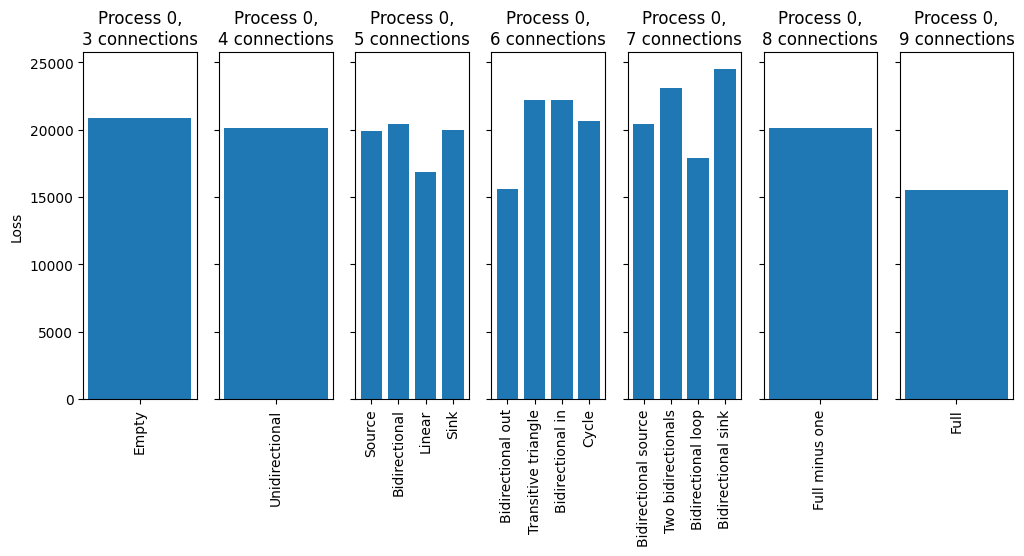

[{3: {'Empty': 20879.336746934383},
  4: {'Unidirectional': 20157.361068186183},
  5: {'Source': 19888.687436890243,
   'Bidirectional': 20419.716075090688,
   'Linear': 16846.78322094591,
   'Sink': 19972.148810644132},
  6: {'Bidirectional out': 15578.338751973537,
   'Transitive triangle': 22242.167819409868,
   'Bidirectional in': 22208.257462281596,
   'Cycle': 20645.95703374838},
  7: {'Bidirectional source': 20389.843037262,
   'Two bidirectionals': 23068.012220415487,
   'Bidirectional loop': 17900.663983091894,
   'Bidirectional sink': 24517.025892276964},
  8: {'Full minus one': 20124.552937308097},
  9: {'Full': 15551.937895085135}}]

In [62]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 5e-6), np.full(15, 1e-7), np.full(40, 1e-8), np.full(20, 1e-9))),
           A=np.array([[0.8, 0, 0], [0.8, 0.8, 0], [0.8, 0.8, 0.8]]))

### Transitive triangle without loops, all positive connections

In [69]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0, 0, 0],[0.95, 0.0, 0], [0.95, 0.95, 0]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))))

Process dynamics: [[0.   0.   0.  ]
 [0.95 0.   0.  ]
 [0.95 0.95 0.  ]]
Eigenvalues: [0. 0. 0.]
Kalman filter M: [[ 0.          0.          0.        ]
 [ 0.60140889 -0.07174766  0.        ]
 [ 0.49686747  0.56861513  0.        ]]
Kalman filter K: [[0.2        0.         0.        ]
 [0.         0.29141415 0.07552386]
 [0.         0.07552386 0.40145775]]
Kalman filter loss: 8330.70803663842


  0%|                                                                   | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.02632916 0.         0.        ]
 [0.         0.15274366 0.        ]
 [0.         0.         0.2949569 ]]
NN K: [[ 0.19611804 -0.05347201 -0.10246315]
 [ 0.0256771   0.50862475  0.40058439]
 [ 0.04377092  0.778957    1.63139356]]
NN W: [[ 1.00749777  0.04131457  0.04426786]
 [-0.01545209  0.87936059 -0.16807903]
 [-0.00110621 -0.26788501  0.30824745]]
Loss: 9445.835080458399
Testing Empty, Trial 2
NN M: [[0.02464479 0.         0.        ]
 [0.         0.17693798 0.        ]
 [0.         0.         0.30281532]]
NN K: [[ 0.19513112 -0.02327072 -0.0435829 ]
 [ 0.02187402  0.53699397  0.45452467]
 [ 0.03568077  0.70893204  1.52109052]]
NN W: [[ 1.00974824  0.0162011   0.01994927]
 [ 0.00283126  0.86628326 -0.20812195]
 [ 0.00968488 -0.2499461   0.33566189]]
Loss: 10050.577929896182
Testing Empty, Trial 3


  6%|███▋                                                      | 1/16 [02:30<37:42, 150.82s/it]

NN M: [[-0.03999141  0.          0.        ]
 [ 0.          0.15724871  0.        ]
 [ 0.          0.          0.31233454]]
NN K: [[0.20249759 0.02081039 0.02201545]
 [0.01939365 0.48217257 0.34643435]
 [0.05142776 0.7820167  1.57950365]]
NN W: [[ 0.99747553 -0.02368441 -0.00565611]
 [-0.00227982  0.91527338 -0.1517283 ]
 [-0.03757837 -0.24485283  0.29787068]]
Loss: 9450.430115553962
Testing Unidirectional, Trial 1
NN M: [[0.00112791 0.         0.        ]
 [0.3232343  0.00374488 0.        ]
 [0.         0.         0.33081988]]
NN K: [[ 0.20769838 -0.04077364 -0.0371241 ]
 [ 0.0029787   0.32956738  0.09745768]
 [ 0.04128501  0.70994789  1.56704283]]
NN W: [[ 0.99907848  0.03819266  0.02207965]
 [ 0.00959142  0.9810059  -0.01311796]
 [ 0.01462821 -0.17781132  0.25173175]]
Loss: 9304.601784273818
Testing Unidirectional, Trial 2
NN M: [[-0.02927503  0.          0.        ]
 [ 0.3415632   0.02440174  0.        ]
 [ 0.          0.          0.33503117]]
NN K: [[ 0.20938607 -0.01817093 -0.001

 12%|███████▎                                                  | 2/16 [05:08<36:09, 155.00s/it]

NN M: [[-0.05160492  0.          0.        ]
 [ 0.33255245  0.02174876  0.        ]
 [ 0.          0.          0.32871489]]
NN K: [[ 0.21198699 -0.00408569  0.03098572]
 [ 0.01002451  0.36503294  0.17084665]
 [ 0.05394331  0.71829008  1.58413861]]
NN W: [[ 0.99428851  0.00782081 -0.01287794]
 [-0.02992952  0.96410199 -0.05801448]
 [-0.02278263 -0.1782342   0.257436  ]]
Loss: 9957.920928507418
Testing Source, Trial 1
NN M: [[-0.00545762  0.          0.        ]
 [ 0.50890213  0.09057862  0.        ]
 [ 0.77435055  0.          0.26610078]]
NN K: [[ 2.15837089e-01  7.55509747e-03 -1.13180695e-01]
 [-6.63738887e-04  4.04138560e-01  2.81679860e-01]
 [ 3.25839801e-04  2.79637202e-01  8.06628491e-01]]
NN W: [[ 0.97030186 -0.01102688  0.09653112]
 [ 0.01534569  0.89659596 -0.18960948]
 [-0.01705162 -0.14194379  0.62407608]]
Loss: 9152.63399050746
Testing Source, Trial 2
NN M: [[-0.00923067  0.          0.        ]
 [ 0.3984814   0.09102617  0.        ]
 [ 0.75036463  0.          0.30933092]]
N

 19%|██████████▉                                               | 3/16 [07:55<34:45, 160.41s/it]

NN M: [[0.02318839 0.         0.        ]
 [0.37290384 0.05953659 0.        ]
 [0.81380412 0.         0.28725724]]
NN K: [[ 0.21738875 -0.01362823 -0.14256556]
 [ 0.0022499   0.34831942  0.14904347]
 [-0.00891703  0.34677322  0.91792747]]
NN W: [[ 0.97948405 -0.00783475  0.10742754]
 [ 0.00360034  0.96650647 -0.05919285]
 [ 0.03178335 -0.17203188  0.52854209]]
Loss: 8878.270232768824
Testing Bidirectional, Trial 1
NN M: [[ 0.04205562 -0.05005945  0.        ]
 [ 0.31222171  0.02229253  0.        ]
 [ 0.          0.          0.32249018]]
NN K: [[ 0.21344551 -0.07073045 -0.09505248]
 [ 0.0035585   0.30944899  0.0675948 ]
 [ 0.03190191  0.67852389  1.54649091]]
NN W: [[ 0.97828539  0.04415766  0.05776742]
 [-0.00346303  0.98400178  0.01010182]
 [ 0.02030653 -0.15092583  0.25620417]]
Loss: 9357.90003380295
Testing Bidirectional, Trial 2
NN M: [[-0.0745421   0.04967821  0.        ]
 [ 0.40215721 -0.05150934  0.        ]
 [ 0.          0.          0.33008732]]
NN K: [[0.2061748  0.01155021 0.

 25%|██████████████▌                                           | 4/16 [10:38<32:17, 161.42s/it]

NN M: [[-0.06086484  0.03256951  0.        ]
 [ 0.2893679   0.00875978  0.        ]
 [ 0.          0.          0.32907526]]
NN K: [[ 0.21029397 -0.00172428  0.02733987]
 [ 0.0131918   0.36160416  0.1540496 ]
 [ 0.04772483  0.73988715  1.63549824]]
NN W: [[ 0.99063289  0.00729498 -0.0131221 ]
 [-0.02336737  0.95220119 -0.04531365]
 [-0.01513054 -0.21827859  0.25482435]]
Loss: 10104.272013488662
Testing Linear, Trial 1
NN M: [[-0.02990702  0.          0.        ]
 [ 0.43925657  0.04361732  0.        ]
 [ 0.          0.83345692  0.05939285]]
NN K: [[ 0.21004655 -0.04227108 -0.06102885]
 [ 0.03910946  0.33442382  0.12321738]
 [ 0.01153831  0.38527534  0.99726778]]
NN W: [[ 0.99622037  0.05290736  0.04724041]
 [-0.03374653  0.95724643 -0.04762037]
 [ 0.02333999 -0.14333978  0.47251689]]
Loss: 8629.539020107059
Testing Linear, Trial 2
NN M: [[-0.04780184  0.          0.        ]
 [ 0.46577616 -0.00595622  0.        ]
 [ 0.          0.79993466  0.12854247]]
NN K: [[ 0.21264458 -0.03411602 -0.

 31%|██████████████████▏                                       | 5/16 [13:18<29:29, 160.86s/it]

NN M: [[-0.02116019  0.          0.        ]
 [ 0.40943585  0.04314411  0.        ]
 [ 0.          0.74402653  0.12551874]]
NN K: [[ 0.21328284 -0.03956119 -0.04833944]
 [ 0.03149618  0.35048293  0.1396394 ]
 [ 0.01358018  0.47506404  1.20201982]]
NN W: [[ 0.99634393  0.03249352  0.03392136]
 [-0.01631557  0.97160507 -0.05480252]
 [ 0.01832368 -0.1587913   0.37868643]]
Loss: 9313.397513700274
Testing Sink, Trial 1
NN M: [[-0.02900509  0.          0.        ]
 [ 0.40029633 -0.03858155  0.02160955]
 [ 0.          0.          0.33083245]]
NN K: [[0.21392814 0.01026851 0.03118267]
 [0.00203918 0.37043433 0.18338757]
 [0.04075644 0.67147738 1.52766021]]
NN W: [[ 0.97148842 -0.04348207 -0.00741348]
 [ 0.00794241  0.95530062 -0.07371047]
 [-0.01952738 -0.17910871  0.27073014]]
Loss: 9631.143372638411
Testing Sink, Trial 2
NN M: [[ 0.00301291  0.          0.        ]
 [ 0.34723371 -0.02833313  0.02242011]
 [ 0.          0.          0.31950671]]
NN K: [[ 0.21425237 -0.06992573 -0.12536039]
 [ 0

 38%|█████████████████████▊                                    | 6/16 [15:48<26:12, 157.23s/it]

NN M: [[-0.05564897  0.          0.        ]
 [ 0.36439668 -0.03641524  0.02638846]
 [ 0.          0.          0.3275359 ]]
NN K: [[0.21539499 0.00467959 0.0436829 ]
 [0.0059478  0.38768051 0.20982899]
 [0.05688433 0.67489088 1.53311552]]
NN W: [[ 0.96528249 -0.01254941 -0.01579714]
 [ 0.01106255  0.94981788 -0.08876472]
 [-0.02441044 -0.20997893  0.28216965]]
Loss: 9401.864866641137
Testing Bidirectional out, Trial 1
NN M: [[ 0.02430765 -0.04399617  0.        ]
 [ 0.41921399  0.05437853  0.        ]
 [ 0.85580624  0.          0.26189352]]
NN K: [[ 0.22287378  0.03445965 -0.0385599 ]
 [ 0.00398211  0.39320086  0.22212794]
 [ 0.00662752  0.39435421  1.0004363 ]]
NN W: [[ 0.96014644 -0.05537272  0.03569137]
 [-0.00657366  0.93242406 -0.11955843]
 [-0.02358894 -0.18137159  0.47856972]]
Loss: 9291.286165088244
Testing Bidirectional out, Trial 2
NN M: [[ 0.01900608 -0.05112213  0.        ]
 [ 0.48282619  0.09698986  0.        ]
 [ 0.76072255  0.          0.25904146]]
NN K: [[ 0.21190755  0.

 44%|█████████████████████████▍                                | 7/16 [18:29<23:44, 158.27s/it]

NN M: [[ 0.01607707 -0.06448032  0.        ]
 [ 0.42699197  0.05536691  0.        ]
 [ 0.79525074  0.          0.2775309 ]]
NN K: [[ 0.22185033  0.00264852 -0.07211631]
 [ 0.01332634  0.3667868   0.17371091]
 [-0.0085985   0.3112931   0.81633031]]
NN W: [[ 0.94976465  0.00964874  0.06437175]
 [-0.05134715  0.92629349 -0.08931549]
 [ 0.02369734 -0.1601172   0.59460441]]
Loss: 9194.068776822378
Testing Transitive triangle, Trial 1
NN M: [[-0.00776359  0.          0.        ]
 [ 0.47119175  0.02651692  0.        ]
 [ 0.62437958  0.47278153  0.04587996]]
NN K: [[ 0.21536333 -0.00445604 -0.0433582 ]
 [-0.00286781  0.38382716  0.16722444]
 [ 0.0117494   0.13220647  0.53977522]]
NN W: [[ 0.97037708 -0.01701873  0.04365767]
 [-0.0185502   0.88698782 -0.09846099]
 [-0.05622416 -0.05662371  0.81210546]]
Loss: 8423.915957336892
Testing Transitive triangle, Trial 2
NN M: [[-0.02890897  0.          0.        ]
 [ 0.48523362 -0.03163813  0.        ]
 [ 0.48745504  0.55158517  0.09429401]]
NN K: [[ 0

 50%|█████████████████████████████                             | 8/16 [21:02<20:53, 156.72s/it]

NN M: [[-0.04652317  0.          0.        ]
 [ 0.46720393  0.04612646  0.        ]
 [ 0.56823721  0.47174979  0.11070228]]
NN K: [[ 0.22005319 -0.04129969 -0.10500001]
 [ 0.00928818  0.34454366  0.12599396]
 [ 0.00514268  0.16437427  0.57870258]]
NN W: [[ 0.95916202  0.05085996  0.11374903]
 [-0.03585081  0.94492046 -0.05655455]
 [-0.02016246 -0.08803904  0.77977581]]
Loss: 8325.455994428714
Testing Bidirectional in, Trial 1
NN M: [[-0.01156945 -0.00193336  0.00432353]
 [ 0.44490724 -0.03798007  0.        ]
 [ 0.          0.          0.34244945]]
NN K: [[ 0.20907216 -0.01224817  0.01989918]
 [ 0.00522754  0.32307009  0.08724866]
 [ 0.03866523  0.64268809  1.50494692]]
NN W: [[ 9.89888985e-01  2.03937281e-02 -1.12463956e-02]
 [ 3.30346044e-04  9.78939181e-01 -1.29309722e-02]
 [ 1.32706488e-02 -1.37946566e-01  2.58886700e-01]]
Loss: 9533.404127473248
Testing Bidirectional in, Trial 2
NN M: [[-0.07384105  0.03147235  0.00894014]
 [ 0.34401482  0.03954911  0.        ]
 [ 0.          0.   

 56%|████████████████████████████████▋                         | 9/16 [23:37<18:12, 156.12s/it]

NN M: [[-0.06593679  0.0477913   0.00830046]
 [ 0.39646286 -0.00978906  0.        ]
 [ 0.          0.          0.32220831]]
NN K: [[0.21046514 0.02467477 0.06163133]
 [0.00454666 0.36639081 0.19380459]
 [0.03132573 0.65669073 1.53065897]]
NN W: [[ 0.98745001 -0.0161718  -0.03715504]
 [ 0.00580461  0.96751817 -0.07898439]
 [-0.01378274 -0.18089674  0.27692491]]
Loss: 9283.253382534094
Testing Cycle, Trial 1
NN M: [[-0.01852188  0.         -0.00812665]
 [ 0.4201483   0.05018975  0.        ]
 [ 0.          0.78115272  0.10141114]]
NN K: [[ 0.20986095 -0.04514461 -0.05129807]
 [ 0.03438374  0.35494985  0.1276305 ]
 [ 0.01011796  0.42287267  1.08013627]]
NN W: [[ 0.99202641  0.04551251  0.04277094]
 [-0.02763992  0.95552953 -0.04840441]
 [ 0.03775254 -0.12489447  0.42118309]]
Loss: 9217.594021637226
Testing Cycle, Trial 2
NN M: [[-0.04359717  0.         -0.00566372]
 [ 0.45789197 -0.01204796  0.        ]
 [ 0.          0.85717296  0.11060251]]
NN K: [[ 0.20894327 -0.0206192  -0.024296  ]
 [

 62%|███████████████████████████████████▋                     | 10/16 [26:13<15:36, 156.04s/it]

NN M: [[-0.01701599  0.         -0.01281605]
 [ 0.38039776  0.10965914  0.        ]
 [ 0.          0.73262194  0.0513182 ]]
NN K: [[ 0.20878538 -0.05498627 -0.07509598]
 [ 0.03645406  0.42605716  0.25470721]
 [ 0.01639572  0.49514969  1.19522117]]
NN W: [[ 0.99465848  0.05170203  0.05322227]
 [-0.02196239  0.87990671 -0.12679152]
 [ 0.03000172 -0.18626285  0.40620964]]
Loss: 9172.026227691778
Testing Bidirectional source, Trial 1
NN M: [[-0.02411009 -0.06048241  0.        ]
 [ 0.44000871  0.026309    0.        ]
 [ 0.60115637  0.46040872  0.12642611]]
NN K: [[ 0.2172847  -0.02066743 -0.05080569]
 [ 0.00868375  0.34169072  0.09564864]
 [ 0.00194913  0.21232476  0.63138323]]
NN W: [[ 0.97278641  0.00896021  0.06869268]
 [-0.0370013   0.95572794 -0.02138157]
 [-0.0113778  -0.14568617  0.72960359]]
Loss: 8950.973501840765
Testing Bidirectional source, Trial 2
NN M: [[-0.01782287 -0.06356457  0.        ]
 [ 0.47068222  0.01254007  0.        ]
 [ 0.52054832  0.54150907  0.07682354]]
NN K: [[

 69%|███████████████████████████████████████▏                 | 11/16 [28:49<13:00, 156.19s/it]

NN M: [[-0.04272978 -0.0403762   0.        ]
 [ 0.48219354  0.04023084  0.        ]
 [ 0.61127009  0.52650436  0.08596185]]
NN K: [[ 0.22290421 -0.01507807 -0.03602699]
 [ 0.01338096  0.37380978  0.14941046]
 [ 0.01234886  0.27673493  0.74148609]]
NN W: [[ 0.98672805  0.01322004  0.0424826 ]
 [-0.02692718  0.90937979 -0.07527602]
 [-0.01549354 -0.19276949  0.64316757]]
Loss: 9077.507429228272
Testing Two bidirectionals, Trial 1
NN M: [[ 0.01098833 -0.06225056 -0.00441026]
 [ 0.40067329  0.09178701  0.        ]
 [ 0.7169954   0.          0.27800299]]
NN K: [[ 0.22207675  0.01638868 -0.05694768]
 [ 0.00590213  0.36716526  0.18899725]
 [ 0.0147963   0.29287302  0.79187015]]
NN W: [[ 0.94295474 -0.01031353  0.05299288]
 [ 0.00387551  0.94897006 -0.1154485 ]
 [-0.04548542 -0.10260238  0.5953445 ]]
Loss: 9325.363410238317
Testing Two bidirectionals, Trial 2
NN M: [[-0.05660635  0.01848208 -0.03274952]
 [ 0.42681277  0.0191874   0.        ]
 [ 0.75422486  0.          0.29466784]]
NN K: [[ 0.2

 75%|██████████████████████████████████████████▊              | 12/16 [31:25<10:24, 156.03s/it]

NN M: [[-0.06266801  0.04696825 -0.04803165]
 [ 0.37910334  0.00670274  0.        ]
 [ 0.78434619  0.          0.29386435]]
NN K: [[ 0.22775033  0.00249355 -0.09579722]
 [ 0.00786909  0.31540473  0.07208679]
 [-0.00218828  0.33468639  0.8513806 ]]
NN W: [[ 0.94738175 -0.02018147  0.09037816]
 [-0.02750138  0.97636754  0.0139376 ]
 [ 0.02025157 -0.18235803  0.55631192]]
Loss: 9329.193704979401
Testing Bidirectional loop, Trial 1
NN M: [[ 0.0287323  -0.06580833  0.        ]
 [ 0.46926549  0.01911305  0.02111062]
 [ 0.83621547  0.          0.25263004]]
NN K: [[ 0.20784504  0.04884213 -0.05466883]
 [ 0.00166494  0.3799399   0.18692987]
 [ 0.0096344   0.20869679  0.64664947]]
NN W: [[ 0.9380037  -0.06650503  0.06560338]
 [-0.01683574  0.92321502 -0.12244044]
 [-0.0798565  -0.12513676  0.73882471]]
Loss: 9070.23698335886
Testing Bidirectional loop, Trial 2
NN M: [[-3.57839895e-04 -1.20867301e-01  0.00000000e+00]
 [ 3.81961313e-01  8.49561783e-02  6.91876935e-02]
 [ 7.35361220e-01  0.00000000

 81%|██████████████████████████████████████████████▎          | 13/16 [33:59<07:46, 155.53s/it]

NN M: [[ 0.01466218 -0.09237365  0.        ]
 [ 0.36264279  0.11133033 -0.00398511]
 [ 0.78457915  0.          0.30434721]]
NN K: [[ 0.2173418  -0.00329563 -0.10683823]
 [ 0.01614658  0.33080805  0.09676395]
 [-0.01123599  0.27813373  0.77059124]]
NN W: [[ 0.94636162 -0.00783719  0.10503709]
 [-0.04132515  0.94637733 -0.02088013]
 [ 0.00118352 -0.11167387  0.60803666]]
Loss: 8961.346414787666
Testing Bidirectional sink, Trial 1
NN M: [[-0.02314627  0.          0.        ]
 [ 0.46948715  0.01995592  0.01300708]
 [ 0.67832895  0.32633861  0.15020592]]
NN K: [[ 0.2106004  -0.01602568 -0.09037348]
 [-0.00138207  0.37414756  0.12989395]
 [ 0.00480119  0.1987378   0.56560483]]
NN W: [[ 0.96645658 -0.00221106  0.09570142]
 [ 0.00146333  0.91268687 -0.05564968]
 [-0.02176859 -0.16292828  0.81331554]]
Loss: 8608.42618095234
Testing Bidirectional sink, Trial 2
NN M: [[-0.00856558  0.          0.        ]
 [ 0.50773737  0.05072221  0.03130113]
 [ 0.57571772  0.4214005   0.06035248]]
NN K: [[ 0.21

 88%|█████████████████████████████████████████████████▉       | 14/16 [36:31<05:08, 154.33s/it]

NN M: [[-0.01651145  0.          0.        ]
 [ 0.43335929  0.11431447  0.01886487]
 [ 0.56939267  0.50701591  0.0882806 ]]
NN K: [[ 0.23217609 -0.0681949  -0.17415481]
 [ 0.00330774  0.3974391   0.20391544]
 [-0.00224905  0.23722827  0.69673279]]
NN W: [[ 0.92409255  0.03055171  0.15727374]
 [ 0.00962804  0.88887763 -0.1291893 ]
 [ 0.01214949 -0.15062027  0.6953092 ]]
Loss: 8611.273046417311
Testing Full minus one, Trial 1
NN M: [[-0.02387323 -0.02814709 -0.00511269]
 [ 0.47091566  0.04014921  0.        ]
 [ 0.58015786  0.53069772  0.08406671]]
NN K: [[ 0.23188105 -0.01416436 -0.03979729]
 [ 0.01126767  0.38161463  0.17470873]
 [-0.0107426   0.27493658  0.76776025]]
NN W: [[ 0.9274443   0.00263734  0.04277026]
 [-0.02871841  0.91708238 -0.09817663]
 [ 0.02060522 -0.1485571   0.61603349]]
Loss: 8880.913714495164
Testing Full minus one, Trial 2
NN M: [[-0.02306361 -0.06116554 -0.00650414]
 [ 0.41742254  0.07988587  0.        ]
 [ 0.63045037  0.35476378  0.15017663]]
NN K: [[ 0.22362153 

 94%|█████████████████████████████████████████████████████▍   | 15/16 [39:09<02:35, 155.42s/it]

NN M: [[ 0.00184707 -0.02114446 -0.00540802]
 [ 0.48415283  0.04404005  0.        ]
 [ 0.62661591  0.39814485  0.0881139 ]]
NN K: [[ 2.28338586e-01  2.96508813e-02 -2.47912437e-03]
 [ 1.65264646e-04  4.31585419e-01  2.41037204e-01]
 [-2.75774940e-02  2.24489889e-01  7.01211700e-01]]
NN W: [[ 0.92235974 -0.07108151  0.02426449]
 [-0.02185911  0.8665961  -0.16464446]
 [ 0.07648895 -0.05256247  0.63769468]]
Loss: 8882.880739826815
Testing Full, Trial 1
NN M: [[-0.01043391 -0.08751165  0.01320949]
 [ 0.4877414   0.03204628  0.0339706 ]
 [ 0.56168284  0.5623884   0.04395531]]
NN K: [[ 0.2253527  -0.02030919 -0.05622498]
 [ 0.00550686  0.40116481  0.21763223]
 [ 0.01206279  0.26907687  0.74364863]]
NN W: [[ 0.96771086  0.00136912  0.06571267]
 [-0.00685742  0.89120126 -0.14018298]
 [-0.0308281  -0.1773865   0.65357721]]
Loss: 8764.864711714934
Testing Full, Trial 2
NN M: [[-7.48584413e-02  5.69943084e-03 -2.93973187e-02]
 [ 3.81584750e-01  2.29387642e-02 -3.18277924e-04]
 [ 6.49848722e-01  4

100%|█████████████████████████████████████████████████████████| 16/16 [42:22<00:00, 158.92s/it]

NN M: [[-0.05775504 -0.01763559 -0.01486013]
 [ 0.41060091  0.09120637  0.00415156]
 [ 0.60348509  0.59881049  0.08265565]]
NN K: [[ 0.23290558 -0.02296825 -0.04611693]
 [ 0.02718806  0.41824978  0.20381335]
 [-0.00096551  0.37368596  0.90717612]]
NN W: [[ 0.94773471  0.01142029  0.04365979]
 [-0.06104843  0.87063907 -0.11177682]
 [ 0.03160106 -0.22665035  0.53614368]]
Loss: 8836.71408031078


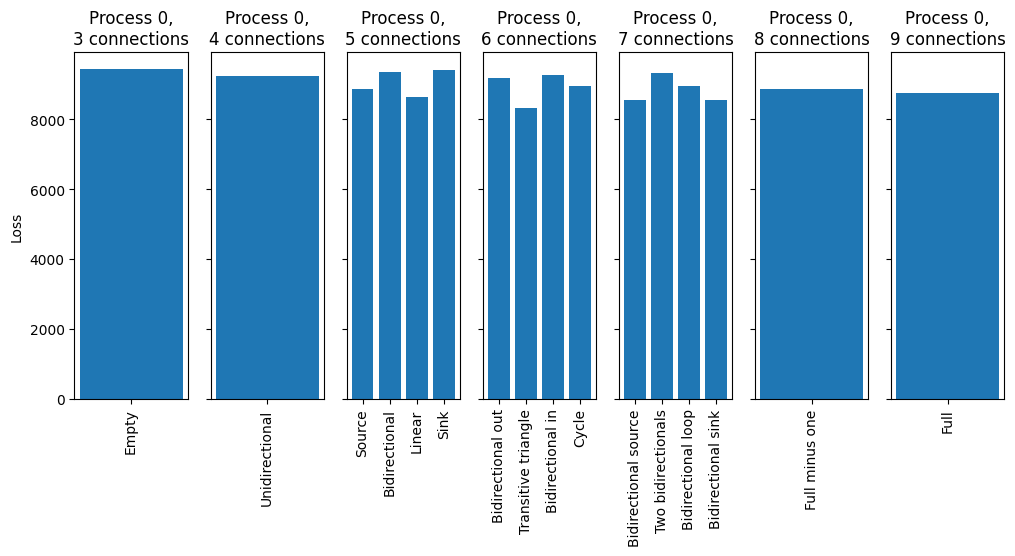

[{3: {'Empty': 9445.835080458399},
  4: {'Unidirectional': 9241.997837949304},
  5: {'Source': 8878.270232768824,
   'Bidirectional': 9357.90003380295,
   'Linear': 8629.539020107059,
   'Sink': 9401.864866641137},
  6: {'Bidirectional out': 9194.068776822378,
   'Transitive triangle': 8325.455994428714,
   'Bidirectional in': 9283.253382534094,
   'Cycle': 8955.308400616937},
  7: {'Bidirectional source': 8558.975603977273,
   'Two bidirectionals': 9325.363410238317,
   'Bidirectional loop': 8961.346414787666,
   'Bidirectional sink': 8566.894834783572},
  8: {'Full minus one': 8880.913714495164},
  9: {'Full': 8764.864711714934}}]

In [70]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))),
           A=np.array([[0, 0, 0], [0.95, 0, 0], [0.95, 0.95, 0]]))

### Transitive triangle without loops, one negative connection

In [72]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0, 0, 0],[0.95, 0.0, 0], [0.95, -0.95, 0]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))))

Process dynamics: [[ 0.    0.    0.  ]
 [ 0.95  0.    0.  ]
 [ 0.95 -0.95  0.  ]]
Eigenvalues: [0. 0. 0.]
Kalman filter M: [[ 0.          0.          0.        ]
 [ 0.60140889  0.07174766  0.        ]
 [ 0.49686747 -0.56861513  0.        ]]
Kalman filter K: [[0.2        0.         0.        ]
 [0.         0.29141415 0.07552386]
 [0.         0.07552386 0.40145775]]
Kalman filter loss: 8539.18538515073


  0%|                                                                   | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[-0.0019395   0.          0.        ]
 [ 0.          0.38464265  0.        ]
 [ 0.          0.         -0.07825179]]
NN K: [[ 0.19562503 -0.0106639  -0.00295615]
 [ 0.03697119  0.43132205  0.17196813]
 [ 0.0026931   0.16800493  0.67302558]]
NN W: [[ 1.01207328  0.02038019  0.00173389]
 [-0.01672653  0.7835887  -0.02847099]
 [-0.00120844 -0.14115945  0.78761394]]
Loss: 9611.601642360018
Testing Empty, Trial 2
NN M: [[ 0.00155505  0.          0.        ]
 [ 0.          0.37799387  0.        ]
 [ 0.         -0.         -0.07856253]]
NN K: [[ 0.19921766  0.00087403  0.00400457]
 [ 0.03532011  0.41872483  0.16319813]
 [-0.00412913  0.16868687  0.67120125]]
NN W: [[ 1.01586383  0.00115699 -0.00528476]
 [-0.01485694  0.80998273 -0.02744136]
 [ 0.01602425 -0.13797716  0.78437553]]
Loss: 9387.068059186979
Testing Empty, Trial 3


  6%|███▋                                                      | 1/16 [03:25<51:25, 205.70s/it]

NN M: [[-0.02607915  0.          0.        ]
 [ 0.          0.3614723   0.        ]
 [ 0.         -0.         -0.07611272]]
NN K: [[ 0.19871991  0.03245023 -0.00212639]
 [ 0.03526908  0.44041214  0.16382231]
 [-0.00086776  0.1295405   0.67936964]]
NN W: [[ 1.00472069 -0.04895767  0.00847597]
 [-0.03814813  0.78707534 -0.02366574]
 [-0.00470021 -0.07700128  0.77058244]]
Loss: 9657.342920335592
Testing Unidirectional, Trial 1
NN M: [[-0.00596163  0.          0.        ]
 [ 0.44296683  0.18130886  0.        ]
 [ 0.         -0.         -0.07826219]]
NN K: [[ 0.21264375 -0.01461712 -0.00371599]
 [ 0.00701484  0.32495738  0.13276165]
 [-0.00739153  0.13457785  0.68031271]]
NN W: [[ 0.97514472  0.0132163  -0.00142203]
 [-0.02315269  0.95543156 -0.04892508]
 [-0.00302278 -0.06906149  0.7721006 ]]
Loss: 9262.759176932444
Testing Unidirectional, Trial 2
NN M: [[-0.01799558  0.          0.        ]
 [ 0.40586888  0.21575953  0.        ]
 [ 0.          0.         -0.07783996]]
NN K: [[ 0.20606089 

 12%|███████▎                                                  | 2/16 [06:28<44:51, 192.27s/it]

NN M: [[-0.02282156  0.          0.        ]
 [ 0.41680943  0.19972978  0.        ]
 [ 0.          0.         -0.07840545]]
NN K: [[ 0.20745978 -0.01204463 -0.01353526]
 [ 0.00758018  0.32443903  0.1395992 ]
 [-0.00239009  0.13115404  0.67553144]]
NN W: [[ 9.97520803e-01  1.14594576e-02  1.42244282e-02]
 [-1.05861473e-02  9.58373542e-01 -5.61526518e-02]
 [-8.76258591e-04 -7.48317306e-02  7.80483400e-01]]
Loss: 9154.476128289238
Testing Source, Trial 1
NN M: [[-0.04036852  0.          0.        ]
 [ 0.52390923  0.13483569  0.        ]
 [ 0.11751142  0.         -0.12116145]]
NN K: [[ 0.21030522 -0.01420018 -0.00552039]
 [-0.00135467  0.31367824  0.08294076]
 [-0.00112932  0.09148773  0.67853485]]
NN W: [[ 0.99494493  0.00253923  0.0122583 ]
 [ 0.00201805  0.95612107  0.00853731]
 [-0.02598109  0.00313335  0.7595172 ]]
Loss: 9280.65682761773
Testing Source, Trial 2
NN M: [[-0.02513568  0.          0.        ]
 [ 0.49216804  0.14606717  0.        ]
 [ 0.05656941 -0.         -0.09549716]]
N

 19%|██████████▉                                               | 3/16 [09:33<40:58, 189.14s/it]

NN M: [[-0.02892059  0.          0.        ]
 [ 0.35713374  0.26682992  0.        ]
 [ 0.15248297  0.         -0.11193573]]
NN K: [[ 0.22453054 -0.04973298 -0.00749429]
 [ 0.02028382  0.33425984  0.13749615]
 [-0.01088068  0.15980465  0.6675048 ]]
NN W: [[ 0.96124369  0.04218499  0.01147943]
 [-0.04767396  0.92079994 -0.03361008]
 [ 0.02525309 -0.14263707  0.7829239 ]]
Loss: 9410.986828141373
Testing Bidirectional, Trial 1
NN M: [[ 0.0065415  -0.02802753  0.        ]
 [ 0.45465086  0.19077991  0.        ]
 [ 0.          0.         -0.0807031 ]]
NN K: [[ 0.21075637 -0.01468955 -0.02030755]
 [ 0.00403036  0.30839231  0.0980786 ]
 [-0.02050257  0.1564942   0.6701523 ]]
NN W: [[ 0.98167472  0.02511332  0.01778282]
 [-0.00880351  0.97147428 -0.0023875 ]
 [ 0.04395129 -0.10335307  0.77983369]]
Loss: 9422.784213221337
Testing Bidirectional, Trial 2
NN M: [[-0.01949057 -0.02336053  0.        ]
 [ 0.46142873  0.19656305  0.        ]
 [ 0.          0.         -0.08084687]]
NN K: [[ 2.06247910e-0

 25%|██████████████▌                                           | 4/16 [12:36<37:17, 186.43s/it]

NN M: [[-0.03710497  0.00834756  0.        ]
 [ 0.40805862  0.21511779  0.        ]
 [ 0.          0.         -0.08125186]]
NN K: [[ 0.20737718 -0.00790218 -0.00275847]
 [ 0.00954949  0.31140215  0.10320817]
 [-0.00497263  0.17303521  0.72089768]]
NN W: [[ 1.00188204  0.01437394  0.00650741]
 [-0.01082571  0.96957483 -0.00491193]
 [-0.0111717  -0.12129019  0.71784004]]
Loss: 9234.057551280894
Testing Linear, Trial 1
NN M: [[-0.05997375  0.          0.        ]
 [ 0.43638996  0.19653235  0.        ]
 [ 0.         -0.35414894  0.05768439]]
NN K: [[ 0.2143956  -0.01724903 -0.0231499 ]
 [-0.0084797   0.35390343  0.15470324]
 [ 0.02798498  0.19441585  0.58911226]]
NN W: [[ 0.97652477  0.02506085  0.03151428]
 [-0.01458991  0.92848363 -0.06019452]
 [-0.08567717 -0.11023308  0.80392697]]
Loss: 8806.879103208052
Testing Linear, Trial 2
NN M: [[-0.03666603  0.          0.        ]
 [ 0.52637175  0.13061483  0.        ]
 [ 0.         -0.38833769  0.11588525]]
NN K: [[ 0.21433688 -0.0306646  -0.0

 31%|██████████████████▏                                       | 5/16 [15:44<34:17, 187.09s/it]

NN M: [[-0.01876219  0.          0.        ]
 [ 0.52595116  0.1249758   0.        ]
 [ 0.         -0.40462242  0.11052389]]
NN K: [[ 0.21561852 -0.04485695 -0.02309772]
 [-0.03028113  0.35442277  0.15961387]
 [ 0.00450887  0.1377499   0.46661436]]
NN W: [[ 0.98542482  0.06626801  0.02607572]
 [ 0.02592296  0.92652259 -0.09934478]
 [ 0.02185095 -0.01090569  0.94464387]]
Loss: 8933.416908745468
Testing Sink, Trial 1
NN M: [[-0.01629072  0.          0.        ]
 [ 0.35606389  0.22796561  0.03045497]
 [ 0.          0.         -0.07447844]]
NN K: [[ 0.22006389 -0.05431886 -0.03986173]
 [ 0.00879996  0.33025823  0.12444593]
 [-0.00521673  0.15941653  0.66872061]]
NN W: [[ 0.94902146  0.08564752  0.04328916]
 [-0.01644332  0.94266624 -0.02866733]
 [ 0.00579982 -0.12674885  0.7884578 ]]
Loss: 9121.842851012781
Testing Sink, Trial 2
NN M: [[-0.00075363  0.          0.        ]
 [ 0.43107696  0.13118432  0.08550396]
 [ 0.          0.         -0.08285185]]
NN K: [[ 2.13280006e-01 -2.18816904e-02 

 38%|█████████████████████▊                                    | 6/16 [19:09<32:10, 193.06s/it]

NN M: [[-0.01041314  0.          0.        ]
 [ 0.43339429  0.13831698  0.08326588]
 [ 0.         -0.         -0.07795509]]
NN K: [[ 2.16782204e-01 -2.15524458e-03 -6.69473834e-02]
 [ 8.40531171e-03  3.25565105e-01  6.65549328e-02]
 [ 1.70011428e-04  1.22004551e-01  6.53807947e-01]]
NN W: [[ 0.96681562 -0.01611813  0.08496652]
 [-0.01946502  0.93118655  0.03856368]
 [-0.01475762 -0.05547721  0.79749221]]
Loss: 9152.456462635364
Testing Bidirectional out, Trial 1
NN M: [[-0.08023104  0.02229905  0.        ]
 [ 0.52482244  0.13514974  0.        ]
 [ 0.10124657  0.         -0.10345028]]
NN K: [[ 0.20930638 -0.01192795  0.01691026]
 [ 0.00438343  0.29159235  0.07853844]
 [-0.00431723  0.11180008  0.67247297]]
NN W: [[ 0.9744848   0.02558476 -0.01157716]
 [-0.02712348  0.99718115  0.00708209]
 [-0.0254934  -0.0380049   0.76840986]]
Loss: 9051.296715482518
Testing Bidirectional out, Trial 2
NN M: [[ 0.03203431  0.0105258   0.        ]
 [ 0.44188973  0.16859291  0.        ]
 [-0.10623389  0. 

 44%|█████████████████████████▍                                | 7/16 [22:08<28:17, 188.59s/it]

NN M: [[-0.04400755 -0.01967734  0.        ]
 [ 0.42355485  0.18547508  0.        ]
 [ 0.12456481  0.         -0.11873186]]
NN K: [[ 0.21821937 -0.03972994 -0.02363509]
 [ 0.00928431  0.32190034  0.13361354]
 [-0.00248989  0.07086832  0.66089505]]
NN W: [[ 0.99475925  0.05088725  0.02459381]
 [-0.01316314  0.96453429 -0.0606554 ]
 [-0.01135811  0.02295302  0.76945554]]
Loss: 9120.053389853256
Testing Transitive triangle, Trial 1
NN M: [[-0.04577216  0.          0.        ]
 [ 0.55388601  0.14034927  0.        ]
 [ 0.26528751 -0.42748066  0.02999243]]
NN K: [[ 0.21520668 -0.02192189 -0.01332819]
 [-0.01944023  0.33155213  0.10732517]
 [-0.00079267  0.09985886  0.43577364]]
NN W: [[ 0.99134433  0.03017658  0.02121631]
 [ 0.0418905   0.93438141 -0.02096359]
 [-0.00102318 -0.01669655  0.98537592]]
Loss: 8769.076570520361
Testing Transitive triangle, Trial 2
NN M: [[-0.04386293  0.          0.        ]
 [ 0.48560241  0.17763797  0.        ]
 [ 0.27523067 -0.40114512  0.03151696]]
NN K: [[ 2

 50%|█████████████████████████████                             | 8/16 [24:46<23:50, 178.79s/it]

NN M: [[-0.03020845  0.          0.        ]
 [ 0.48560946  0.17781897  0.        ]
 [ 0.18559405 -0.39873667  0.05220088]]
NN K: [[ 2.18156636e-01 -2.11644350e-02 -1.20994057e-02]
 [-1.36653630e-02  3.67728290e-01  1.42742357e-01]
 [ 1.57539199e-04  1.30788402e-01  4.77965428e-01]]
NN W: [[ 1.00005447e+00  1.55238245e-02  1.15020275e-02]
 [-2.27130645e-04  8.79056029e-01 -3.91765590e-02]
 [-2.02105493e-03 -6.01950983e-02  9.33191073e-01]]
Loss: 8584.378752064713
Testing Bidirectional in, Trial 1
NN M: [[-3.31402025e-02 -1.88248482e-03  3.36822507e-04]
 [ 4.55279066e-01  1.85529143e-01  0.00000000e+00]
 [ 0.00000000e+00 -0.00000000e+00 -8.15000913e-02]]
NN K: [[ 0.20782482 -0.02146606 -0.01236438]
 [ 0.00617464  0.33169288  0.13211611]
 [-0.00652713  0.11445439  0.67583698]]
NN W: [[ 1.00163146  0.03380152  0.01389122]
 [-0.01813909  0.92860474 -0.04175645]
 [-0.00965458 -0.03080678  0.77279088]]
Loss: 9009.722231525211
Testing Bidirectional in, Trial 2
NN M: [[ 0.00171865 -0.02445542 

 56%|████████████████████████████████▋                         | 9/16 [27:45<20:51, 178.85s/it]

NN M: [[-0.03217418  0.01797788 -0.01420255]
 [ 0.4465551   0.1823299   0.        ]
 [ 0.          0.         -0.08303237]]
NN K: [[ 0.21612336 -0.0117078   0.01556948]
 [ 0.01461508  0.32961371  0.12729167]
 [-0.00528693  0.13635955  0.67511455]]
NN W: [[ 0.9478554   0.02564243 -0.02862962]
 [-0.04729334  0.94234289 -0.04442502]
 [-0.00952266 -0.06572912  0.77497381]]
Loss: 9020.409061884106
Testing Cycle, Trial 1
NN M: [[-0.03981086  0.         -0.01202533]
 [ 0.48638024  0.17951103  0.        ]
 [ 0.         -0.35749969  0.07801783]]
NN K: [[ 0.22203781 -0.04446491 -0.01544764]
 [-0.01139722  0.35760445  0.14207345]
 [ 0.01122996  0.17128106  0.51041057]]
NN W: [[ 0.94818501  0.07638704  0.01786454]
 [-0.04906336  0.9048074  -0.0533253 ]
 [-0.00716063 -0.08169927  0.90799249]]
Loss: 8615.633155470845
Testing Cycle, Trial 2
NN M: [[-0.03500608  0.         -0.00080815]
 [ 0.51753624  0.14109789  0.        ]
 [ 0.         -0.37733328  0.09096861]]
NN K: [[ 0.21160271 -0.02100616 -0.019

 62%|███████████████████████████████████▋                     | 10/16 [30:39<17:44, 177.34s/it]

NN M: [[-0.03189008  0.         -0.00602347]
 [ 0.51139891  0.14768466  0.        ]
 [ 0.         -0.37500013  0.0969792 ]]
NN K: [[ 0.21247764 -0.02177672 -0.00549905]
 [-0.02722034  0.34611939  0.14456718]
 [ 0.0055115   0.14986121  0.48077113]]
NN W: [[ 0.98803569  0.03427006 -0.00261389]
 [ 0.01575381  0.93538616 -0.06045621]
 [ 0.0087544  -0.05563795  0.94943312]]
Loss: 9021.11866680037
Testing Bidirectional source, Trial 1
NN M: [[ 4.02394386e-04 -3.52564536e-02  0.00000000e+00]
 [ 4.91200584e-01  1.90439617e-01  0.00000000e+00]
 [ 2.82840732e-01 -3.94579986e-01  9.82630381e-03]]
NN K: [[ 0.22261993 -0.04526806 -0.03285921]
 [-0.01412794  0.33052093  0.0996337 ]
 [-0.00896994  0.14296948  0.48939755]]
NN W: [[ 0.98622932  0.05392814  0.0315156 ]
 [ 0.01089687  0.93684082  0.00609701]
 [ 0.04473805 -0.1026267   0.91880995]]
Loss: 8715.559051514663
Testing Bidirectional source, Trial 2
NN M: [[-0.07603711  0.00790817  0.        ]
 [ 0.45835476  0.20615501  0.        ]
 [ 0.27864731

 69%|███████████████████████████████████████▏                 | 11/16 [33:43<14:57, 179.41s/it]

NN M: [[-0.04551872  0.00354222  0.        ]
 [ 0.4968124   0.15327364  0.        ]
 [ 0.15618293 -0.40167942  0.06562097]]
NN K: [[ 0.22134682 -0.01606047 -0.00143098]
 [-0.01579317  0.36924197  0.16028047]
 [ 0.00997374  0.12595547  0.46997233]]
NN W: [[ 9.96093892e-01  3.82390850e-03 -6.90464499e-04]
 [ 4.15470959e-03  8.88939382e-01 -8.40224622e-02]
 [-2.37919613e-02 -3.91068622e-02  9.51019622e-01]]
Loss: 8818.132584468907
Testing Two bidirectionals, Trial 1
NN M: [[ 0.02148107 -0.04749518  0.00347333]
 [ 0.4651086   0.17719067  0.        ]
 [ 0.10644168  0.         -0.10359333]]
NN K: [[ 0.22571376 -0.01493189 -0.01091387]
 [-0.01470331  0.30662351  0.09885821]
 [-0.02391542  0.14504731  0.68055582]]
NN W: [[ 0.91830073 -0.00106428  0.00145077]
 [ 0.04686972  0.98422609 -0.00933723]
 [ 0.05150347 -0.09888851  0.76392357]]
Loss: 8941.066101391052
Testing Two bidirectionals, Trial 2
NN M: [[-0.04910723 -0.04490638  0.00557619]
 [ 0.45368626  0.18968545  0.        ]
 [ 0.19466027  0

 75%|██████████████████████████████████████████▊              | 12/16 [36:41<11:56, 179.10s/it]

NN M: [[-0.02761308 -0.03092071  0.00212889]
 [ 0.48309675  0.15776059  0.        ]
 [ 0.1131212  -0.         -0.11597228]]
NN K: [[ 0.21662965 -0.03730566 -0.03956137]
 [-0.00078063  0.31576217  0.11188041]
 [-0.00401276  0.08390462  0.66731199]]
NN W: [[ 0.98327436  0.05107211  0.04657558]
 [ 0.00159156  0.97055403 -0.03933088]
 [-0.01047451  0.01138938  0.76407938]]
Loss: 9087.06415356883
Testing Bidirectional loop, Trial 1
NN M: [[-0.04853092  0.01177338  0.        ]
 [ 0.42368476  0.16143604  0.05623929]
 [ 0.09333942 -0.         -0.09938352]]
NN K: [[ 2.16880199e-01 -2.15413785e-02 -3.14523782e-02]
 [ 8.05557576e-03  3.16569345e-01  7.63253175e-02]
 [-2.45716136e-05  1.12714497e-01  6.58389226e-01]]
NN W: [[ 0.99421968  0.0126788   0.04647633]
 [-0.0286778   0.95545933  0.02759286]
 [-0.02146125 -0.04738627  0.79141273]]
Loss: 8908.569692260879
Testing Bidirectional loop, Trial 2
NN M: [[-0.01158248  0.00106291  0.        ]
 [ 0.43114801  0.1396852   0.0592951 ]
 [ 0.01971016  0.

 81%|██████████████████████████████████████████████▎          | 13/16 [39:47<09:03, 181.03s/it]

NN M: [[-0.06413625 -0.01573723  0.        ]
 [ 0.41748796  0.23044803  0.02345459]
 [ 0.19608889  0.         -0.12165884]]
NN K: [[ 0.21931274 -0.03982017 -0.00459366]
 [ 0.00850705  0.31527784  0.0668119 ]
 [-0.0067587   0.1575019   0.65343592]]
NN W: [[ 0.97800838  0.05827086  0.00886552]
 [-0.01817657  0.93066253  0.05046914]
 [ 0.01602582 -0.14865218  0.78092251]]
Loss: 9102.11520648116
Testing Bidirectional sink, Trial 1
NN M: [[-0.03313465  0.          0.        ]
 [ 0.47935251  0.14067641  0.07133375]
 [ 0.25081837 -0.41836685  0.04460491]]
NN K: [[ 0.22377833 -0.03023621 -0.05429314]
 [-0.01369369  0.33764159  0.09934516]
 [ 0.00931613  0.09731217  0.41471656]]
NN W: [[ 0.97981801  0.0360584   0.07989042]
 [ 0.0059071   0.91950031  0.0019819 ]
 [-0.03264151 -0.02398131  1.02307488]]
Loss: 8461.06245070854
Testing Bidirectional sink, Trial 2
NN M: [[-0.06142474  0.          0.        ]
 [ 0.4781299   0.16023352  0.03290179]
 [ 0.30407234 -0.44312292  0.02359732]]
NN K: [[ 0.225

 88%|█████████████████████████████████████████████████▉       | 14/16 [42:35<05:54, 177.13s/it]

NN M: [[-0.02391481  0.          0.        ]
 [ 0.48104967  0.15111286  0.07692438]
 [ 0.25784228 -0.40842166  0.03640342]]
NN K: [[ 0.2230036  -0.03783375 -0.0569764 ]
 [-0.01077055  0.35911289  0.0990568 ]
 [ 0.00290054  0.12074828  0.44780978]]
NN W: [[ 9.86032054e-01  4.58929985e-02  7.58786132e-02]
 [ 1.80735573e-02  8.75714032e-01  1.42687211e-02]
 [-7.78601674e-04 -6.30243592e-02  9.73233184e-01]]
Loss: 8868.00397396136
Testing Full minus one, Trial 1
NN M: [[-0.05192456 -0.0288278   0.00084308]
 [ 0.51341073  0.17713339  0.        ]
 [ 0.16248076 -0.38992948  0.05570757]]
NN K: [[ 0.22462384 -0.03157807 -0.00087525]
 [-0.02582603  0.36997781  0.13911636]
 [ 0.00224349  0.14324823  0.48090741]]
NN W: [[ 0.97592266  0.0665769  -0.03324127]
 [ 0.01662611  0.87159597 -0.03971047]
 [ 0.00555163 -0.07018935  0.93059152]]
Loss: 8640.227737218049
Testing Full minus one, Trial 2
NN M: [[-0.01095338 -0.00348128 -0.01072456]
 [ 0.46738026  0.16234812  0.        ]
 [ 0.09114123 -0.37107418

 94%|█████████████████████████████████████████████████████▍   | 15/16 [45:45<03:01, 181.17s/it]

NN M: [[ 0.03049447 -0.05406009 -0.01459544]
 [ 0.45935431  0.21903773  0.        ]
 [ 0.32600053 -0.38947245 -0.02037181]]
NN K: [[ 0.22750846 -0.05157545 -0.02355698]
 [-0.01219491  0.34520717  0.10742511]
 [-0.0206345   0.14536839  0.50002116]]
NN W: [[ 0.96838141  0.06849844  0.00803749]
 [ 0.03227187  0.90723823  0.00476652]
 [ 0.0568609  -0.11119899  0.89141887]]
Loss: 8835.022957398003
Testing Full, Trial 1
NN M: [[-0.02203072  0.02768618 -0.01223023]
 [ 0.4447578   0.15197421  0.08925194]
 [ 0.23739156 -0.41907788  0.06330605]]
NN K: [[ 0.23376823 -0.03073054 -0.06647287]
 [-0.01484986  0.35499999  0.12286281]
 [ 0.01426745  0.10811078  0.42220297]]
NN W: [[ 9.37900751e-01  1.68594649e-02  1.03343895e-01]
 [-5.21515514e-04  8.82210701e-01 -2.67655238e-02]
 [-5.56657800e-02 -4.74942678e-02  1.00122431e+00]]
Loss: 8608.644088275681
Testing Full, Trial 2
NN M: [[-2.44040736e-02  7.71253150e-03 -2.44262498e-04]
 [ 4.29583970e-01  1.75582168e-01  4.86892693e-02]
 [ 1.82842681e-01 -3

100%|█████████████████████████████████████████████████████████| 16/16 [48:54<00:00, 183.40s/it]

NN M: [[-0.02801664  0.01376484 -0.0109492 ]
 [ 0.47551364  0.13702661  0.06347427]
 [ 0.22555717 -0.41318942  0.06541344]]
NN K: [[ 0.2201884  -0.03133388 -0.05353731]
 [-0.01482226  0.34753242  0.11965039]
 [ 0.00454114  0.11573886  0.42408083]]
NN W: [[ 0.98820366  0.04080925  0.07416727]
 [ 0.00739349  0.91325204 -0.03221397]
 [-0.01286465 -0.05075729  1.01349181]]
Loss: 8900.660995054684


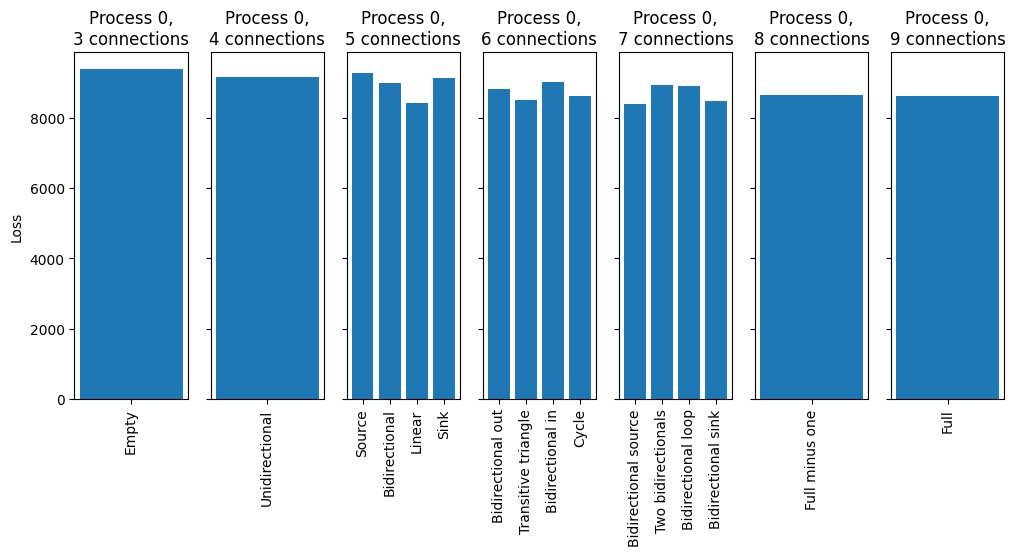

[{3: {'Empty': 9387.068059186979},
  4: {'Unidirectional': 9154.476128289238},
  5: {'Source': 9280.65682761773,
   'Bidirectional': 8992.471215617104,
   'Linear': 8416.948659667743,
   'Sink': 9121.842851012781},
  6: {'Bidirectional out': 8805.041832702733,
   'Transitive triangle': 8515.359390385434,
   'Bidirectional in': 9009.722231525211,
   'Cycle': 8615.633155470845},
  7: {'Bidirectional source': 8385.276665703826,
   'Two bidirectionals': 8941.066101391052,
   'Bidirectional loop': 8908.569692260879,
   'Bidirectional sink': 8461.06245070854},
  8: {'Full minus one': 8640.227737218049},
  9: {'Full': 8608.644088275681}}]

In [73]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 1e-5), np.full(15, 5e-6), np.full(20, 1e-6), np.full(20, 1e-7))),
           A=np.array([[0, 0, 0], [0.95, 0, 0], [0.95, -0.95, 0]]))

### Cycle

In [39]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0, 0, 0.95], [0.95, 0, 0], [0, 0.95, 0]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 5e-6), np.full(15, 5e-7), np.full(10, 1e-7), np.full(10, 5e-8), np.full(10, 5e-9), np.full(10, 1e-11))))

Process dynamics: [[0.   0.   0.95]
 [0.95 0.   0.  ]
 [0.   0.95 0.  ]]
Eigenvalues: [-0.475+0.82272413j -0.475-0.82272413j  0.95 +0.j        ]
Kalman filter M: [[0.         0.         0.60049406]
 [0.60049406 0.         0.        ]
 [0.         0.60049406 0.        ]]
Kalman filter K: [[0.36790099 0.         0.        ]
 [0.         0.36790099 0.        ]
 [0.         0.         0.36790099]]
Kalman filter loss: 7735.081860193392


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[ 0.18959832  0.          0.        ]
 [ 0.         -0.04493044  0.        ]
 [ 0.          0.          0.0893615 ]]
NN K: [[ 0.5956578   0.2138075   0.19299709]
 [-0.00283628  0.6927446   0.11783616]
 [ 0.12939711  0.18854552  0.64385524]]
NN W: [[ 1.12285271 -0.26405754 -0.22188888]
 [ 0.14346445  1.05397278 -0.05644028]
 [-0.17768914 -0.0957065   1.16816559]]
Loss: 16362.718040419428
Testing Empty, Trial 2
NN M: [[0.12097195 0.         0.        ]
 [0.         0.26275651 0.        ]
 [0.         0.         0.23350096]]
NN K: [[0.72246657 0.18411486 0.06689866]
 [0.15754061 0.56192342 0.22414466]
 [0.09031923 0.11217193 0.56440978]]
NN W: [[ 0.91888119 -0.05814326 -0.00753206]
 [ 0.11477942  0.79427188 -0.19907933]
 [-0.21510158  0.03107808  1.13851456]]
Loss: 22479.320390595418
Testing Empty, Trial 3


  6%|███▌                                                    | 1/16 [01:21<20:20, 81.38s/it]

NN M: [[-0.0562208   0.          0.        ]
 [ 0.          0.28576042  0.        ]
 [ 0.          0.          0.17673775]]
NN K: [[0.75861742 0.10947967 0.00966537]
 [0.24073289 0.52997539 0.10100405]
 [0.22089949 0.16458354 0.61278592]]
NN W: [[ 0.98368816 -0.0062023   0.09705771]
 [-0.16407779  1.09905037 -0.21785113]
 [-0.27052787 -0.19466314  1.16365697]]
Loss: 18311.941513508886
Testing Unidirectional, Trial 1
NN M: [[0.11564866 0.         0.        ]
 [0.18968767 0.10703139 0.        ]
 [0.         0.         0.14392744]]
NN K: [[0.7764534  0.08080979 0.19982862]
 [0.20840629 0.51397549 0.12265713]
 [0.14266351 0.2021455  0.67022192]]
NN W: [[ 1.01773234 -0.06877355 -0.16680124]
 [-0.19343287  1.0799375  -0.09438348]
 [-0.08791281 -0.14419783  1.02190739]]
Loss: 15687.789856625084
Testing Unidirectional, Trial 2
NN M: [[ 0.27766905  0.          0.        ]
 [ 0.19739657 -0.01679353  0.        ]
 [ 0.          0.          0.32525459]]
NN K: [[0.63054349 0.28145107 0.21651883]
 [0

 12%|███████                                                 | 2/16 [03:01<21:32, 92.32s/it]

NN M: [[0.24651318 0.         0.        ]
 [0.22965322 0.03939189 0.        ]
 [0.         0.         0.19278444]]
NN K: [[ 0.61468183  0.11433489  0.3040431 ]
 [ 0.20616529  0.5394464   0.01822332]
 [-0.07896797  0.17360523  0.50139299]]
NN W: [[ 0.91441263 -0.12828596 -0.20814234]
 [-0.2604176   1.03576104  0.20914759]
 [ 0.27820287 -0.17399686  1.01834722]]
Loss: 18269.785077579632
Testing Source, Trial 1
NN M: [[ 0.13190562  0.          0.        ]
 [ 0.34322773  0.14798206  0.        ]
 [ 0.11302109  0.         -0.03819766]]
NN K: [[0.65567312 0.05486645 0.0529951 ]
 [0.11351055 0.47350729 0.08184214]
 [0.26504231 0.00383623 0.59396636]]
NN W: [[ 1.12048243 -0.04133333  0.0059082 ]
 [-0.09516826  1.04529425 -0.16623741]
 [-0.27842483  0.17898679  1.05169167]]
Loss: 16388.68059143809
Testing Source, Trial 2
NN M: [[-0.12378813  0.          0.        ]
 [ 0.2758446   0.14082674  0.        ]
 [ 0.02879513  0.          0.22778834]]
NN K: [[ 0.68421136  0.04961627 -0.12555178]
 [ 0.186

 19%|██████████▌                                             | 3/16 [04:31<19:47, 91.37s/it]

NN M: [[ 0.11068728  0.          0.        ]
 [ 0.16079543 -0.04830265  0.        ]
 [ 0.28052532  0.          0.42398342]]
NN K: [[ 0.45659418  0.30833661  0.08325994]
 [-0.03173125  0.63759724  0.03371193]
 [ 0.11913573  0.13487006  0.3724196 ]]
NN W: [[ 0.84378516 -0.26903108  0.21441134]
 [ 0.1300612   1.03691216  0.02494492]
 [-0.25088277 -0.14667493  0.83842891]]
Loss: 19137.774127933975
Testing Bidirectional, Trial 1
NN M: [[0.38140272 0.30277999 0.        ]
 [0.11557758 0.22738526 0.        ]
 [0.         0.         0.11927201]]
NN K: [[ 0.32364093  0.3343945   0.19626508]
 [ 0.17459705  0.42235015  0.07389927]
 [-0.01716922  0.08524664  0.62764731]]
NN W: [[ 0.51802109  0.01655327 -0.11214473]
 [ 0.04249172  0.82731902 -0.09589406]
 [ 0.09235497 -0.03596431  1.02567286]]
Loss: 26907.348801622073
Testing Bidirectional, Trial 2
NN M: [[0.27201663 0.19061172 0.        ]
 [0.26510061 0.04721884 0.        ]
 [0.         0.         0.10805147]]
NN K: [[ 0.49301517  0.03472474  0.236

 25%|██████████████                                          | 4/16 [06:13<19:07, 95.59s/it]

NN M: [[0.09383239 0.20946101 0.        ]
 [0.21836514 0.17557899 0.        ]
 [0.         0.         0.16162441]]
NN K: [[0.59263946 0.11647014 0.07206824]
 [0.09958368 0.4314865  0.08243873]
 [0.09967071 0.14588555 0.59773566]]
NN W: [[ 1.05315088 -0.22826332  0.01822277]
 [-0.13322779  1.04438371  0.01910929]
 [-0.12892178 -0.05461825  1.13854367]]
Loss: 19922.052410367374
Testing Linear, Trial 1
NN M: [[0.321028   0.         0.        ]
 [0.08340083 0.11042018 0.        ]
 [0.         0.16087818 0.15243005]]
NN K: [[ 0.55850019  0.10998539  0.28526296]
 [ 0.24518259  0.71149688  0.2755153 ]
 [-0.00175157  0.12924553  0.46293042]]
NN W: [[ 1.05751602 -0.12162925 -0.36337381]
 [-0.21801837  0.9508224  -0.17947299]
 [-0.03320671  0.0100839   1.00152521]]
Loss: 17764.895048684702
Testing Linear, Trial 2
NN M: [[0.31142353 0.         0.        ]
 [0.33562191 0.06272797 0.        ]
 [0.         0.30035397 0.06202583]]
NN K: [[0.54365067 0.14784602 0.19283173]
 [0.02545185 0.51074919 0.07

 31%|█████████████████▌                                      | 5/16 [07:49<17:31, 95.59s/it]

NN M: [[ 0.14482009  0.          0.        ]
 [ 0.3426599  -0.06803161  0.        ]
 [ 0.          0.19335314  0.27277633]]
NN K: [[0.64230474 0.12083214 0.08492021]
 [0.13353451 0.56120396 0.08693056]
 [0.14623665 0.2745675  0.49471689]]
NN W: [[ 1.19972062 -0.18018828 -0.0364874 ]
 [-0.15002507  1.14475    -0.069714  ]
 [-0.31197176 -0.33597765  1.0488492 ]]
Loss: 13208.899218627426
Testing Sink, Trial 1
NN M: [[ 0.15338919  0.          0.        ]
 [ 0.16023773 -0.01973323  0.28938546]
 [ 0.          0.          0.1402109 ]]
NN K: [[0.52420816 0.19751052 0.08776305]
 [0.16666083 0.50094843 0.09412312]
 [0.3234221  0.18865289 0.61043676]]
NN W: [[ 0.79907909 -0.00730973  0.14229973]
 [ 0.0568231   0.89414828 -0.18215203]
 [-0.18817498 -0.23344045  1.09010548]]
Loss: 20581.79259304136
Testing Sink, Trial 2
NN M: [[0.29232089 0.         0.        ]
 [0.11300757 0.32150352 0.00682234]
 [0.         0.         0.22718998]]
NN K: [[0.61069483 0.00395156 0.20408855]
 [0.14950551 0.45412851 

 38%|████████████████████▋                                  | 6/16 [09:48<17:14, 103.47s/it]

NN M: [[0.26039754 0.         0.        ]
 [0.26868405 0.04199688 0.20512987]
 [0.         0.         0.11718669]]
NN K: [[0.63148268 0.00812644 0.17531723]
 [0.12463455 0.52901635 0.21227661]
 [0.11786258 0.0420821  0.62122565]]
NN W: [[ 1.02710887 -0.06574855 -0.11175598]
 [-0.2400866   1.04945817 -0.29426772]
 [-0.09497564  0.01070671  1.15770549]]
Loss: 15883.46729448719
Testing Bidirectional out, Trial 1
NN M: [[ 0.34534692  0.21405088  0.        ]
 [ 0.14627017  0.18896435  0.        ]
 [ 0.17259915  0.         -0.24816739]]
NN K: [[ 0.3317191   0.17370799  0.26205563]
 [ 0.13658858  0.3750896   0.29097626]
 [ 0.04381657 -0.1964313   0.56477937]]
NN W: [[ 0.82103068 -0.17723942 -0.21863029]
 [ 0.05098268  0.85054083 -0.37817146]
 [ 0.19102206  0.0852891   1.01179452]]
Loss: 23398.196442439177
Testing Bidirectional out, Trial 2
NN M: [[ 0.42035789  0.00413488  0.        ]
 [ 0.15353822  0.19806807  0.        ]
 [ 0.20438428  0.         -0.18124994]]
NN K: [[ 0.37959091  0.15905778

 44%|████████████████████████▌                               | 7/16 [11:18<14:51, 99.09s/it]

NN M: [[-0.09910941  0.30510225  0.        ]
 [ 0.34353508  0.1315479   0.        ]
 [ 0.1173295   0.          0.19490536]]
NN K: [[0.58705788 0.12508593 0.06579391]
 [0.19908952 0.34220509 0.15285461]
 [0.11982803 0.20763658 0.57209643]]
NN W: [[ 1.12312636  0.03055754 -0.20367432]
 [-0.17240246  0.87821098  0.05989383]
 [-0.2289407  -0.13985993  1.06894545]]
Loss: 21882.04835346991
Testing Transitive triangle, Trial 1
NN M: [[0.2783599  0.         0.        ]
 [0.14401279 0.08093789 0.        ]
 [0.06973441 0.17296013 0.01113775]]
NN K: [[0.50869034 0.17865226 0.28961801]
 [0.17371756 0.63537129 0.13177631]
 [0.12758717 0.19870312 0.55259318]]
NN W: [[ 0.89856837 -0.06664128 -0.15416572]
 [-0.03769445  0.91142959 -0.09555888]
 [ 0.02347208 -0.18497605  0.96308952]]
Loss: 19664.462073454462
Testing Transitive triangle, Trial 2
NN M: [[0.16367297 0.         0.        ]
 [0.12404825 0.2176331  0.        ]
 [0.15923495 0.23748195 0.01525679]]
NN K: [[0.52172132 0.09836321 0.22330364]
 [0

 50%|████████████████████████████                            | 8/16 [12:51<12:58, 97.34s/it]

NN M: [[ 0.33963994  0.          0.        ]
 [ 0.32465222 -0.12978289  0.        ]
 [ 0.19206509  0.12738633 -0.17733979]]
NN K: [[ 0.47320241  0.22006303  0.23350305]
 [-0.11304976  0.61379495  0.2126935 ]
 [ 0.02617883  0.00440094  0.5885833 ]]
NN W: [[ 1.13406127 -0.37038741 -0.29435169]
 [ 0.13279532  1.00728053 -0.30961179]
 [ 0.11365073 -0.07066395  1.01598214]]
Loss: 12494.674482191793
Testing Bidirectional in, Trial 1
NN M: [[-0.05578666  0.08481206  0.26089502]
 [ 0.20478313  0.1495368   0.        ]
 [ 0.          0.          0.25846319]]
NN K: [[0.60124382 0.0869846  0.09843574]
 [0.2976536  0.54820144 0.15401789]
 [0.1731067  0.19565792 0.61178472]]
NN W: [[ 0.99207105 -0.04519781 -0.12327279]
 [-0.33377952  1.01214312 -0.10022548]
 [-0.23932982 -0.18482455  1.13484864]]
Loss: 15380.999097593667
Testing Bidirectional in, Trial 2
NN M: [[-0.04305008  0.02167472  0.36153907]
 [ 0.28138386  0.19042869  0.        ]
 [ 0.          0.          0.2248309 ]]
NN K: [[ 0.55613496  0.

 56%|███████████████████████████████▌                        | 9/16 [14:22<11:07, 95.34s/it]

NN M: [[ 0.39452963  0.38994074  0.13522917]
 [ 0.22446933  0.04202586  0.        ]
 [ 0.          0.         -0.02868933]]
NN K: [[ 0.23232606  0.27126772  0.29353474]
 [ 0.18319901  0.36892317  0.23077475]
 [ 0.14280821 -0.00995482  0.59168094]]
NN W: [[ 0.47293139 -0.10793917 -0.02240134]
 [ 0.13016625  0.59676088 -0.24242163]
 [ 0.16194265 -0.04326562  0.89495398]]
Loss: 27753.998440510448
Testing Cycle, Trial 1
NN M: [[0.02423956 0.         0.24961639]
 [0.28820127 0.11215491 0.        ]
 [0.         0.20606704 0.11479504]]
NN K: [[0.63326389 0.09868577 0.19715975]
 [0.26723081 0.57126267 0.16007262]
 [0.06814824 0.11007548 0.5064587 ]]
NN W: [[ 1.05361206 -0.10741856 -0.16474241]
 [-0.31694893  0.95828984 -0.09951163]
 [-0.06874407 -0.14551266  1.1284614 ]]
Loss: 12583.247121276738
Testing Cycle, Trial 2
NN M: [[0.01735889 0.         0.14386228]
 [0.35227269 0.03853569 0.        ]
 [0.         0.25705978 0.09415074]]
NN K: [[0.69376027 0.20636085 0.17590264]
 [0.1459431  0.513082

 62%|██████████████████████████████████▍                    | 10/16 [15:47<09:13, 92.26s/it]

NN M: [[ 0.20784193  0.          0.20668484]
 [ 0.16952226  0.14094505  0.        ]
 [ 0.          0.31624577 -0.03613846]]
NN K: [[0.51539401 0.14622942 0.23891983]
 [0.08094577 0.54642609 0.11972424]
 [0.06494048 0.11600144 0.58045703]]
NN W: [[ 1.15644229 -0.29840361 -0.31347923]
 [-0.05764417  1.14973779 -0.25287959]
 [-0.0338172  -0.1813997   1.1176231 ]]
Loss: 12244.359156330891
Testing Bidirectional source, Trial 1
NN M: [[0.12753353 0.1529773  0.        ]
 [0.19587779 0.17577451 0.        ]
 [0.09739637 0.27961663 0.11150498]]
NN K: [[0.59557628 0.15882862 0.23149067]
 [0.18061654 0.54288025 0.13866392]
 [0.10620665 0.09958861 0.46134437]]
NN W: [[ 0.98010275 -0.08900412 -0.19897089]
 [-0.12299293  1.11351379 -0.2950933 ]
 [-0.02475703 -0.17548406  0.92010435]]
Loss: 17834.897990820078
Testing Bidirectional source, Trial 2
NN M: [[0.31134872 0.0385078  0.        ]
 [0.2815596  0.10096224 0.        ]
 [0.04910729 0.20373711 0.0753805 ]]
NN K: [[0.56017495 0.08881837 0.23043367]


 69%|█████████████████████████████████████▊                 | 11/16 [17:13<07:30, 90.12s/it]

NN M: [[ 0.22022143 -0.12038641  0.        ]
 [ 0.18591996 -0.12847938  0.        ]
 [ 0.25046998  0.21658179  0.23620421]]
NN K: [[ 0.56631561  0.2031881   0.22645873]
 [-0.09649214  0.5410622  -0.10264837]
 [ 0.0946447   0.1840677   0.3945023 ]]
NN W: [[ 1.03655516 -0.16136243 -0.14776378]
 [ 0.14204116  1.12904124  0.15893288]
 [-0.16764456 -0.24982764  0.89814775]]
Loss: 16574.05311947663
Testing Two bidirectionals, Trial 1
NN M: [[-0.01170651  0.14266452  0.3833105 ]
 [ 0.14455011  0.11673306  0.        ]
 [ 0.04855408  0.         -0.01108607]]
NN K: [[0.47206128 0.08905176 0.20012793]
 [0.27088637 0.63517113 0.29291996]
 [0.12823616 0.12937529 0.74886468]]
NN W: [[ 0.91740787 -0.00474741 -0.284056  ]
 [-0.31041685  1.00923762 -0.19426148]
 [-0.07556726 -0.06234545  1.07867321]]
Loss: 15410.238570332323
Testing Two bidirectionals, Trial 2
NN M: [[-0.14816477  0.12699608  0.34129614]
 [ 0.12489599  0.24245354  0.        ]
 [ 0.06539151  0.          0.24213616]]
NN K: [[0.52735363 0

 75%|█████████████████████████████████████████▎             | 12/16 [18:39<05:55, 88.91s/it]

NN M: [[-0.15711693  0.01830302  0.34949982]
 [ 0.26654808  0.05265088  0.        ]
 [ 0.06051876  0.          0.22488655]]
NN K: [[ 0.5825711   0.22609994 -0.003396  ]
 [ 0.11083679  0.50789524  0.05106017]
 [ 0.2692482   0.2567845   0.64878751]]
NN W: [[ 1.01744234 -0.33418536  0.05799951]
 [-0.1573493   1.15126528 -0.03939306]
 [-0.35764085 -0.26244129  1.03011353]]
Loss: 14059.852691525364
Testing Bidirectional loop, Trial 1
NN M: [[0.06210653 0.15553496 0.        ]
 [0.02489887 0.30019471 0.09674047]
 [0.02995865 0.         0.19389039]]
NN K: [[ 0.53621941 -0.05637749  0.07131998]
 [ 0.20719793  0.45268749  0.06628639]
 [ 0.05683012  0.14046601  0.53367859]]
NN W: [[ 1.18297304  0.0704319  -0.06780583]
 [-0.28189946  1.0517839  -0.08078302]
 [ 0.061218   -0.11212964  1.10103548]]
Loss: 18933.833172993414
Testing Bidirectional loop, Trial 2
NN M: [[ 0.10192463  0.26127189  0.        ]
 [ 0.2951936   0.14606719 -0.0773912 ]
 [ 0.0691781   0.          0.10264567]]
NN K: [[0.56980154 

 81%|████████████████████████████████████████████▋          | 13/16 [20:02<04:21, 87.02s/it]

NN M: [[0.28901872 0.16039114 0.        ]
 [0.27654998 0.05908456 0.13156271]
 [0.11447627 0.         0.20820527]]
NN K: [[ 0.44900698 -0.02591973  0.38222868]
 [ 0.0585539   0.45660475  0.09068478]
 [ 0.07165768  0.25429682  0.32740893]]
NN W: [[ 0.85179251 -0.16453888 -0.03637407]
 [-0.31497961  1.08594482  0.08917436]
 [ 0.40332878 -0.33122022  0.75939244]]
Loss: 24484.608131505487
Testing Bidirectional sink, Trial 1
NN M: [[0.1396929  0.         0.        ]
 [0.20844921 0.23534659 0.07300927]
 [0.0573443  0.31901589 0.10161391]]
NN K: [[ 0.63816351 -0.01718305  0.09396602]
 [ 0.14099452  0.48338458  0.11463346]
 [ 0.07884993  0.06749829  0.48349121]]
NN W: [[ 1.15869152  0.09045965 -0.11397654]
 [-0.17917766  1.10161521 -0.27965534]
 [-0.12751483 -0.0786738   0.95125321]]
Loss: 13552.23469825639
Testing Bidirectional sink, Trial 2
NN M: [[ 0.07888254  0.          0.        ]
 [ 0.02320438  0.07283357  0.22742513]
 [ 0.16866533  0.20062584 -0.02849591]]
NN K: [[ 0.5792927   0.240753

 88%|████████████████████████████████████████████████▏      | 14/16 [21:28<02:53, 86.88s/it]

NN M: [[ 0.22330826  0.          0.        ]
 [ 0.16568741 -0.12051128  0.40900834]
 [ 0.3257319  -0.07185018  0.28998592]]
NN K: [[ 0.46519779  0.16504111  0.21403697]
 [-0.12596472  0.47568941  0.00131663]
 [ 0.19481288  0.0831608   0.39691191]]
NN W: [[ 0.97430126 -0.15796572  0.03345975]
 [-0.02089225  1.04966812 -0.0259101 ]
 [ 0.03286378 -0.06944912  0.7221097 ]]
Loss: 21283.301153213117
Testing Full minus one, Trial 1
NN M: [[ 0.02126117  0.34708187  0.12660887]
 [ 0.38741874  0.23153736  0.        ]
 [ 0.15522548  0.23391798 -0.25981366]]
NN K: [[ 0.46967826  0.24055304  0.03889343]
 [ 0.07541411  0.29301184  0.34707446]
 [ 0.12631109 -0.27380593  0.50104082]]
NN W: [[ 0.83732764 -0.13726471 -0.03742607]
 [ 0.0820021   0.7074952  -0.45711323]
 [-0.14780397  0.2829345   0.92123449]]
Loss: 17285.116297145665
Testing Full minus one, Trial 2
NN M: [[ 0.29505547  0.0608113   0.14341137]
 [ 0.20060555 -0.04018586  0.        ]
 [ 0.33347717  0.12765053  0.19937238]]
NN K: [[ 0.4392230

 94%|███████████████████████████████████████████████████▌   | 15/16 [22:54<01:26, 86.48s/it]

NN M: [[ 0.12179211  0.18234363  0.14581293]
 [ 0.19799098  0.29246704  0.        ]
 [-0.01039824  0.18498668  0.15706686]]
NN K: [[ 0.51918117 -0.027391    0.20980533]
 [ 0.26464803  0.44283659  0.2192981 ]
 [ 0.02581309  0.10003516  0.51671483]]
NN W: [[ 0.96907641  0.0109913  -0.31774732]
 [-0.40355389  0.99421585 -0.15506999]
 [-0.11664336 -0.02740394  1.03853377]]
Loss: 16874.160982945254
Testing Full, Trial 1
NN M: [[0.16831626 0.07285632 0.19910496]
 [0.3992555  0.13853453 0.07588552]
 [0.18399694 0.20043704 0.25468662]]
NN K: [[0.5371569  0.13223011 0.26621159]
 [0.05882996 0.53593311 0.17484959]
 [0.09545261 0.16418735 0.32592739]]
NN W: [[ 0.93956025 -0.3063356  -0.04168853]
 [-0.2728515   0.97291983 -0.21488529]
 [ 0.08895817 -0.10203727  0.58337082]]
Loss: 20937.82764432967
Testing Full, Trial 2
NN M: [[ 0.06385537  0.23465247  0.1072319 ]
 [ 0.33895421  0.21130541  0.00813763]
 [-0.01278591  0.26363935 -0.02721128]]
NN K: [[0.53120466 0.10393319 0.10530149]
 [0.06575842 0.

100%|███████████████████████████████████████████████████████| 16/16 [24:18<00:00, 91.13s/it]

NN M: [[0.13792874 0.16107737 0.15657008]
 [0.18668841 0.05248277 0.06771258]
 [0.18149825 0.19788708 0.00531113]]
NN K: [[0.51548329 0.25530283 0.17577262]
 [0.02891964 0.50338639 0.09492707]
 [0.08853773 0.1124142  0.52829748]]
NN W: [[ 0.96642258 -0.23621284 -0.20786223]
 [ 0.09590014  1.01092471 -0.19874812]
 [-0.03686282 -0.26730419  1.06460795]]
Loss: 14987.068265162025


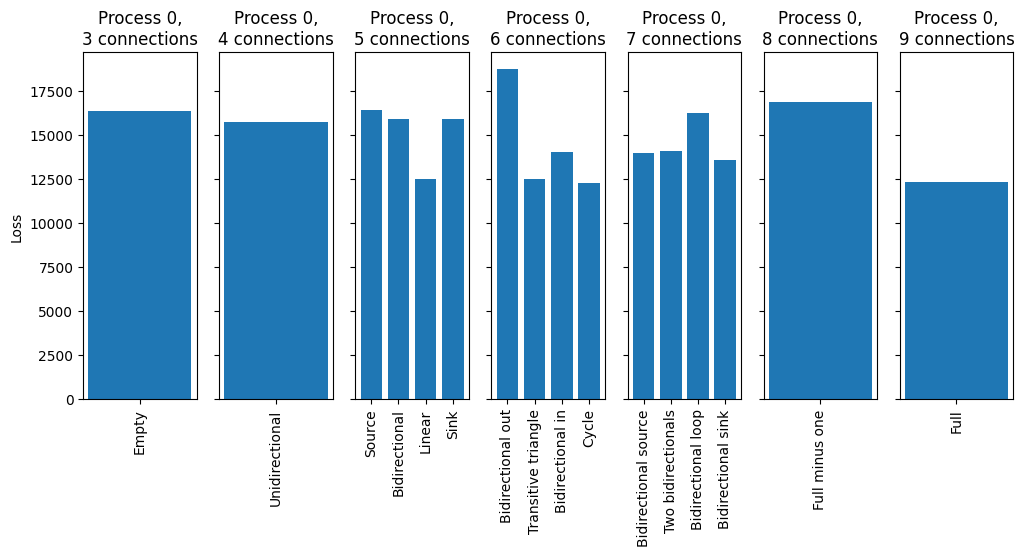

[{3: {'Empty': 16362.718040419428},
  4: {'Unidirectional': 15687.789856625084},
  5: {'Source': 16388.68059143809,
   'Bidirectional': 15889.7235882559,
   'Linear': 12464.71068299001,
   'Sink': 15883.46729448719},
  6: {'Bidirectional out': 18726.53601226536,
   'Transitive triangle': 12494.674482191793,
   'Bidirectional in': 13993.381948110613,
   'Cycle': 12244.359156330891},
  7: {'Bidirectional source': 13951.001570694358,
   'Two bidirectionals': 14059.852691525364,
   'Bidirectional loop': 16222.013399931166,
   'Bidirectional sink': 13552.23469825639},
  8: {'Full minus one': 16874.160982945254},
  9: {'Full': 12290.805650988044}}]

In [40]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 5e-6), np.full(15, 5e-7), np.full(10, 1e-7), np.full(10, 5e-8), np.full(10, 5e-9), np.full(10, 1e-11))),
           A=np.array([[0, 0, 0.95], [0.95, 0, 0], [0, 0.95, 0]]))

## Asymmetric bidirectional

In [43]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0, 0.4, 0.5], [0.5, 0, 0.4], [0.4, 0.5, 0]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 5e-6), np.full(15, 5e-7), np.full(30, 1e-7), np.full(50, 5e-8))))

Process dynamics: [[0.  0.4 0.5]
 [0.5 0.  0.4]
 [0.4 0.5 0. ]]
Eigenvalues: [ 0.9 +0.j         -0.45+0.08660254j -0.45-0.08660254j]
Kalman filter M: [[-0.0351183   0.27299045  0.35001764]
 [ 0.35001764 -0.0351183   0.27299045]
 [ 0.27299045  0.35001764 -0.0351183 ]]
Kalman filter K: [[0.26874846 0.03902033 0.03902033]
 [0.03902033 0.26874846 0.03902033]
 [0.03902033 0.03902033 0.26874846]]
Kalman filter loss: 5827.834903792264


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.37650892 0.         0.        ]
 [0.         0.34403467 0.        ]
 [0.         0.         0.35225038]]
NN K: [[0.40303324 0.24467355 0.23952529]
 [0.23775752 0.44111676 0.24406862]
 [0.23532393 0.24680025 0.42690532]]
NN W: [[ 0.87541485 -0.14841431 -0.10150204]
 [-0.12721523  0.87224096 -0.10835489]
 [-0.1208946  -0.12173532  0.88279979]]
Loss: 7363.744489177052
Testing Empty, Trial 2
NN M: [[0.38738697 0.         0.        ]
 [0.         0.41212328 0.        ]
 [0.         0.         0.36941059]]
NN K: [[0.41181199 0.22170911 0.24616266]
 [0.2269034  0.37996852 0.21487266]
 [0.21315728 0.22960997 0.4190754 ]]
NN W: [[ 0.87438096 -0.10509417 -0.15117282]
 [-0.1307695   0.89034778 -0.11409014]
 [-0.10774334 -0.10272421  0.87560311]]
Loss: 7438.61343485773
Testing Empty, Trial 3


  6%|███▍                                                   | 1/16 [03:54<58:34, 234.28s/it]

NN M: [[0.37974534 0.         0.        ]
 [0.         0.38983508 0.        ]
 [0.         0.         0.3936703 ]]
NN K: [[0.36408804 0.19245803 0.20197527]
 [0.22713731 0.40227847 0.21926693]
 [0.21990218 0.23399649 0.38700754]]
NN W: [[ 0.8939058  -0.06674961 -0.07563805]
 [-0.10933023  0.87127143 -0.12661719]
 [-0.1001171  -0.13031024  0.86914149]]
Loss: 7325.519862109245
Testing Unidirectional, Trial 1
NN M: [[0.36871513 0.         0.        ]
 [0.25176727 0.16278659 0.        ]
 [0.         0.         0.37049743]]
NN K: [[0.42698231 0.22269267 0.27213767]
 [0.19745623 0.39309765 0.19607456]
 [0.21848785 0.22545695 0.39221474]]
NN W: [[ 0.84722638 -0.14261228 -0.1018818 ]
 [-0.14839992  0.88279554 -0.06967031]
 [-0.08548691 -0.08745693  0.86213511]]
Loss: 7371.605674363023
Testing Unidirectional, Trial 2
NN M: [[0.32896498 0.         0.        ]
 [0.30013581 0.07160976 0.        ]
 [0.         0.         0.31851296]]
NN K: [[0.39944357 0.24361525 0.25896015]
 [0.16663919 0.38941472

 12%|██████▉                                                | 2/16 [07:50<54:51, 235.13s/it]

NN M: [[0.32119488 0.         0.        ]
 [0.19654517 0.16115415 0.        ]
 [0.         0.         0.39835457]]
NN K: [[0.40096307 0.22022029 0.21823636]
 [0.19128501 0.39574881 0.17581298]
 [0.18428186 0.19491827 0.33854307]]
NN W: [[ 0.88001557 -0.11003694 -0.04301147]
 [-0.11676126  0.89271458 -0.01611665]
 [-0.07729555 -0.05817722  0.89293497]]
Loss: 7094.400806942795
Testing Source, Trial 1
NN M: [[0.3765634  0.         0.        ]
 [0.22250843 0.20194287 0.        ]
 [0.27066842 0.         0.15272912]]
NN K: [[0.43525862 0.24898736 0.26051928]
 [0.21592616 0.39326966 0.23933953]
 [0.17315831 0.16506009 0.36089151]]
NN W: [[ 0.85985616 -0.14680437 -0.13633557]
 [-0.13412714  0.86604331 -0.13299912]
 [-0.09822248 -0.07544144  0.89114261]]
Loss: 6821.910202905255
Testing Source, Trial 2
NN M: [[0.362596   0.         0.        ]
 [0.23197041 0.20817612 0.        ]
 [0.28748969 0.         0.14609967]]
NN K: [[0.43412544 0.23296946 0.2459554 ]
 [0.19634471 0.39692002 0.20835763]
 [0

 19%|██████████▎                                            | 3/16 [11:52<51:41, 238.61s/it]

NN M: [[0.35821549 0.         0.        ]
 [0.18030509 0.25845445 0.        ]
 [0.23669719 0.         0.17483755]]
NN K: [[0.43299557 0.23672879 0.23621915]
 [0.20620929 0.392302   0.18518007]
 [0.19693572 0.20361497 0.40607533]]
NN W: [[ 0.87906159 -0.11445605 -0.12482775]
 [-0.13383554  0.88902508 -0.10617388]
 [-0.12305049 -0.11740867  0.90176073]]
Loss: 6939.172294771645
Testing Bidirectional, Trial 1
NN M: [[0.18599512 0.15352794 0.        ]
 [0.21415249 0.10878669 0.        ]
 [0.         0.         0.3422669 ]]
NN K: [[0.41151107 0.23186118 0.24217955]
 [0.19484091 0.40672666 0.20905759]
 [0.22687288 0.22370829 0.3895155 ]]
NN W: [[ 0.87349194 -0.14397829 -0.05069376]
 [-0.11459625  0.89270507 -0.02711432]
 [-0.08195742 -0.08302138  0.87093526]]
Loss: 7133.151376137287
Testing Bidirectional, Trial 2
NN M: [[0.24926407 0.12571417 0.        ]
 [0.18334877 0.18796967 0.        ]
 [0.         0.         0.33204032]]
NN K: [[0.42362182 0.21340227 0.25438609]
 [0.18943531 0.38263462 0

 25%|█████████████▊                                         | 4/16 [16:02<48:38, 243.17s/it]

NN M: [[0.16866145 0.18376526 0.        ]
 [0.18482319 0.15899633 0.        ]
 [0.         0.         0.31263739]]
NN K: [[0.42408835 0.21255683 0.25736117]
 [0.22278776 0.42047363 0.24180429]
 [0.21956672 0.21254882 0.41416607]]
NN W: [[ 0.86646089 -0.13927316 -0.0756039 ]
 [-0.14307821  0.8777827  -0.06634033]
 [-0.06089718 -0.07272094  0.87549967]]
Loss: 7212.32886055661
Testing Linear, Trial 1
NN M: [[0.35311656 0.         0.        ]
 [0.24691343 0.15058112 0.        ]
 [0.         0.22545989 0.22613872]]
NN K: [[0.41826027 0.26013001 0.25654595]
 [0.19959476 0.40501954 0.19523216]
 [0.19212322 0.20819422 0.3730325 ]]
NN W: [[ 0.87171535 -0.14593769 -0.10881375]
 [-0.11582206  0.88261175 -0.08940717]
 [-0.11869049 -0.11024409  0.87994264]]
Loss: 6860.584401249247
Testing Linear, Trial 2
NN M: [[0.38797377 0.         0.        ]
 [0.27558303 0.14711779 0.        ]
 [0.         0.20869469 0.23906344]]
NN K: [[0.41965283 0.22933034 0.24799371]
 [0.19890103 0.40717498 0.18422479]
 [0.

 31%|█████████████████▏                                     | 5/16 [20:06<44:35, 243.23s/it]

NN M: [[0.36163619 0.         0.        ]
 [0.24635644 0.2353594  0.        ]
 [0.         0.25032164 0.17132581]]
NN K: [[0.3959577  0.20130212 0.2333096 ]
 [0.16287862 0.33060638 0.15841308]
 [0.14691126 0.16543566 0.35315508]]
NN W: [[ 0.890043   -0.10069557 -0.10554159]
 [-0.09640249  0.90717588 -0.10346065]
 [-0.0626939  -0.08780134  0.92292767]]
Loss: 6958.719552320969
Testing Sink, Trial 1
NN M: [[0.36957286 0.         0.        ]
 [0.1797817  0.08369718 0.17633256]
 [0.         0.         0.40088457]]
NN K: [[0.40722777 0.19953207 0.21598163]
 [0.1743959  0.35647528 0.17179349]
 [0.21901941 0.19590694 0.37595766]]
NN W: [[ 0.89698804 -0.10846809 -0.09682243]
 [-0.09701817  0.89731782 -0.08334234]
 [-0.11284028 -0.09125532  0.88454869]]
Loss: 6929.641384620464
Testing Sink, Trial 2
NN M: [[0.35172028 0.         0.        ]
 [0.18490883 0.02883473 0.23141918]
 [0.         0.         0.3651688 ]]
NN K: [[0.42478675 0.22474532 0.23091251]
 [0.16829096 0.37920174 0.1610105 ]
 [0.204

 38%|████████████████████▋                                  | 6/16 [24:12<40:43, 244.33s/it]

NN M: [[0.3311314  0.         0.        ]
 [0.16987012 0.10856275 0.19202466]
 [0.         0.         0.35399987]]
NN K: [[0.40743217 0.19186798 0.20196483]
 [0.1897998  0.33339294 0.15897107]
 [0.24744216 0.21009354 0.38788773]]
NN W: [[ 0.89797657 -0.0545386  -0.08088925]
 [-0.0656082   0.88521251 -0.11023644]
 [-0.10037449 -0.11184445  0.89229032]]
Loss: 7307.331239380993
Testing Bidirectional out, Trial 1
NN M: [[0.1686548  0.2359569  0.        ]
 [0.16690538 0.2693002  0.        ]
 [0.11344845 0.         0.29322579]]
NN K: [[0.39147869 0.16759521 0.19443254]
 [0.22105966 0.41709763 0.24244086]
 [0.23410379 0.23505778 0.42728687]]
NN W: [[ 0.90936732 -0.10136268 -0.09938984]
 [-0.14188667  0.86937521 -0.14215087]
 [-0.1257365  -0.1414141   0.87248577]]
Loss: 6805.884711532586
Testing Bidirectional out, Trial 2
NN M: [[0.2256077  0.16656919 0.        ]
 [0.15410736 0.23934835 0.        ]
 [0.24978147 0.         0.21397848]]
NN K: [[0.38203023 0.19821403 0.20493037]
 [0.197415   0.37

 44%|████████████████████████                               | 7/16 [28:12<36:25, 242.86s/it]

NN M: [[0.16118017 0.26136845 0.        ]
 [0.16342619 0.23269135 0.        ]
 [0.24773127 0.         0.19936085]]
NN K: [[0.36966572 0.17441927 0.16773704]
 [0.26116978 0.37394103 0.2366276 ]
 [0.188103   0.17469066 0.36862343]]
NN W: [[ 0.90542907 -0.09943801 -0.08455698]
 [-0.1341315   0.86671303 -0.10359224]
 [-0.10399355 -0.10596179  0.90736277]]
Loss: 7052.70368006205
Testing Transitive triangle, Trial 1
NN M: [[0.32882914 0.         0.        ]
 [0.28704288 0.1777425  0.        ]
 [0.03282792 0.16578078 0.2255726 ]]
NN K: [[0.40942549 0.18959848 0.22492202]
 [0.15532235 0.35675978 0.16169406]
 [0.1879502  0.18328153 0.34843268]]
NN W: [[ 0.88686415 -0.09024828 -0.05574116]
 [-0.09320908  0.91532565 -0.09657904]
 [-0.06132502 -0.07821403  0.86875149]]
Loss: 7172.641057597805
Testing Transitive triangle, Trial 2
NN M: [[0.37752016 0.         0.        ]
 [0.23388638 0.20167163 0.        ]
 [0.17386206 0.20344058 0.06270374]]
NN K: [[0.41363035 0.21042058 0.22515146]
 [0.21904206 0

 50%|███████████████████████████▌                           | 8/16 [32:19<32:32, 244.10s/it]

NN M: [[0.34664084 0.         0.        ]
 [0.20588401 0.22792583 0.        ]
 [0.16911897 0.1328695  0.19987975]]
NN K: [[0.41704829 0.22351838 0.20046695]
 [0.18420383 0.38026448 0.17651749]
 [0.19849091 0.17301254 0.29142979]]
NN W: [[ 0.88987282 -0.10936735 -0.07441055]
 [-0.10522156  0.90346415 -0.10377016]
 [-0.09887957 -0.08251343  0.86679135]]
Loss: 7484.051995394414
Testing Bidirectional in, Trial 1
NN M: [[0.08322076 0.07545489 0.28164944]
 [0.19919565 0.18221683 0.        ]
 [0.         0.         0.37934034]]
NN K: [[0.38875345 0.20244385 0.23020397]
 [0.2139988  0.39272242 0.20997391]
 [0.20068377 0.22813778 0.41536688]]
NN W: [[ 0.86382875 -0.13058028 -0.10350815]
 [-0.127661    0.88299385 -0.06998911]
 [-0.10547717 -0.11694614  0.89174378]]
Loss: 6594.840770567939
Testing Bidirectional in, Trial 2
NN M: [[0.05330876 0.22560915 0.19663217]
 [0.18799683 0.19664212 0.        ]
 [0.         0.         0.37293634]]
NN K: [[0.30343743 0.13956419 0.13434791]
 [0.17510726 0.3641

 56%|██████████████████████████████▉                        | 9/16 [36:30<28:44, 246.32s/it]

NN M: [[0.10445939 0.13755365 0.19897565]
 [0.12319486 0.24771495 0.        ]
 [0.         0.         0.38498466]]
NN K: [[0.33602605 0.19174936 0.16442547]
 [0.20639585 0.41368181 0.21225494]
 [0.19204389 0.22450752 0.3860391 ]]
NN W: [[ 0.89663593 -0.09719111 -0.07181924]
 [-0.11299071  0.89564292 -0.09410939]
 [-0.10120636 -0.10824796  0.90002404]]
Loss: 7035.930360533244
Testing Cycle, Trial 1
NN M: [[0.17068021 0.         0.23332287]
 [0.20385646 0.18602979 0.        ]
 [0.         0.26122468 0.14757933]]
NN K: [[0.40593261 0.198937   0.20194146]
 [0.23620507 0.4148825  0.21813325]
 [0.18876235 0.21649516 0.38813556]]
NN W: [[ 0.90638206 -0.11737342 -0.11194561]
 [-0.11813209  0.8797788  -0.12196271]
 [-0.11362689 -0.11427384  0.89966073]]
Loss: 7056.61859727113
Testing Cycle, Trial 2
NN M: [[0.18258855 0.         0.20998734]
 [0.17106123 0.23465    0.        ]
 [0.         0.16720733 0.24696649]]
NN K: [[0.38415882 0.18177482 0.19776552]
 [0.20154293 0.39917927 0.18623215]
 [0.20

 62%|█████████████████████████████████▊                    | 10/16 [40:49<25:00, 250.17s/it]

NN M: [[0.20078641 0.         0.21110066]
 [0.28062547 0.1177149  0.        ]
 [0.         0.23020082 0.17158509]]
NN K: [[0.38806253 0.18391198 0.23513217]
 [0.20136363 0.39830365 0.1978811 ]
 [0.19728507 0.19955705 0.39650987]]
NN W: [[ 0.89566548 -0.11919747 -0.11176057]
 [-0.1122208   0.90462878 -0.11001772]
 [-0.10398539 -0.11164537  0.90355926]]
Loss: 7144.5986548774645
Testing Bidirectional source, Trial 1
NN M: [[0.18531257 0.23126506 0.        ]
 [0.16111028 0.24847131 0.        ]
 [0.15273227 0.13453586 0.17685737]]
NN K: [[0.40291169 0.18811416 0.18886334]
 [0.2205598  0.39141721 0.23369322]
 [0.19563525 0.25210563 0.40379108]]
NN W: [[ 0.89894203 -0.11856691 -0.09457762]
 [-0.13702868  0.87162035 -0.09012443]
 [-0.12971156 -0.14020448  0.8488101 ]]
Loss: 6594.320093783393
Testing Bidirectional source, Trial 2
NN M: [[0.12736263 0.25447868 0.        ]
 [0.20917502 0.21591653 0.        ]
 [0.12717995 0.20390393 0.12017604]]
NN K: [[0.37650838 0.19247801 0.19494303]
 [0.151120

 69%|█████████████████████████████████████▏                | 11/16 [45:06<21:01, 252.36s/it]

NN M: [[0.20381625 0.2332402  0.        ]
 [0.22585116 0.1750886  0.        ]
 [0.17770339 0.11097355 0.1373401 ]]
NN K: [[0.37921489 0.22046318 0.2535687 ]
 [0.21397292 0.42609602 0.23461205]
 [0.21095284 0.20385675 0.39981156]]
NN W: [[ 0.87124015 -0.13148446 -0.1403461 ]
 [-0.13288541  0.88999445 -0.13686263]
 [-0.11436555 -0.12020651  0.87349064]]
Loss: 7033.783632479011
Testing Two bidirectionals, Trial 1
NN M: [[0.16871715 0.14057732 0.12587175]
 [0.14614394 0.26602127 0.        ]
 [0.19862024 0.         0.21732742]]
NN K: [[0.39083251 0.24158156 0.21619297]
 [0.19581276 0.40167733 0.19877073]
 [0.18287952 0.2089391  0.39213281]]
NN W: [[ 0.86136419 -0.12932791 -0.11866565]
 [-0.124786    0.89913997 -0.10362834]
 [-0.12347081 -0.11073017  0.90745983]]
Loss: 7107.781025490721
Testing Two bidirectionals, Trial 2
NN M: [[0.02922947 0.20916767 0.17980763]
 [0.15168008 0.23196662 0.        ]
 [0.17982015 0.         0.23427796]]
NN K: [[0.36991379 0.1771538  0.17126726]
 [0.21146551 0.

 75%|████████████████████████████████████████▌             | 12/16 [49:23<16:54, 253.65s/it]

NN M: [[0.08020408 0.23808529 0.16321988]
 [0.12934283 0.36739546 0.        ]
 [0.22185188 0.         0.21571159]]
NN K: [[0.354788   0.16537072 0.1716422 ]
 [0.23467637 0.33099225 0.16577643]
 [0.16458468 0.18138952 0.35784019]]
NN W: [[ 0.87392279 -0.10698382 -0.08711813]
 [-0.16374211  0.86272627 -0.08152463]
 [-0.0904604  -0.09549211  0.9137987 ]]
Loss: 6651.85295977433
Testing Bidirectional loop, Trial 1
NN M: [[0.19038266 0.20756245 0.        ]
 [0.18384405 0.08832945 0.19768733]
 [0.19606435 0.         0.22993524]]
NN K: [[0.41144333 0.2125871  0.22393077]
 [0.21984492 0.3673562  0.1964999 ]
 [0.21450823 0.20886558 0.36696974]]
NN W: [[ 0.88787023 -0.11978413 -0.12334919]
 [-0.13107227  0.8732079  -0.11556544]
 [-0.10415791 -0.12840649  0.89736795]]
Loss: 6660.293995562441
Testing Bidirectional loop, Trial 2
NN M: [[0.13716458 0.2625354  0.        ]
 [0.23162287 0.04255501 0.20072669]
 [0.26002678 0.         0.14071617]]
NN K: [[0.38175735 0.1935387  0.19829045]
 [0.16948687 0.3

 81%|███████████████████████████████████████████▉          | 13/16 [53:57<12:59, 259.83s/it]

NN M: [[0.13799347 0.22255871 0.        ]
 [0.10635212 0.14653226 0.22182076]
 [0.14509152 0.         0.24582302]]
NN K: [[0.39798215 0.17313355 0.21454129]
 [0.23510074 0.37161789 0.25823755]
 [0.23255233 0.19376311 0.39827475]]
NN W: [[ 0.90535467 -0.10159318 -0.08260466]
 [-0.1549472   0.85049606 -0.13348367]
 [-0.09893056 -0.1080507   0.89553815]]
Loss: 6848.922747570187
Testing Bidirectional sink, Trial 1
NN M: [[0.39662429 0.         0.        ]
 [0.18841776 0.0688266  0.15819176]
 [0.23667556 0.14815968 0.18518321]]
NN K: [[0.38639241 0.21868627 0.21448893]
 [0.17487479 0.37232546 0.19003919]
 [0.1316973  0.16852334 0.33797083]]
NN W: [[ 0.90518604 -0.11767535 -0.12042068]
 [-0.07685663  0.90479466 -0.11730633]
 [-0.09231413 -0.13002159  0.84828785]]
Loss: 6909.774346879133
Testing Bidirectional sink, Trial 2
NN M: [[0.35983921 0.         0.        ]
 [0.1285386  0.21257021 0.13393563]
 [0.22455063 0.1883536  0.01220104]]
NN K: [[0.40070455 0.19977279 0.19527968]
 [0.19496323 0.

 88%|███████████████████████████████████████████████▎      | 14/16 [58:28<08:46, 263.22s/it]

NN M: [[0.35925984 0.         0.        ]
 [0.17359501 0.10810191 0.13893837]
 [0.2093567  0.06867704 0.1484116 ]]
NN K: [[0.41830694 0.25319558 0.21699238]
 [0.17721081 0.38868963 0.16165798]
 [0.18688913 0.19868927 0.32926557]]
NN W: [[ 0.87150396 -0.12528321 -0.10769033]
 [-0.09076613  0.90722216 -0.10018843]
 [-0.08248101 -0.09782433  0.89915458]]
Loss: 6819.432767965543
Testing Full minus one, Trial 1
NN M: [[0.19248567 0.15807569 0.15557442]
 [0.1826132  0.17153616 0.        ]
 [0.08014831 0.14114667 0.185599  ]]
NN K: [[0.3026067  0.16092105 0.17207278]
 [0.18880323 0.41041786 0.20238576]
 [0.19802866 0.22279132 0.41650628]]
NN W: [[ 0.88669898 -0.09365932 -0.08690965]
 [-0.08961404  0.91784103 -0.09122977]
 [-0.11511711 -0.12239477  0.88622795]]
Loss: 6596.892399667221
Testing Full minus one, Trial 2
NN M: [[0.14059661 0.23337501 0.15179489]
 [0.23771297 0.17391613 0.        ]
 [0.13729092 0.16221184 0.13763557]]
NN K: [[0.3667799  0.22628486 0.25769015]
 [0.21064787 0.40398323

 94%|████████████████████████████████████████████████▊   | 15/16 [1:03:12<04:29, 269.45s/it]

NN M: [[0.2133634  0.15213073 0.1181921 ]
 [0.28893054 0.06348635 0.        ]
 [0.15002028 0.16127271 0.13313333]]
NN K: [[0.36102016 0.2189814  0.23387596]
 [0.18988114 0.4113456  0.20383505]
 [0.20444842 0.19017217 0.38274434]]
NN W: [[ 0.85999938 -0.13232014 -0.14163747]
 [-0.0970072   0.91231852 -0.1062264 ]
 [-0.12872854 -0.09946691  0.88182831]]
Loss: 6660.072196835288
Testing Full, Trial 1
NN M: [[0.09992379 0.13308275 0.15736189]
 [0.08998399 0.19299955 0.15804739]
 [0.10545939 0.1366737  0.14347648]]
NN K: [[0.37308801 0.16678387 0.17930119]
 [0.21279706 0.38171863 0.20761839]
 [0.23529447 0.21996323 0.39696474]]
NN W: [[ 0.92261754 -0.08947781 -0.0780338 ]
 [-0.12513865  0.8859557  -0.12373265]
 [-0.10850542 -0.12039987  0.89186398]]
Loss: 6916.697948060892
Testing Full, Trial 2
NN M: [[0.1047126  0.15886644 0.16245426]
 [0.06637818 0.13598265 0.17848267]
 [0.14997865 0.11343293 0.1395739 ]]
NN K: [[0.37833812 0.19767661 0.1990581 ]
 [0.22551832 0.42709111 0.20400162]
 [0.234

100%|████████████████████████████████████████████████████| 16/16 [1:08:30<00:00, 256.88s/it]

NN M: [[0.22494576 0.22514092 0.10131863]
 [0.07137246 0.17335525 0.18949854]
 [0.17913138 0.13715159 0.20839005]]
NN K: [[0.30096766 0.19118818 0.188646  ]
 [0.24002851 0.33629388 0.23997734]
 [0.17410419 0.22629634 0.30873487]]
NN W: [[ 0.85689142 -0.10031971 -0.154109  ]
 [-0.12114742  0.84961439 -0.0964925 ]
 [-0.13953356 -0.10301638  0.85243388]]
Loss: 6912.733204265702


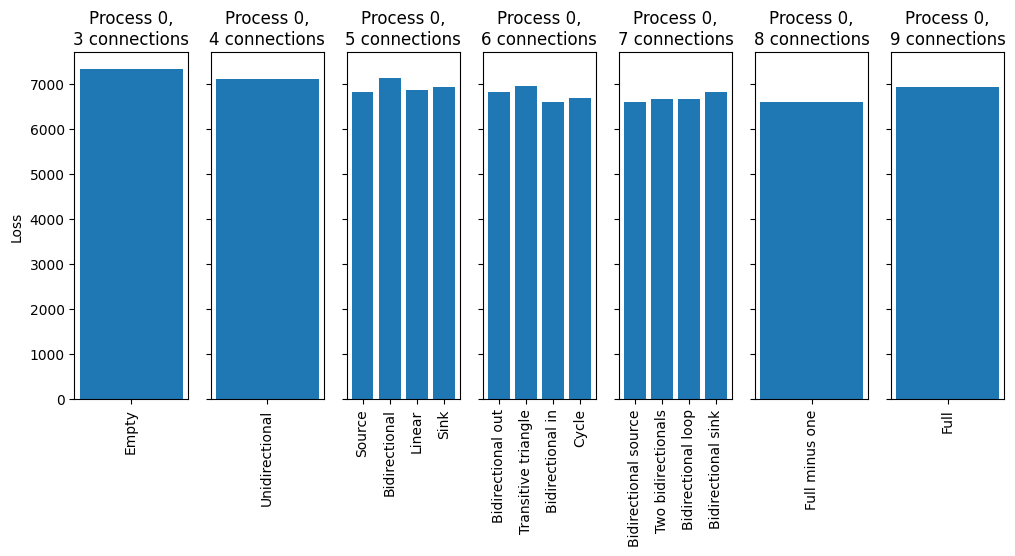

[{3: {'Empty': 7325.519862109245},
  4: {'Unidirectional': 7094.400806942795},
  5: {'Source': 6821.910202905255,
   'Bidirectional': 7133.151376137287,
   'Linear': 6860.584401249247,
   'Sink': 6921.252271760217},
  6: {'Bidirectional out': 6805.884711532586,
   'Transitive triangle': 6944.447165504853,
   'Bidirectional in': 6594.840770567939,
   'Cycle': 6676.477174477598},
  7: {'Bidirectional source': 6594.320093783393,
   'Two bidirectionals': 6651.85295977433,
   'Bidirectional loop': 6660.293995562441,
   'Bidirectional sink': 6819.432767965543},
  8: {'Full minus one': 6596.892399667221},
  9: {'Full': 6912.733204265702}}]

In [45]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 5e-6), np.full(15, 5e-7), np.full(30, 1e-7), np.full(50, 5e-8))),
           A=np.array([[0, 0.4, 0.5], [0.5, 0, 0.4], [0.4, 0.5, 0]]))

## Random bidirectional

In [51]:
# proc = mk_nd_proc(rng, 3,
#                   A=np.array([[0, 0.5, 0.4], [0.5, 0, 0.3], [0.4, 0.6, 0]]))
# compare_nn_kalman(rng, proc, np.concatenate((np.full(15, 5e-6), np.full(15, 5e-7), np.full(30, 1e-7))))

Process dynamics: [[0.  0.5 0.4]
 [0.5 0.  0.3]
 [0.4 0.6 0. ]]
Eigenvalues: [ 0.89007333+0.j         -0.44503666+0.06459796j -0.44503666-0.06459796j]
Kalman filter M: [[-0.03428466  0.33538319  0.28462765]
 [ 0.35492483 -0.03629621  0.21092639]
 [ 0.26929034  0.40644995 -0.03174902]]
Kalman filter K: [[0.26774713 0.02757833 0.05123873]
 [0.02757833 0.26014094 0.03751174]
 [0.05123873 0.03751174 0.27988447]]
Kalman filter loss: 6036.781464716516


  0%|                                                                | 0/16 [00:00<?, ?it/s]

Testing Empty, Trial 1
NN M: [[0.37917685 0.         0.        ]
 [0.         0.34004794 0.        ]
 [0.         0.         0.42412468]]
NN K: [[0.37545255 0.19001055 0.22394092]
 [0.20210082 0.38841715 0.21617014]
 [0.21444354 0.19340782 0.37633089]]
NN W: [[ 0.90152554 -0.10489519 -0.09563003]
 [-0.09180205  0.89470841 -0.10482261]
 [-0.10949588 -0.1106118   0.89231947]]
Loss: 7334.421880654595
Testing Empty, Trial 2
NN M: [[0.35329207 0.         0.        ]
 [0.         0.33759858 0.        ]
 [0.         0.         0.36884624]]
NN K: [[0.39902812 0.20183176 0.21816257]
 [0.23572102 0.39081596 0.22081724]
 [0.22160259 0.25155622 0.39002968]]
NN W: [[ 0.88723501 -0.10020023 -0.08117489]
 [-0.13107412  0.86318388 -0.07763039]
 [-0.09276281 -0.09712511  0.87052766]]
Loss: 7124.040864485631
Testing Empty, Trial 3


  6%|███▍                                                   | 1/16 [03:07<46:52, 187.52s/it]

NN M: [[0.37738255 0.         0.        ]
 [0.         0.39560453 0.        ]
 [0.         0.         0.38850025]]
NN K: [[0.40537304 0.20935801 0.25608677]
 [0.19394126 0.36707399 0.21399529]
 [0.2418946  0.22776801 0.42835669]]
NN W: [[ 0.87669285 -0.10771216 -0.13401067]
 [-0.11671936  0.91008902 -0.11475508]
 [-0.13378691 -0.10845077  0.86537309]]
Loss: 7570.741280653424
Testing Unidirectional, Trial 1
NN M: [[0.38313586 0.         0.        ]
 [0.16852396 0.25057729 0.        ]
 [0.         0.         0.36382346]]
NN K: [[0.39309574 0.16883753 0.21384944]
 [0.16276562 0.36160834 0.18620807]
 [0.23831696 0.20347386 0.40740063]]
NN W: [[ 0.89610651 -0.09973352 -0.08652268]
 [-0.10977341  0.91064523 -0.1095537 ]
 [-0.11448442 -0.07985747  0.88961884]]
Loss: 6966.638912544515
Testing Unidirectional, Trial 2
NN M: [[0.37735653 0.         0.        ]
 [0.23862594 0.20277206 0.        ]
 [0.         0.         0.35986727]]
NN K: [[0.41494575 0.17972035 0.24609771]
 [0.16479292 0.3379448 

 12%|██████▉                                                | 2/16 [06:19<44:19, 189.98s/it]

NN M: [[0.37479803 0.         0.        ]
 [0.19584233 0.20887576 0.        ]
 [0.         0.         0.30871097]]
NN K: [[0.38003756 0.18154977 0.21782501]
 [0.17812584 0.34461619 0.16207596]
 [0.2542838  0.22085531 0.42696122]]
NN W: [[ 0.89919699 -0.09830674 -0.08672933]
 [-0.10745502  0.91692901 -0.07921052]
 [-0.08414637 -0.05807792  0.85513535]]
Loss: 7337.370002644888
Testing Source, Trial 1
NN M: [[0.37321951 0.         0.        ]
 [0.24474232 0.21143733 0.        ]
 [0.24955123 0.         0.24549538]]
NN K: [[0.40060692 0.20117283 0.23268937]
 [0.12322971 0.29698928 0.12025407]
 [0.14692761 0.14277527 0.33995814]]
NN W: [[ 0.84789269 -0.07891043 -0.11374349]
 [-0.07129427  0.92886453 -0.06496639]
 [-0.09766784 -0.08368832  0.9200174 ]]
Loss: 6794.416554101272
Testing Source, Trial 2
NN M: [[0.36733927 0.         0.        ]
 [0.24201538 0.19815497 0.        ]
 [0.15149722 0.         0.26141173]]
NN K: [[0.38536069 0.17115835 0.20955896]
 [0.13903162 0.32213654 0.1266774 ]
 [0

 19%|██████████▎                                            | 3/16 [08:15<33:50, 156.18s/it]

NN M: [[0.41381897 0.         0.        ]
 [0.29302679 0.17285244 0.        ]
 [0.36003282 0.         0.11192095]]
NN K: [[0.39528584 0.17149168 0.22991689]
 [0.11848144 0.31439043 0.14291663]
 [0.17449624 0.1345417  0.38190798]]
NN W: [[ 0.87684312 -0.1046724  -0.1292913 ]
 [-0.09924664  0.94009412 -0.09840474]
 [-0.11366005 -0.07696747  0.9007036 ]]
Loss: 6362.525597405787
Testing Bidirectional, Trial 1
NN M: [[0.12425867 0.22726991 0.        ]
 [0.15126896 0.20311963 0.        ]
 [0.         0.         0.32317811]]
NN K: [[0.42128269 0.17842795 0.21966477]
 [0.21558343 0.39012632 0.20207567]
 [0.26429303 0.2335049  0.38593983]]
NN W: [[ 0.89915811 -0.11122046 -0.07502393]
 [-0.1289105   0.88094327 -0.07512672]
 [-0.07090949 -0.05316741  0.84611886]]
Loss: 7214.443864711696
Testing Bidirectional, Trial 2
NN M: [[0.21648046 0.16797321 0.        ]
 [0.15387939 0.20891424 0.        ]
 [0.         0.         0.37154007]]
NN K: [[0.39087777 0.18822512 0.22545031]
 [0.1647296  0.38128587 0

 25%|█████████████▊                                         | 4/16 [09:41<25:45, 128.79s/it]

NN M: [[0.26761295 0.12604553 0.        ]
 [0.14938517 0.24120593 0.        ]
 [0.         0.         0.35511463]]
NN K: [[0.40280816 0.14350082 0.20942589]
 [0.20119562 0.34240535 0.17554389]
 [0.25279648 0.21928546 0.39946908]]
NN W: [[ 0.89015564 -0.10869884 -0.05534089]
 [-0.13598315  0.90221842 -0.04802413]
 [-0.08793129 -0.0847782   0.85806334]]
Loss: 7066.823526692734
Testing Linear, Trial 1
NN M: [[0.39915644 0.         0.        ]
 [0.28220167 0.16123352 0.        ]
 [0.         0.21374285 0.24328168]]
NN K: [[0.37453034 0.18042797 0.22805259]
 [0.14425064 0.35187065 0.12792935]
 [0.21060151 0.20460476 0.39329058]]
NN W: [[ 0.88543501 -0.09910255 -0.10082565]
 [-0.09278413  0.92248311 -0.08880242]
 [-0.10878928 -0.12063017  0.88358449]]
Loss: 6422.21607083266
Testing Linear, Trial 2
NN M: [[0.40415708 0.         0.        ]
 [0.2054883  0.22325998 0.        ]
 [0.         0.27818501 0.14049115]]
NN K: [[0.35700257 0.16078417 0.20864483]
 [0.19667881 0.38402337 0.19959029]
 [0.

 31%|█████████████████▏                                     | 5/16 [11:04<20:34, 112.20s/it]

NN M: [[0.40013196 0.         0.        ]
 [0.35829117 0.07656998 0.        ]
 [0.         0.24501225 0.22069015]]
NN K: [[0.3954073  0.16976925 0.22768416]
 [0.13407184 0.32243579 0.11939384]
 [0.19553221 0.16983874 0.39672666]]
NN W: [[ 0.88059444 -0.10298936 -0.11579768]
 [-0.0880837   0.93696753 -0.07966929]
 [-0.1101114  -0.0933034   0.90060773]]
Loss: 6717.088877699842
Testing Sink, Trial 1
NN M: [[0.36675826 0.         0.        ]
 [0.24512834 0.06610095 0.09463454]
 [0.         0.         0.35678015]]
NN K: [[0.38827092 0.17889207 0.22313477]
 [0.12204674 0.33591485 0.12322605]
 [0.22800129 0.22513175 0.40069874]]
NN W: [[ 0.89348767 -0.08326865 -0.09944666]
 [-0.05740639  0.93582463 -0.07522823]
 [-0.08939957 -0.11183806  0.8927233 ]]
Loss: 7095.82172972676
Testing Sink, Trial 2
NN M: [[0.37282105 0.         0.        ]
 [0.10004955 0.1162593  0.23502811]
 [0.         0.         0.39650693]]
NN K: [[0.41280551 0.20353106 0.24381635]
 [0.14395393 0.34359514 0.15844697]
 [0.2488

 38%|████████████████████▋                                  | 6/16 [12:32<17:20, 104.03s/it]

NN M: [[0.37210848 0.         0.        ]
 [0.13100853 0.13466921 0.16148415]
 [0.         0.         0.37384822]]
NN K: [[0.37084886 0.15770581 0.22251   ]
 [0.15566392 0.33000259 0.16895061]
 [0.21738244 0.17485829 0.38919829]]
NN W: [[ 0.90983755 -0.07924947 -0.08096203]
 [-0.1102536   0.91273623 -0.07348749]
 [-0.07954083 -0.05414418  0.88605832]]
Loss: 6830.25545859788
Testing Bidirectional out, Trial 1
NN M: [[0.17270186 0.24757942 0.        ]
 [0.22112078 0.16613177 0.        ]
 [0.19170925 0.         0.26750042]]
NN K: [[0.38105018 0.1683714  0.22331164]
 [0.16532367 0.3673063  0.20242207]
 [0.1937283  0.17194462 0.38524399]]
NN W: [[ 0.89587423 -0.11648024 -0.09037286]
 [-0.11646956  0.90765214 -0.08789135]
 [-0.10937303 -0.11151306  0.89853509]]
Loss: 6907.126536764617
Testing Bidirectional out, Trial 2
NN M: [[0.28950887 0.22038449 0.        ]
 [0.24754025 0.08108902 0.        ]
 [0.17940048 0.         0.22373003]]
NN K: [[0.29338198 0.16815534 0.25237799]
 [0.15435711 0.365

 44%|████████████████████████▌                               | 7/16 [13:57<14:39, 97.74s/it]

NN M: [[0.12829445 0.28756027 0.        ]
 [0.21704951 0.18142805 0.        ]
 [0.18871661 0.         0.27043302]]
NN K: [[0.3998587  0.15777411 0.20079012]
 [0.1939712  0.38892921 0.20988387]
 [0.20476842 0.18656235 0.40557992]]
NN W: [[ 0.89696568 -0.10471093 -0.08819461]
 [-0.13291553  0.88939967 -0.10259552]
 [-0.12012845 -0.12829863  0.89291151]]
Loss: 6976.578451661201
Testing Transitive triangle, Trial 1
NN M: [[0.36167127 0.         0.        ]
 [0.20703449 0.21066173 0.        ]
 [0.18392278 0.15059687 0.13276297]]
NN K: [[0.40949789 0.18100415 0.24453381]
 [0.15195425 0.34721708 0.1544141 ]
 [0.2033692  0.18169631 0.37106828]]
NN W: [[ 0.88218495 -0.09951619 -0.10587969]
 [-0.10161762  0.93515652 -0.08874039]
 [-0.0889717  -0.10000561  0.88128352]]
Loss: 7079.121716269149
Testing Transitive triangle, Trial 2
NN M: [[0.3398575  0.         0.        ]
 [0.2307377  0.1708208  0.        ]
 [0.26319666 0.14781502 0.05288706]]
NN K: [[0.41283785 0.21216494 0.26139328]
 [0.143291   

 50%|████████████████████████████                            | 8/16 [15:29<12:45, 95.74s/it]

NN M: [[0.37357652 0.         0.        ]
 [0.25160694 0.16536859 0.        ]
 [0.19528286 0.2011363  0.05564208]]
NN K: [[0.40564331 0.19663944 0.24883787]
 [0.15827563 0.36842942 0.14891727]
 [0.16019295 0.15391524 0.38884539]]
NN W: [[ 0.8784539  -0.10621627 -0.12890094]
 [-0.10923172  0.9164812  -0.09619061]
 [-0.07880005 -0.08174475  0.90645587]]
Loss: 6810.125420633893
Testing Bidirectional in, Trial 1
NN M: [[0.02196718 0.20246102 0.21175615]
 [0.17385394 0.19573843 0.        ]
 [0.         0.         0.370392  ]]
NN K: [[0.35951746 0.12651031 0.1576205 ]
 [0.17671119 0.3835945  0.2023768 ]
 [0.21174418 0.18216634 0.38363697]]
NN W: [[ 0.92109803 -0.09593109 -0.05238639]
 [-0.1131612   0.89750844 -0.08702719]
 [-0.07219898 -0.05832277  0.88684146]]
Loss: 7201.627368366215
Testing Bidirectional in, Trial 2
NN M: [[0.18516754 0.10207331 0.15511193]
 [0.25834807 0.07869739 0.        ]
 [0.         0.         0.37810453]]
NN K: [[0.3467964  0.19032139 0.27138356]
 [0.16010273 0.3690

 56%|███████████████████████████████▌                        | 9/16 [16:59<10:57, 93.96s/it]

NN M: [[0.10007551 0.1445339  0.2708894 ]
 [0.23197695 0.21364637 0.        ]
 [0.         0.         0.39432646]]
NN K: [[0.32546359 0.09606374 0.14821711]
 [0.14467576 0.32608218 0.16311159]
 [0.18305149 0.177222   0.37672388]]
NN W: [[ 0.91839035 -0.08365177 -0.08287022]
 [-0.08450082  0.9062451  -0.09260864]
 [-0.05699964 -0.0672798   0.89653602]]
Loss: 6768.235488378094
Testing Cycle, Trial 1
NN M: [[0.15390229 0.         0.25755906]
 [0.23074429 0.15956673 0.        ]
 [0.         0.22468694 0.20909381]]
NN K: [[0.39920237 0.162241   0.25186434]
 [0.16378701 0.36791599 0.17658693]
 [0.19701451 0.19903705 0.42333362]]
NN W: [[ 0.88462321 -0.11425843 -0.13638581]
 [-0.09957809  0.9227677  -0.10416558]
 [-0.10161745 -0.11305955  0.89237861]]
Loss: 6876.501521492758
Testing Cycle, Trial 2
NN M: [[0.12130818 0.         0.26598182]
 [0.20555301 0.17853314 0.        ]
 [0.         0.25491258 0.21471737]]
NN K: [[0.36368233 0.14886549 0.18597614]
 [0.19011738 0.35914274 0.16856686]
 [0.1

 62%|██████████████████████████████████▍                    | 10/16 [18:37<09:31, 95.31s/it]

NN M: [[0.18085694 0.         0.24926244]
 [0.25025418 0.13036375 0.        ]
 [0.         0.16348903 0.30342649]]
NN K: [[0.33040626 0.14819824 0.19069546]
 [0.14734661 0.32802798 0.1535269 ]
 [0.17607505 0.18748446 0.36412121]]
NN W: [[ 0.91483525 -0.08152014 -0.09583885]
 [-0.06296364  0.93070189 -0.0657879 ]
 [-0.10093782 -0.09118965  0.90688326]]
Loss: 6684.274481509894
Testing Bidirectional source, Trial 1
NN M: [[0.19003274 0.21772339 0.        ]
 [0.24425555 0.16332841 0.        ]
 [0.11855736 0.1891187  0.18354257]]
NN K: [[0.39025    0.14071122 0.2017426 ]
 [0.16744019 0.38169302 0.17819422]
 [0.19123376 0.15454982 0.3522903 ]]
NN W: [[ 0.91418661 -0.08337652 -0.09091242]
 [-0.1126703   0.91673198 -0.10510935]
 [-0.09526886 -0.0903512   0.9001427 ]]
Loss: 6984.805946087826
Testing Bidirectional source, Trial 2
NN M: [[0.14058828 0.28659713 0.        ]
 [0.14334862 0.25364874 0.        ]
 [0.17582816 0.13386107 0.13918541]]
NN K: [[0.37253656 0.14996616 0.17532106]
 [0.1748883

 69%|█████████████████████████████████████▊                 | 11/16 [20:10<07:52, 94.55s/it]

NN M: [[0.13150748 0.24938231 0.        ]
 [0.17465509 0.24572221 0.        ]
 [0.2291905  0.18198345 0.05615163]]
NN K: [[0.38885426 0.19497483 0.23227768]
 [0.18678647 0.34614735 0.19907511]
 [0.18527736 0.16318366 0.37456471]]
NN W: [[ 0.90111232 -0.10593185 -0.10220968]
 [-0.11323464  0.90374395 -0.11755494]
 [-0.08974124 -0.09208192  0.89979774]]
Loss: 6749.405889281193
Testing Two bidirectionals, Trial 1
NN M: [[0.01944936 0.19816868 0.20782705]
 [0.1232591  0.25921632 0.        ]
 [0.16882926 0.         0.19398405]]
NN K: [[0.34631121 0.17581434 0.18435702]
 [0.16258048 0.38552968 0.20152278]
 [0.27141769 0.21742022 0.42027422]]
NN W: [[ 0.88961843 -0.10028368 -0.06951646]
 [-0.08917415  0.91491789 -0.11749416]
 [-0.11973684 -0.0846724   0.86509954]]
Loss: 6902.482805666269
Testing Two bidirectionals, Trial 2
NN M: [[0.11355955 0.17547301 0.14849867]
 [0.0974295  0.27778303 0.        ]
 [0.20584475 0.         0.17648375]]
NN K: [[0.32816182 0.2069012  0.20133381]
 [0.17452744 0.

 75%|█████████████████████████████████████████▎             | 12/16 [21:43<06:16, 94.08s/it]

NN M: [[0.19418228 0.20950969 0.11181001]
 [0.07604519 0.26774431 0.        ]
 [0.20643336 0.         0.16772755]]
NN K: [[0.28477617 0.16470785 0.17383587]
 [0.19847426 0.40973149 0.22098557]
 [0.17552105 0.203216   0.41179522]]
NN W: [[ 0.88361901 -0.06674556 -0.10992293]
 [-0.11039417  0.88450509 -0.10346991]
 [-0.07016029 -0.07593473  0.89410033]]
Loss: 7192.334258001468
Testing Bidirectional loop, Trial 1
NN M: [[0.13369916 0.24718286 0.        ]
 [0.1304654  0.06289893 0.20114089]
 [0.19157365 0.         0.21213765]]
NN K: [[0.37817477 0.15032967 0.19471421]
 [0.18363718 0.38773174 0.1850137 ]
 [0.22236231 0.18214715 0.40653337]]
NN W: [[ 0.91826608 -0.06322463 -0.08824443]
 [-0.12365274  0.89974588 -0.10424276]
 [-0.09627881 -0.10669875  0.90736733]]
Loss: 7130.755883497882
Testing Bidirectional loop, Trial 2
NN M: [[0.23761001 0.16494052 0.        ]
 [0.11293001 0.03024066 0.24356694]
 [0.18150743 0.         0.23183035]]
NN K: [[0.37494457 0.20528975 0.21276098]
 [0.15738321 0.

 81%|████████████████████████████████████████████▋          | 13/16 [23:17<04:42, 94.03s/it]

NN M: [[0.14033634 0.26264525 0.        ]
 [0.07578928 0.12266298 0.19887599]
 [0.22939148 0.         0.20518689]]
NN K: [[0.36874607 0.18376956 0.20021215]
 [0.17937725 0.42515479 0.21630462]
 [0.20323954 0.18756084 0.39265144]]
NN W: [[ 0.91629922 -0.11149184 -0.09203645]
 [-0.1278384   0.8665441  -0.11918012]
 [-0.08881766 -0.11132537  0.89824596]]
Loss: 6794.569188983218
Testing Bidirectional sink, Trial 1
NN M: [[0.37020866 0.         0.        ]
 [0.28069216 0.06907876 0.07070028]
 [0.11265983 0.14615578 0.2311351 ]]
NN K: [[0.38850709 0.17095443 0.22116734]
 [0.15109505 0.35372486 0.15721031]
 [0.21319273 0.17679886 0.34461795]]
NN W: [[ 0.8943131  -0.09418536 -0.07540189]
 [-0.09275509  0.92428881 -0.10270463]
 [-0.08929746 -0.10188073  0.87399153]]
Loss: 6788.897477452027
Testing Bidirectional sink, Trial 2
NN M: [[0.38821983 0.         0.        ]
 [0.20900409 0.05515993 0.12887235]
 [0.18583527 0.1965191  0.06781767]]
NN K: [[0.39982286 0.21125666 0.23640448]
 [0.11654104 0.

 88%|████████████████████████████████████████████████▏      | 14/16 [24:59<03:13, 96.58s/it]

NN M: [[0.32961184 0.         0.        ]
 [0.2048598  0.17411183 0.05986746]
 [0.17742064 0.15668753 0.17447513]]
NN K: [[0.41729478 0.17440603 0.19586571]
 [0.19553007 0.37316729 0.19096771]
 [0.22591469 0.18183824 0.32790849]]
NN W: [[ 0.89987307 -0.0628461  -0.06115131]
 [-0.09372743  0.87691381 -0.14212832]
 [-0.09813791 -0.10599664  0.86927546]]
Loss: 7284.1136842971
Testing Full minus one, Trial 1
NN M: [[0.12560752 0.14729398 0.15496516]
 [0.20196243 0.18240052 0.        ]
 [0.0815759  0.21068579 0.16507974]]
NN K: [[0.39771512 0.19116579 0.22345472]
 [0.15057238 0.37740847 0.18546737]
 [0.24512215 0.20610954 0.44015909]]
NN W: [[ 0.880786   -0.13050406 -0.10972821]
 [-0.08406726  0.91586516 -0.09906377]
 [-0.15173055 -0.10831405  0.86454717]]
Loss: 7205.667846411813
Testing Full minus one, Trial 2
NN M: [[0.11243861 0.04949844 0.22990184]
 [0.17691144 0.17120812 0.        ]
 [0.10395396 0.18312341 0.20716062]]
NN K: [[0.38129115 0.16883741 0.24365791]
 [0.16378525 0.37023254 0

 94%|███████████████████████████████████████████████████▌   | 15/16 [26:40<01:37, 97.87s/it]

NN M: [[0.08807458 0.23753217 0.15884344]
 [0.06340114 0.30895271 0.        ]
 [0.15140881 0.20594323 0.14872206]]
NN K: [[0.32833818 0.14968315 0.17753364]
 [0.21092413 0.39513689 0.26466105]
 [0.19657308 0.18367821 0.38452712]]
NN W: [[ 0.87514563 -0.07665082 -0.10893617]
 [-0.11375892  0.86974048 -0.1416332 ]
 [-0.14643342 -0.09848469  0.87475609]]
Loss: 6932.807971244931
Testing Full, Trial 1
NN M: [[0.18693279 0.1346481  0.14098246]
 [0.18386289 0.08800136 0.09379045]
 [0.1913847  0.14123465 0.10625019]]
NN K: [[0.37096429 0.23510011 0.23897125]
 [0.15549505 0.39460988 0.18310539]
 [0.19599277 0.21558872 0.41729386]]
NN W: [[ 0.86287424 -0.12734117 -0.1546125 ]
 [-0.09968487  0.91778955 -0.10444819]
 [-0.12080255 -0.11060688  0.88720907]]
Loss: 6761.641613479192
Testing Full, Trial 2
NN M: [[-0.04174456  0.16759791  0.26156912]
 [ 0.13636775  0.14631365  0.12780136]
 [ 0.18268176  0.19635472  0.14398201]]
NN K: [[0.39811973 0.18030811 0.20759457]
 [0.18231317 0.3969204  0.2045951 

100%|██████████████████████████████████████████████████████| 16/16 [28:16<00:00, 106.03s/it]

NN M: [[0.2963799  0.01905821 0.10306175]
 [0.16816964 0.14685525 0.05859677]
 [0.19450061 0.17953869 0.09180893]]
NN K: [[0.45442086 0.22728793 0.25273015]
 [0.17434981 0.35724131 0.19083218]
 [0.17139145 0.16562028 0.35622102]]
NN W: [[ 0.82722388 -0.14492715 -0.1467198 ]
 [-0.09950289  0.91926175 -0.10670826]
 [-0.08253148 -0.0888461   0.89391885]]
Loss: 6787.385715861796


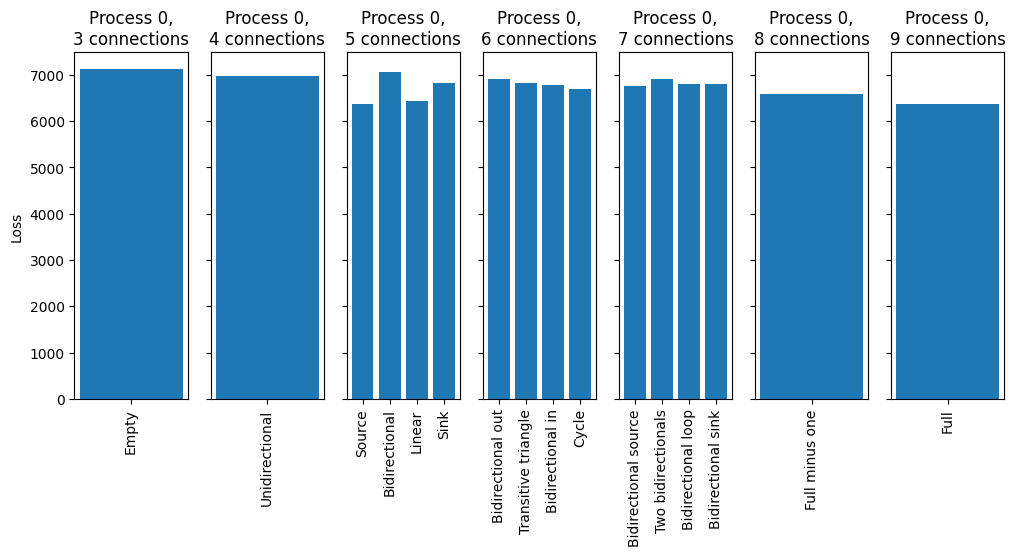

[{3: {'Empty': 7124.040864485631},
  4: {'Unidirectional': 6966.638912544515},
  5: {'Source': 6362.525597405787,
   'Bidirectional': 7066.823526692734,
   'Linear': 6422.21607083266,
   'Sink': 6830.25545859788},
  6: {'Bidirectional out': 6907.126536764617,
   'Transitive triangle': 6810.125420633893,
   'Bidirectional in': 6768.235488378094,
   'Cycle': 6684.274481509894},
  7: {'Bidirectional source': 6749.405889281193,
   'Two bidirectionals': 6902.482805666269,
   'Bidirectional loop': 6794.569188983218,
   'Bidirectional sink': 6788.897477452027},
  8: {'Full minus one': 6586.297996514593},
  9: {'Full': 6368.211275708078}}]

In [52]:
test_masks(rng, 3, masks_three_neurons_all_loops, np.concatenate((np.full(15, 5e-6), np.full(15, 5e-7), np.full(30, 1e-7))),
           A=np.array([[0, 0.5, 0.4], [0.5, 0, 0.3], [0.4, 0.6, 0]]))